# Velocity Obstacle formulation for goal reaching

Output videos : https://drive.google.com/drive/folders/16qgWP3IsBTEbeLMt03lnuD8mVyKi5Gg0?usp=sharing


## Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

## Helper classes

In [2]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def draw(self, ax, color, marker, size):
        ax.scatter(self.x, self.y, c=color, marker=marker, s=size)

class Circle():
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def get_r(self):
        return self.r
        
    def draw(self, ax, color):
        circle = plt.Circle((self.x, self.y), self.r, color=color, fill=False)
        ax.add_patch(circle)

## Defining the Robot and Obstacle classes

In [3]:
class Robot(Circle):
    def __init__(self, x, y, r, max_vel):
        super().__init__(x, y, r)
        self.max_vel = max_vel
        self.trajectory = [Point(x,y)]
    
    def update(self, new_point):
        self.x = new_point.x
        self.y = new_point.y
        self.trajectory.append(Point(self.x,self.y))

    def draw_trajectory(self, ax):
        for i in range(len(self.trajectory) - 1):
            x = [self.trajectory[i].x, self.trajectory[i+1].x]
            y = [self.trajectory[i].y, self.trajectory[i+1].y]
            ax.plot(x, y, c='y', marker='o', markersize=5)

        
class Obstacle(Circle):
    def __init__(self, x, y, r, vel, theta):
        super().__init__(x, y, r)
        self.velx = vel * np.cos(theta)
        self.vely = vel * np.sin(theta)
        self.trajectory = [Point(x,y)] 
        
    def update(self, dt):
        self.x = self.x + self.velx * dt
        self.y = self.y + self.vely * dt
        self.trajectory.append(Point(self.x,self.y))
    
    def draw_trajectory(self, ax):
        for i in range(len(self.trajectory) - 1):
            x = [self.trajectory[i].x, self.trajectory[i+1].x]
            y = [self.trajectory[i].y, self.trajectory[i+1].y]
            ax.plot(x, y, c='b', marker='*', markersize=5)

## Collision cone function
Function takes as argument the current obstacle and robot positions, and the robot velocity to be checked. It computes the relative velocity and position.

Function check whether the provided constraint is satisfied for provided robot velocity and obstacle.

![image](./vocc.jpeg)

In [4]:
def check_within_vo(obstacle, robot, rvel, theta):
    # compute the relative velocity
    relvx, relvy = rvel * np.cos(theta) - obstacle.velx, \
                   rvel * np.sin(theta) - obstacle.vely
    # compute the relative position
    rx, ry = obstacle.x - robot.x, \
             obstacle.y - robot.y
    
    r2 = rx**2 + ry**2
    rvel2 = relvx**2 + relvy**2
    dot_prod2 = (rx*relvx + ry*relvy)**2
    
    # compute the configuration radius
    cr2 = (obstacle.r + robot.r)**2
    
    # compute the constraint condition 
    condition = (r2 - dot_prod2 / rvel2) >= cr2
    return condition

## Environment
The environment is predefined, rectangular, with specified start and goal points.

In [5]:
class Env:
    def __init__(self, xmin, xmax, ymin, ymax, start, goal):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
        self.start = start
        self.goal = goal
        
        self.fig, self.ax = plt.subplots(1, 1, figsize=(15,15))
        
    def draw_env(self, robot, obstacles, step):
        self.refresh_plot()
        
        self.add_title('Velocity Obstacle: Test Case - 1')
        
        self.goal.draw(self.ax, 'g', '*', 100)
        self.start.draw(self.ax,'r', '*', 100)
        
        for obstacle in obstacles:
            obstacle.draw(env.ax, 'r')
            obstacle.draw_trajectory(self.ax)
       
        robot.draw_trajectory(self.ax)
        robot.draw(env.ax, 'b')

        env.fig.savefig('./output-1/{}.png'.format(str(step)), dpi=100)
        
        plt.show()
        plt.close()
        
    def refresh_plot(self):
        self.fig, self.ax = plt.subplots(1, 1, figsize=(15,15))
            
    def draw_path(self, pathx, pathy):
        self.ax.plot(pathx,pathy)
            
    def add_title(self, title):
        self.ax.set_title(title, loc='center', fontweight ="bold")

## Trajectory computation

### Assumptions
- Obstacles are circular in shape
- Obstacle sizes, initial positions and velocities are known to the robot during planning. 
- All obstacles have constant velocity throughout the motion.
- The robot is omni-wheel, omni-directional (holonomic), and has a specified maximum velocity.

### Method
- **We use a sampling based method with the holonomic robot.**
- At each point of the trajectory, we sample many possible velocities for the robot, to take the next step.
  - For each of the sampled velocities, we check whether it will put the robot in a collision trajectory with any obstacle. 
  - For a particular sampled velocity, for every obstacle, we compute the collision cone as described earlier. 
  - We check whether the relative velocity lies within the collision cone, in which case it collides, and if not, it is a valid step.
  - Using this method we filter out all the valid steps
- We use a cost function to decide the best step to take from all the filtered valid velocities from the previous step. For our purpose we use a simple cost function(L2 norm on the distance) to select the step which takes us nearest to the goal.
- We continue the above cycle, till we reach the goal point

![](./opti.jpeg)

In [7]:
class VOTrajectory:
    def __init__(self,env, start, end, robot, obstacles, dt):
        
        self.env = env
        self.robot = robot
        self.obstacles = obstacles

        self.traj = [start]
        self.goal = end
        
        self.dt = dt
        self.gen_rand = 100 # velocities sampled at each step
        self.goal_thresh = 1 # threshold within which goal is reached

        self.found_path = False
    
    def get_random_vel(self, cur_step):
        """ 
        Returns a random velocity vector for the robot
        from a uniform probability distribution (0, max velocity)
        Also returns the next step that this velocity would make
        the robot reach.
        """
        theta = np.random.uniform(0, 2*np.pi)
        vel = np.random.uniform(0, self.robot.max_vel)

        x = cur_step.x + vel * self.dt * np.cos(theta)
        y = cur_step.y + vel * self.dt * np.sin(theta)
        
        return vel, theta, Point(x,y)
        
    def cost_function(self, next_step):
        """ 
        Computes the L2 distance between a given step and the goal node
        """
        goalX, goalY = self.goal.get_x(), self.goal.get_y() 
        nextX, nextY = next_step.get_x(), next_step.get_y()

        cost = np.sqrt((nextX - goalX)**2 + (nextY - goalY)**2)
        
        return cost
    
    def engine(self):
        best_cost = self.cost_function(self.traj[-1])
        step = 0
        while not self.found_path:    
            best_step = None
            
            # generate random velocities to be taken as next step
            for _ in range(self.gen_rand):
                collision_free_step = True
              
                # compute a random next step for the robot to take
                next_vel, next_theta, next_step = self.get_random_vel(self.traj[-1])
              
               # check whether the sampled velocity lies within the collision cone of any obstacle
                for obs in self.obstacles:
                    if not check_within_vo(obs, robot, next_vel, next_theta):
                        collision_free_step = False
                        break
              
                # if it is a collision free step, compute cost 
                # and check if it is the best step yet      
                if collision_free_step:
#                     idx += 1
                    cost = self.cost_function(next_step)
                    if cost < best_cost:
                        best_cost = cost
                        best_step = next_step
            
            if best_step is not None:
                step += 1
                self.traj.append(best_step)
                for obs in self.obstacles:
                    obs.update(self.dt)
                self.robot.update(best_step)
                
            # check if goal has been reached   
            if best_cost < self.goal_thresh:
                self.found_path = True
                break
            
            self.env.draw_env(self.robot, self.obstacles, step) 

## Testing it out

### Test Case: 1

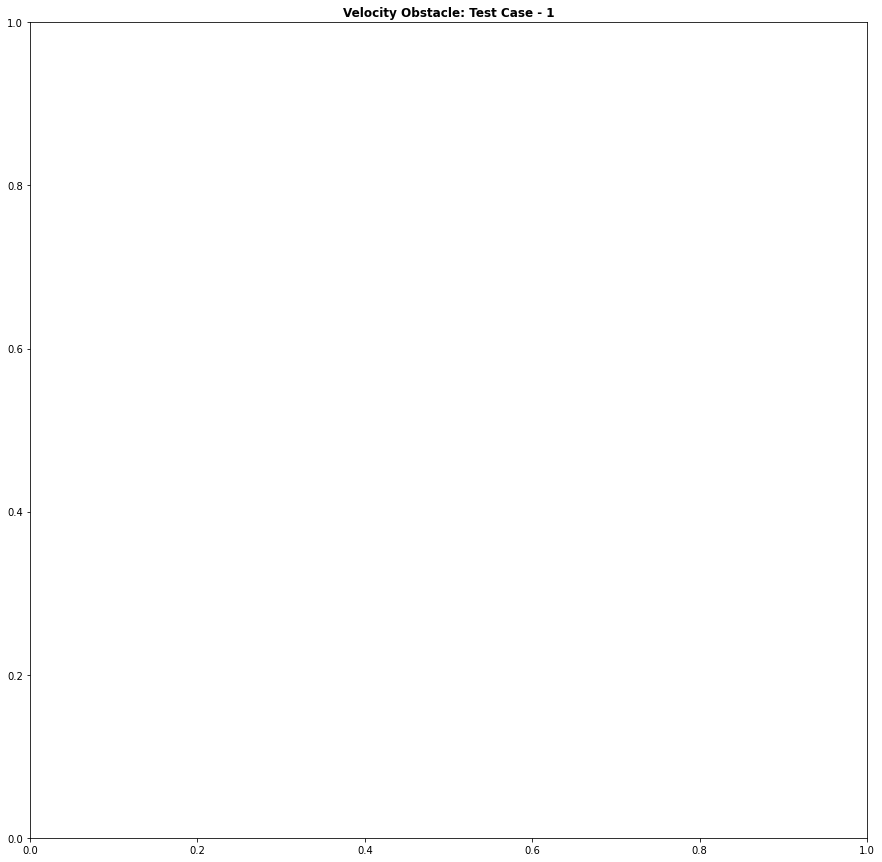

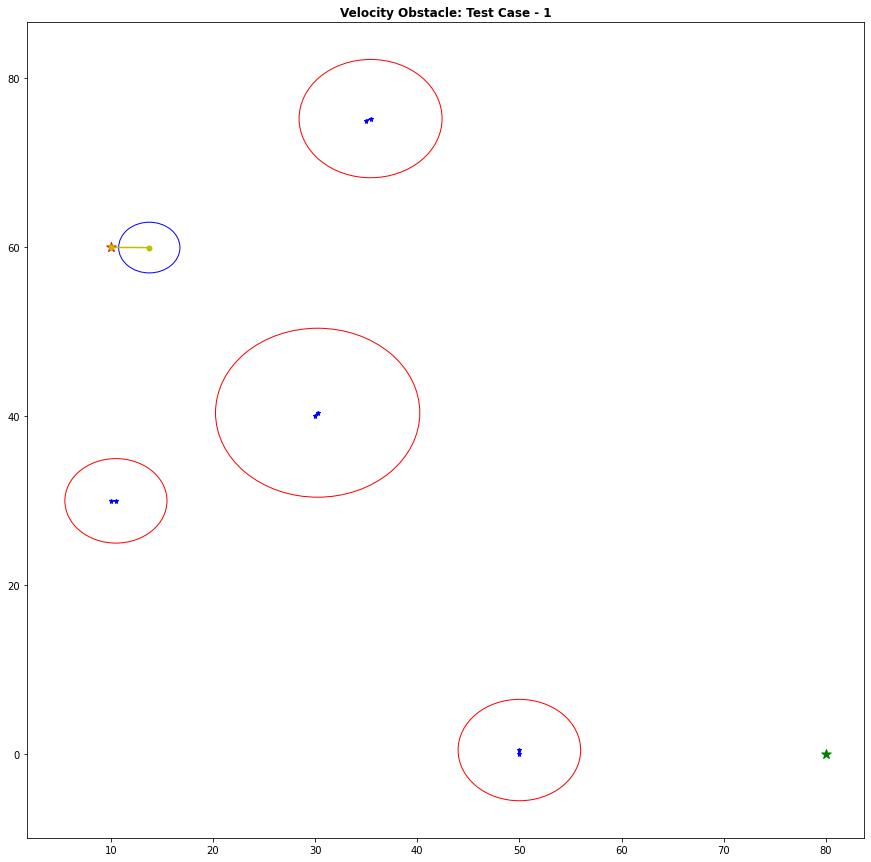

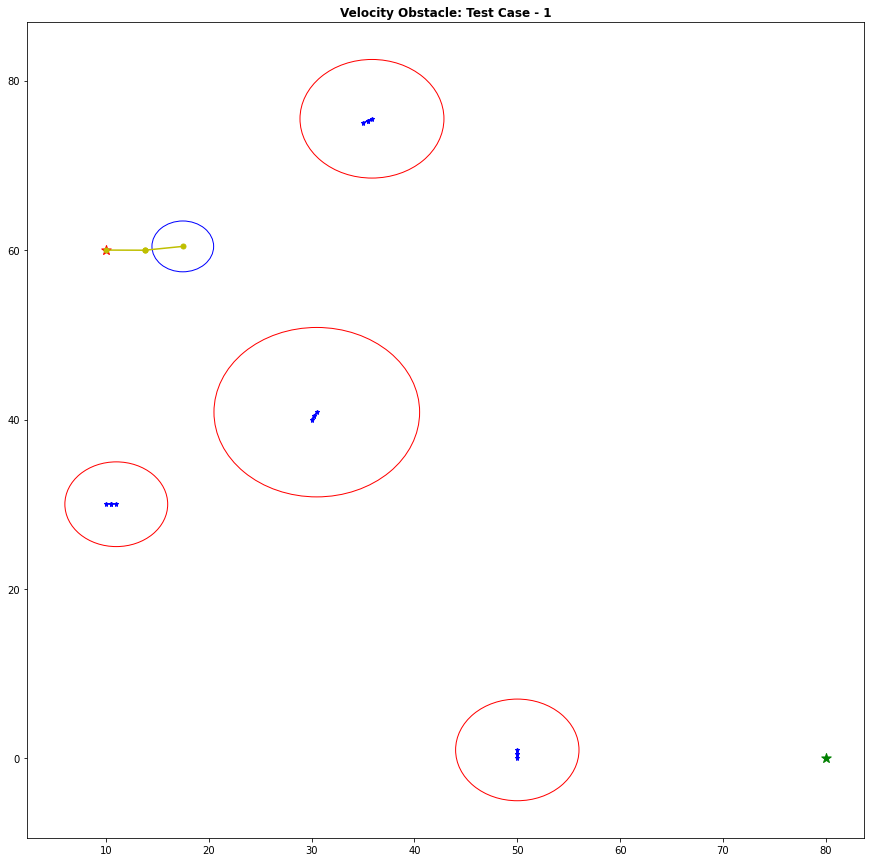

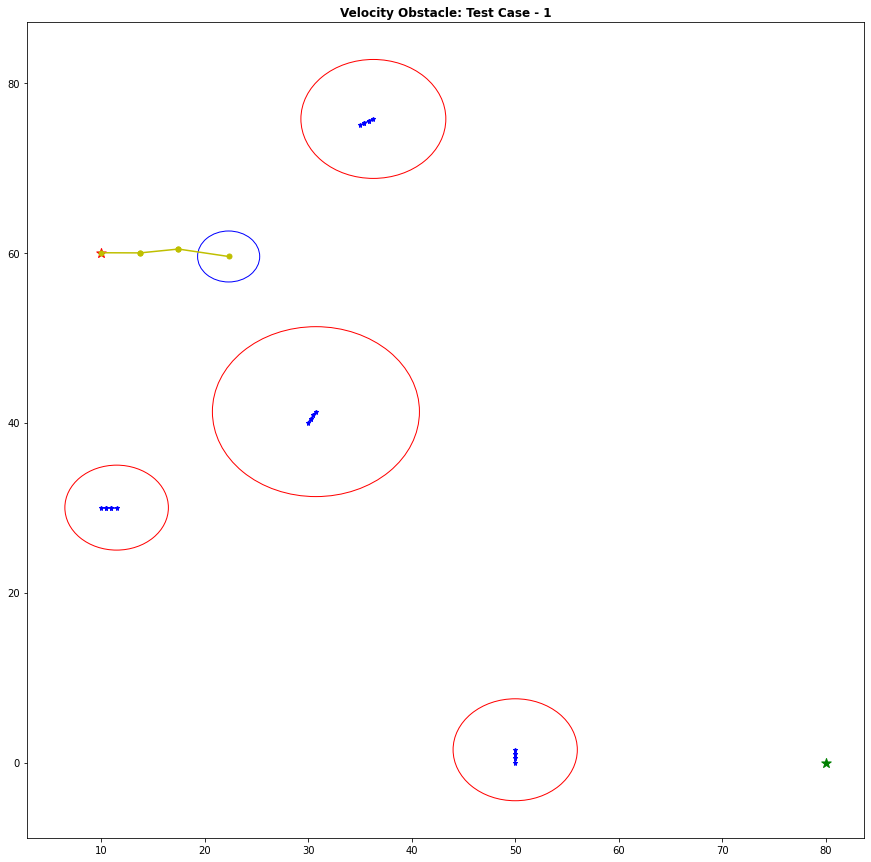

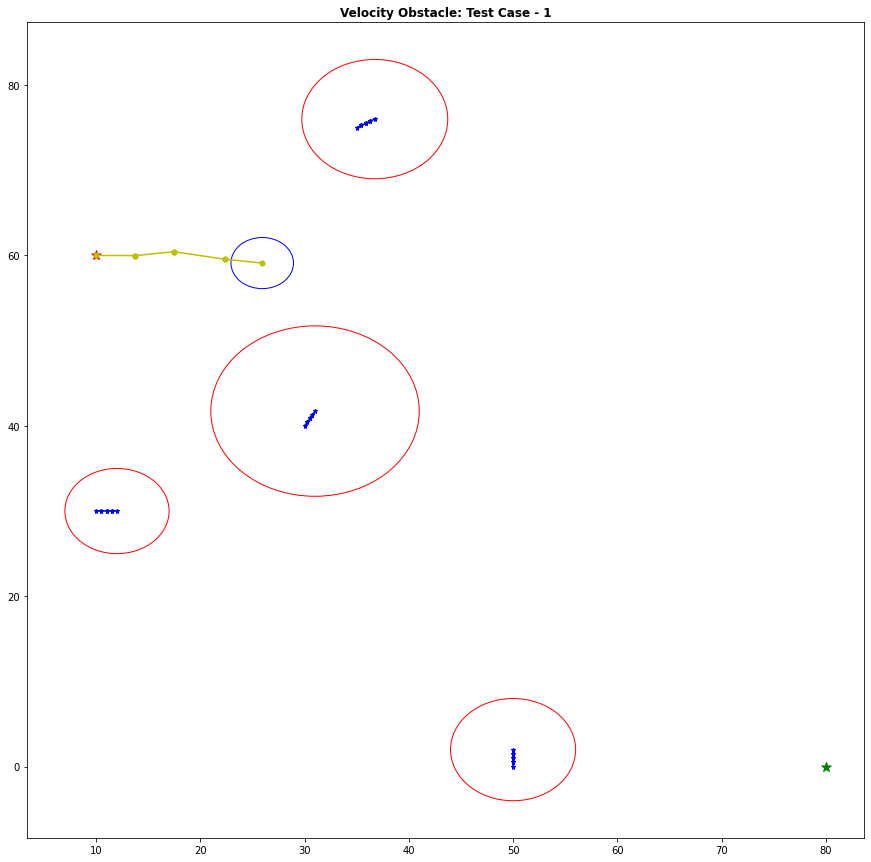

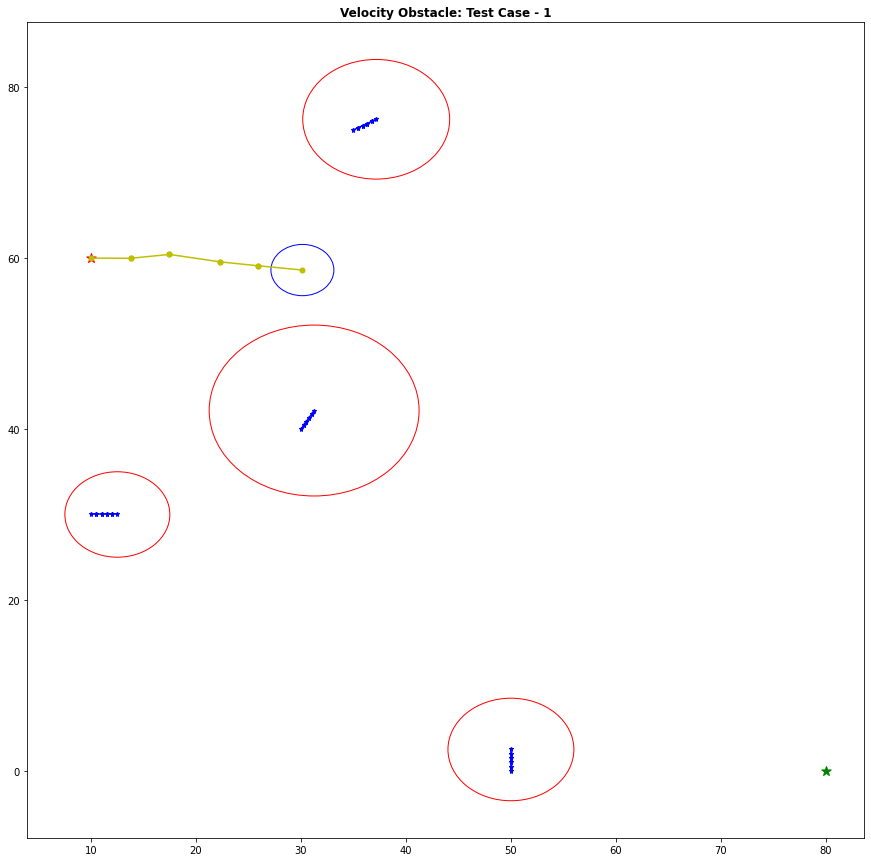

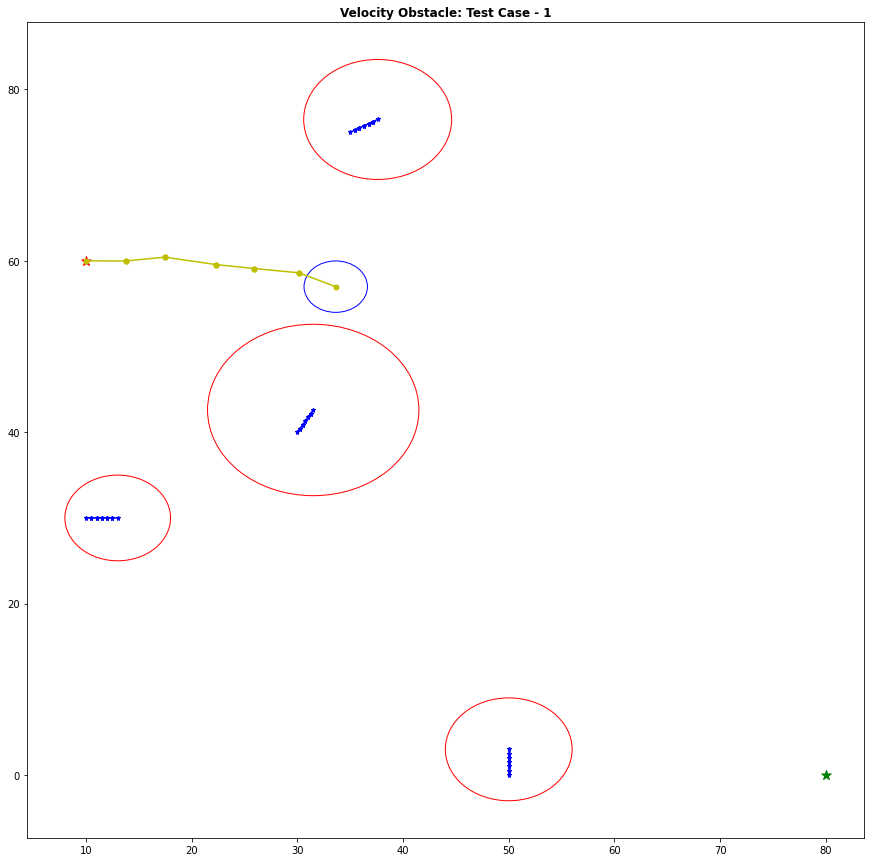

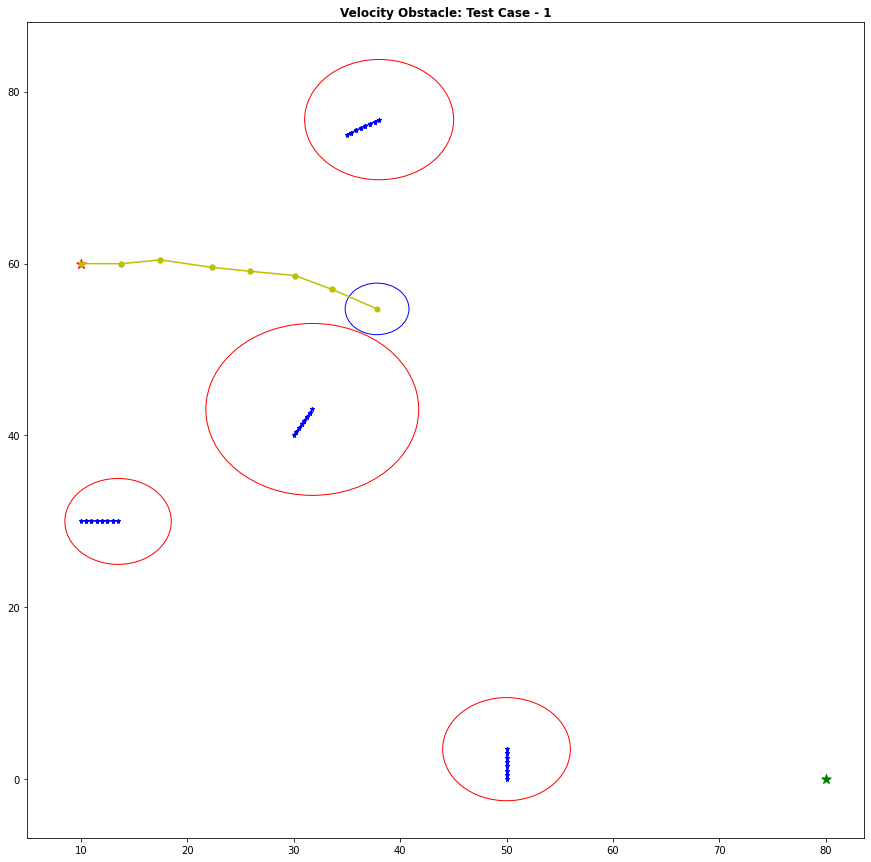

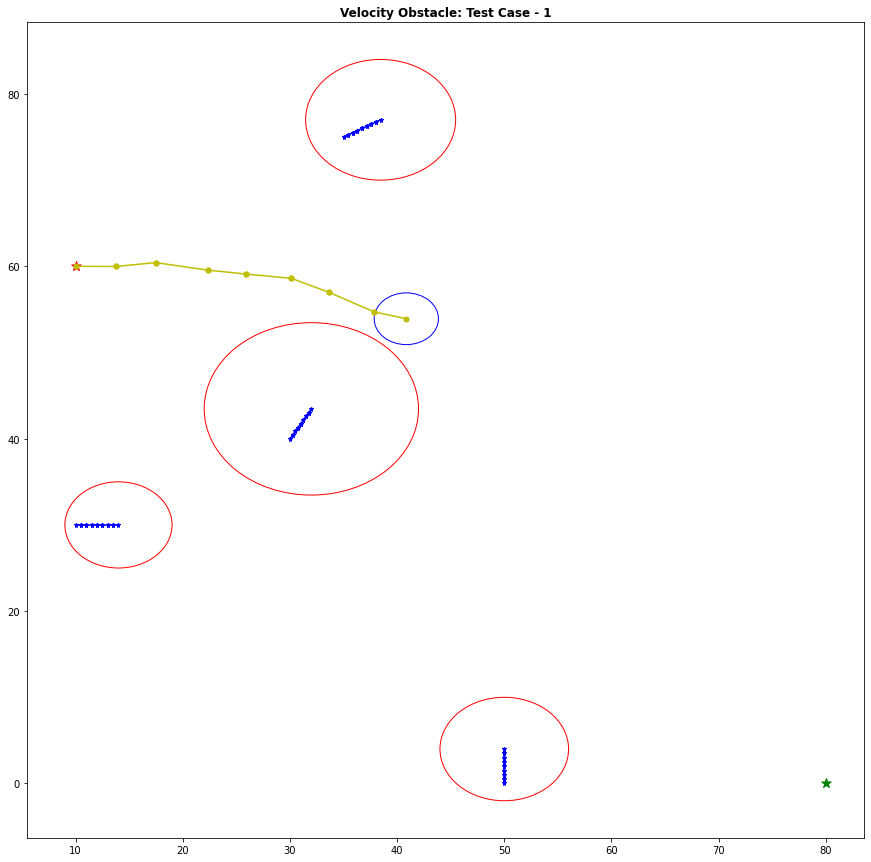

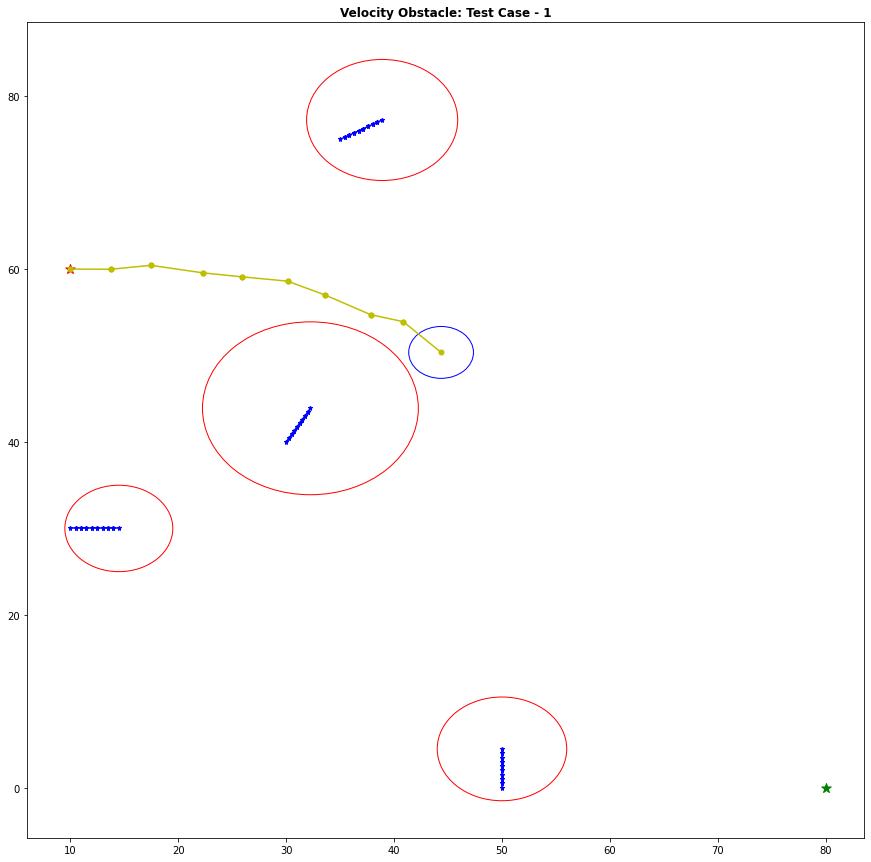

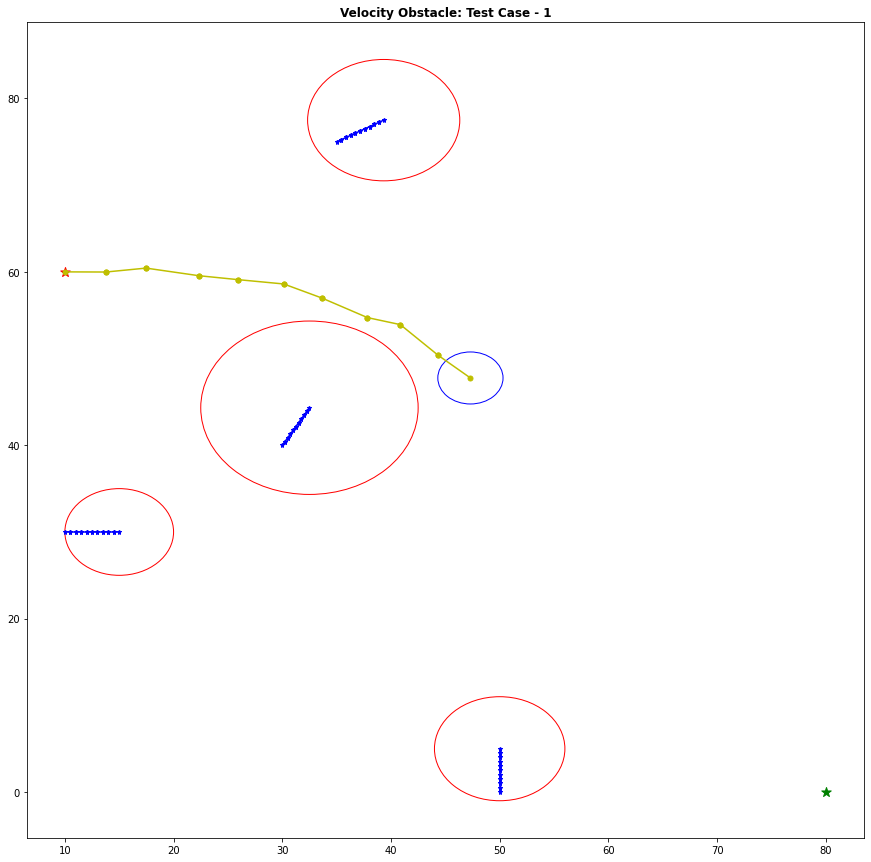

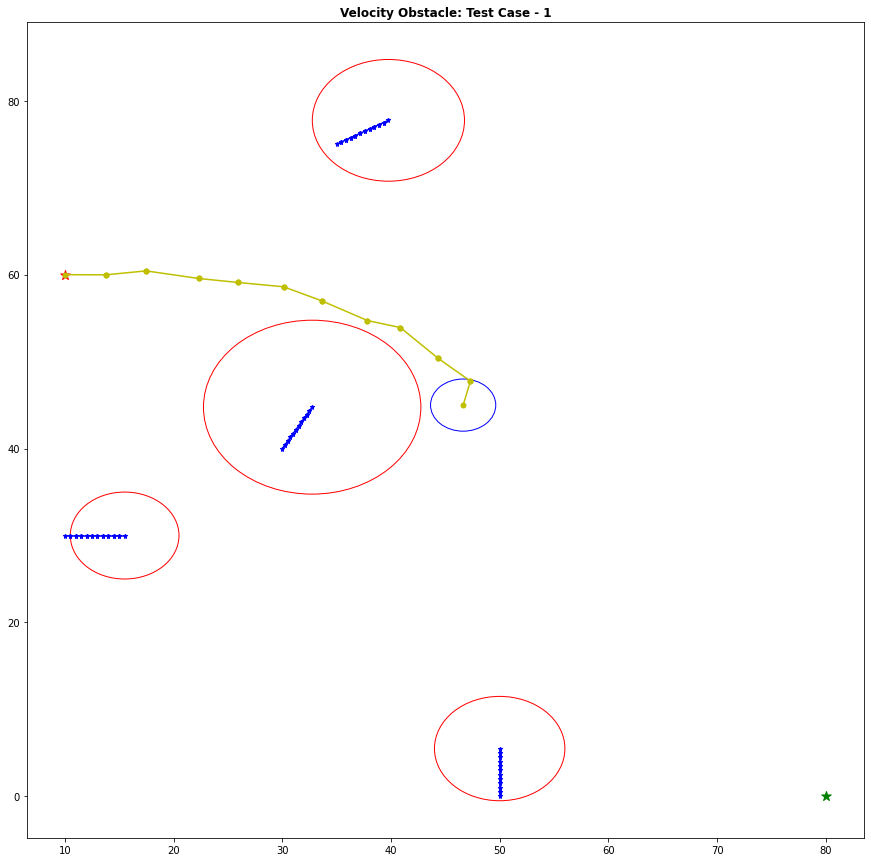

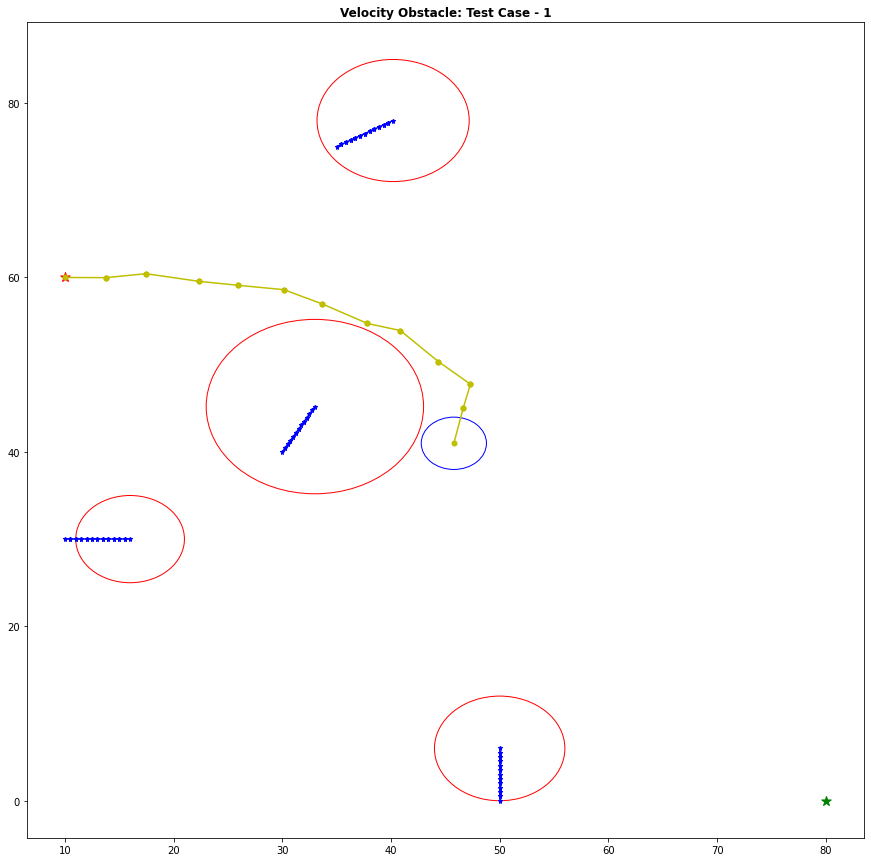

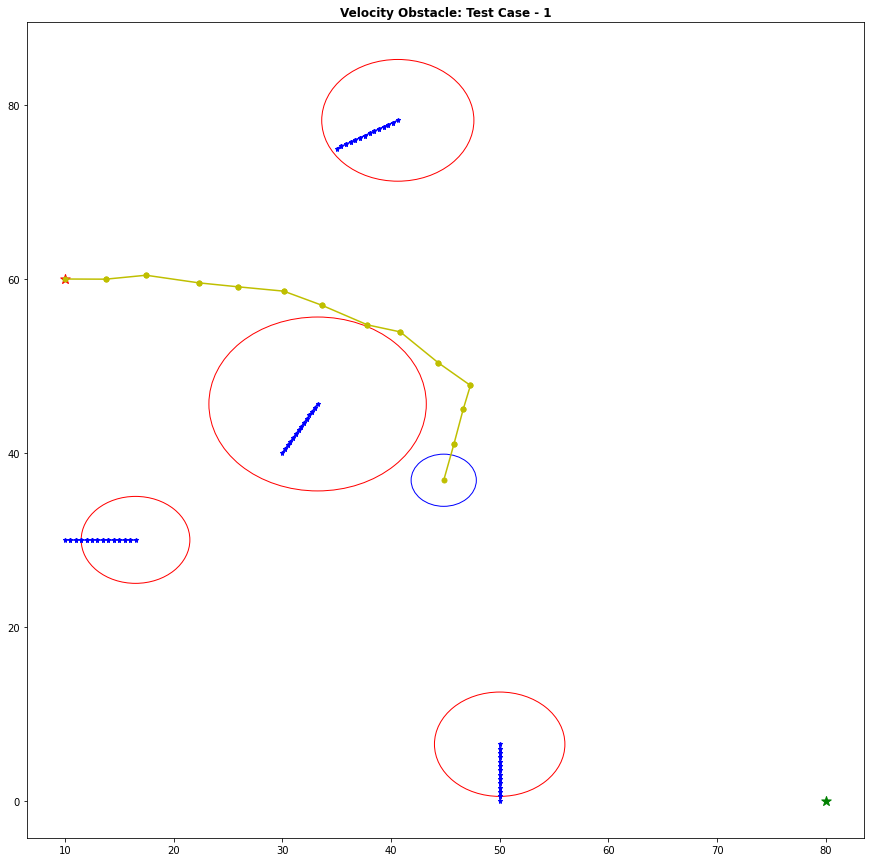

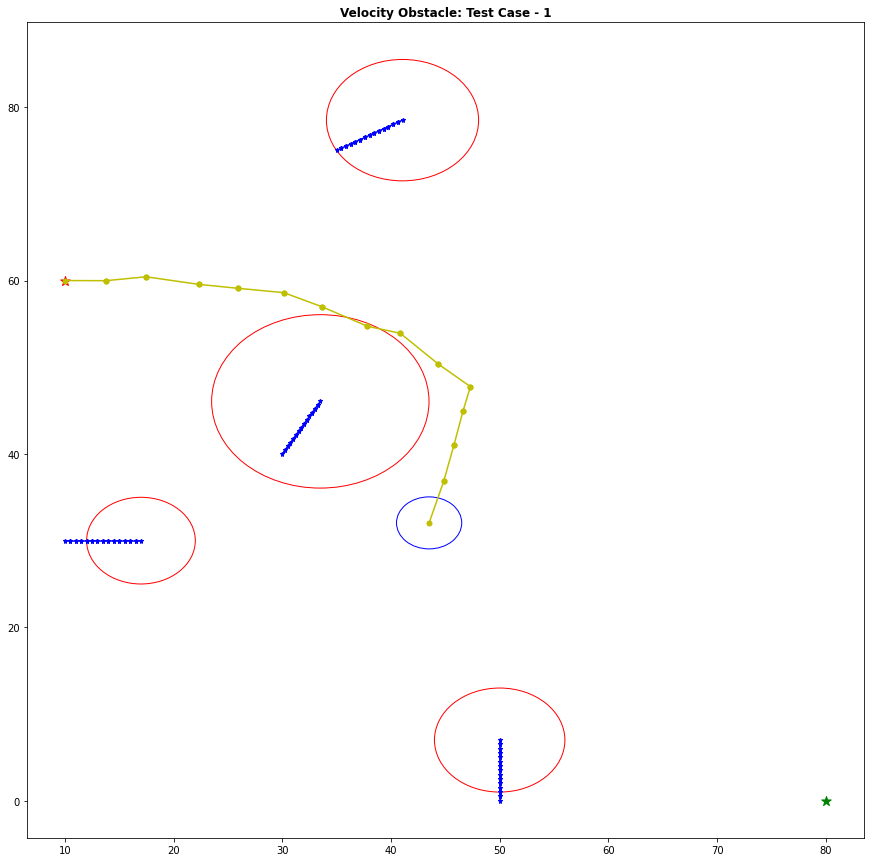

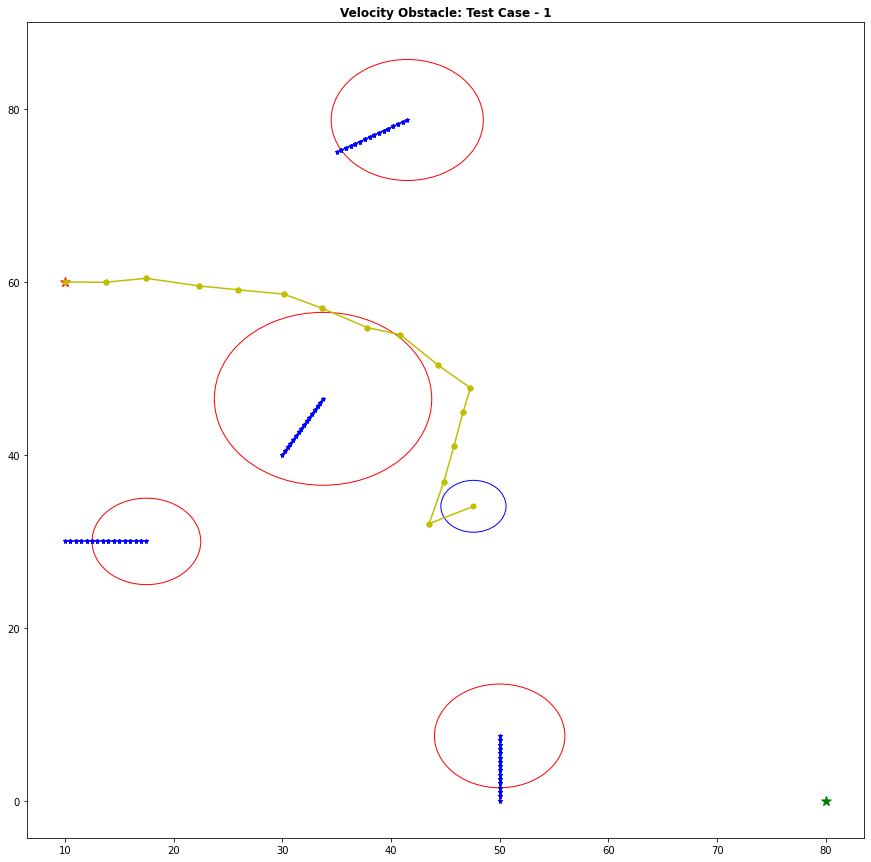

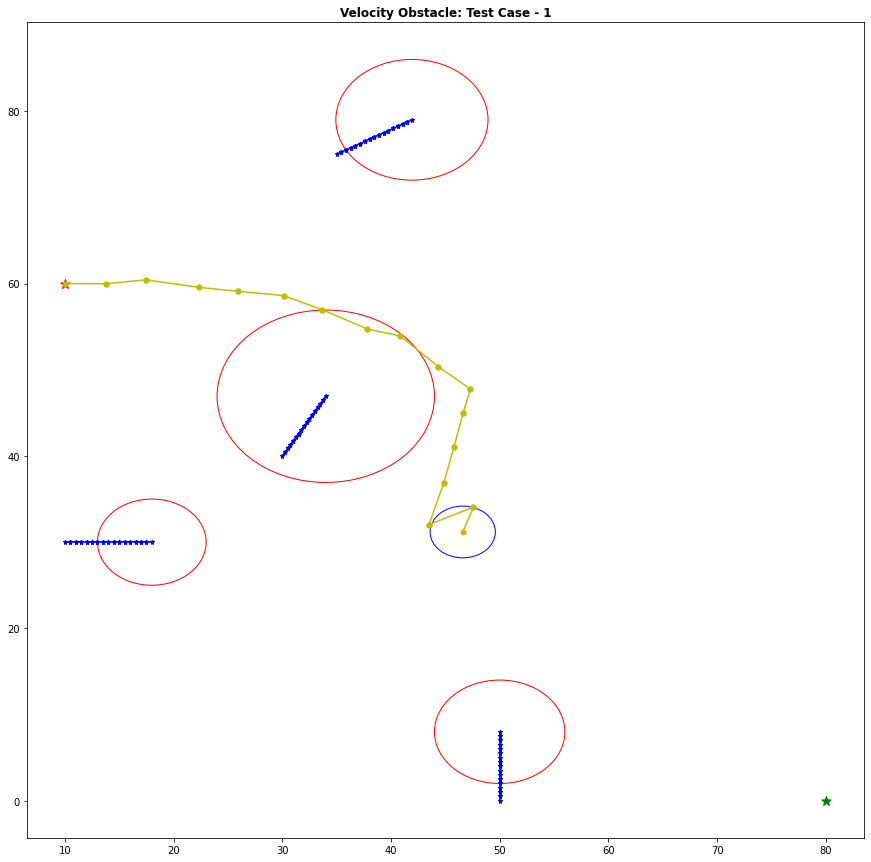

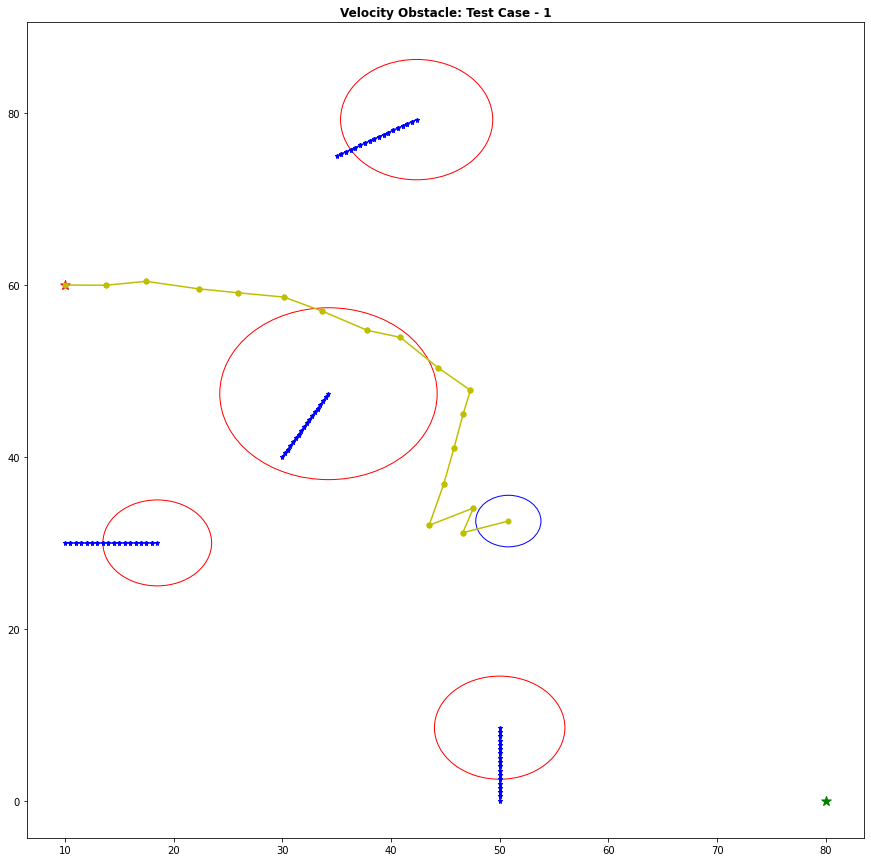

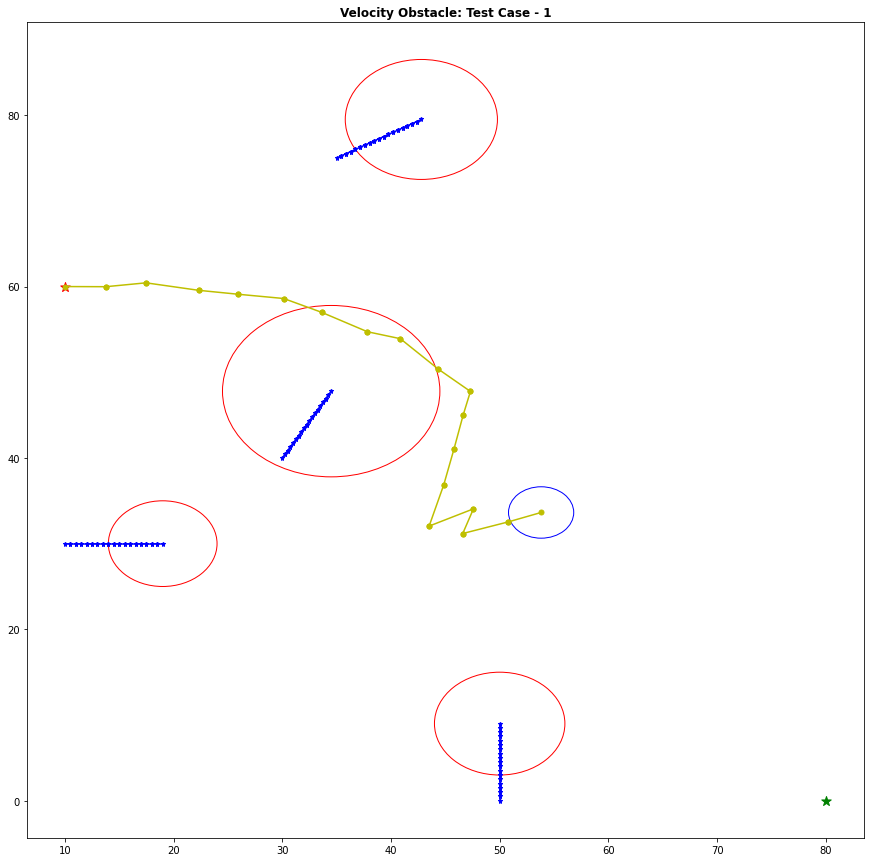

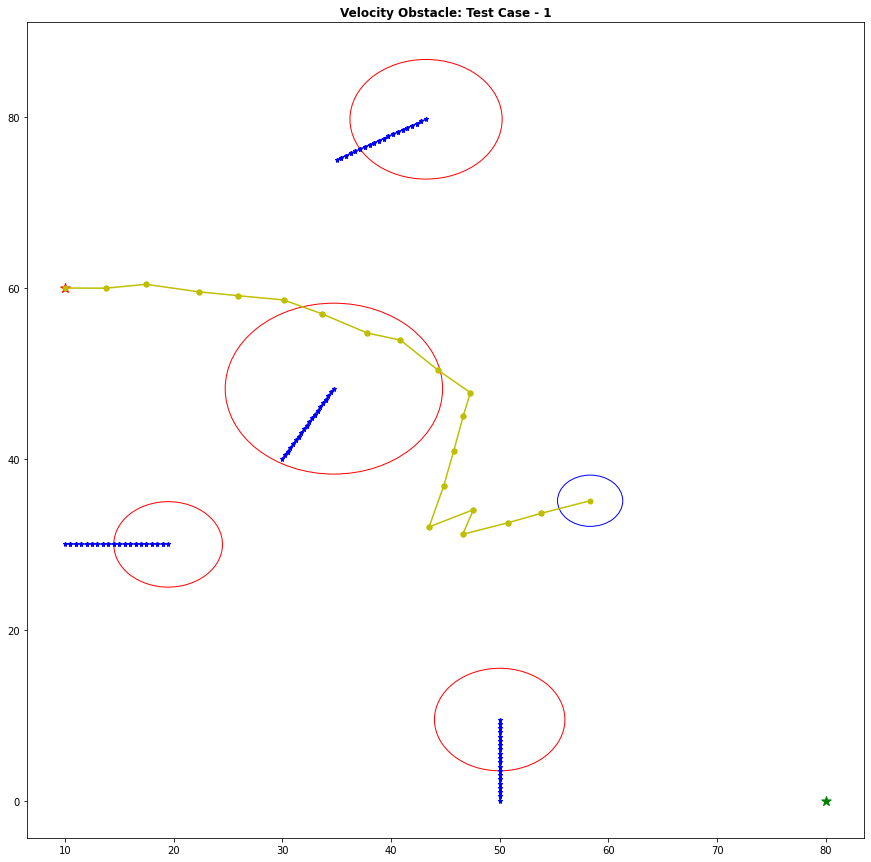

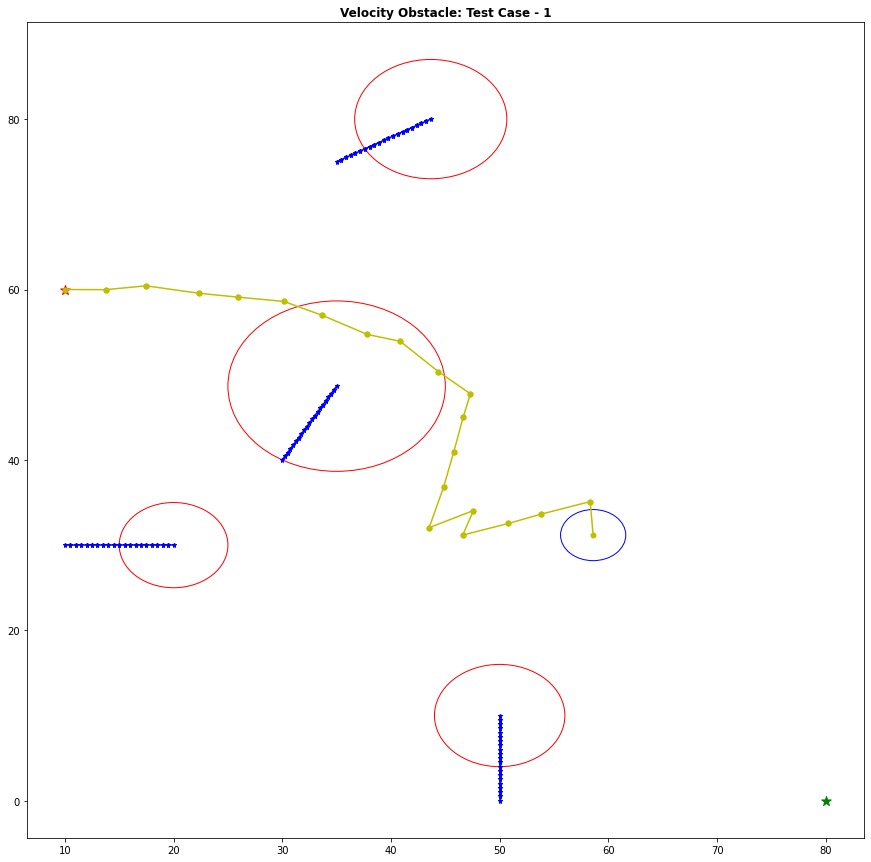

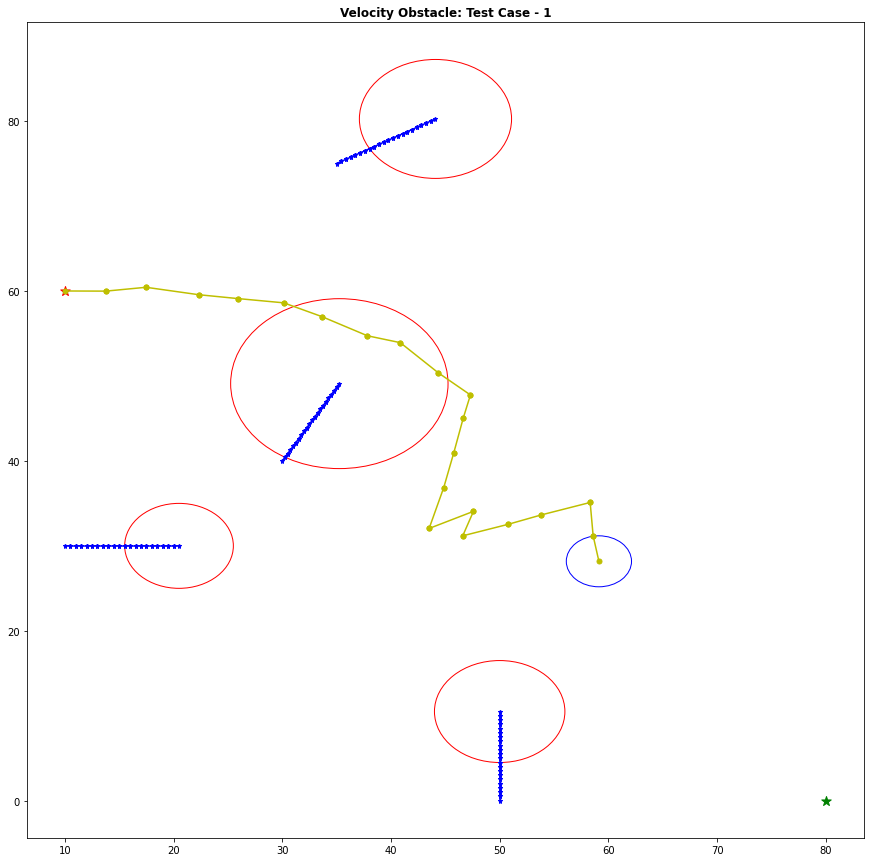

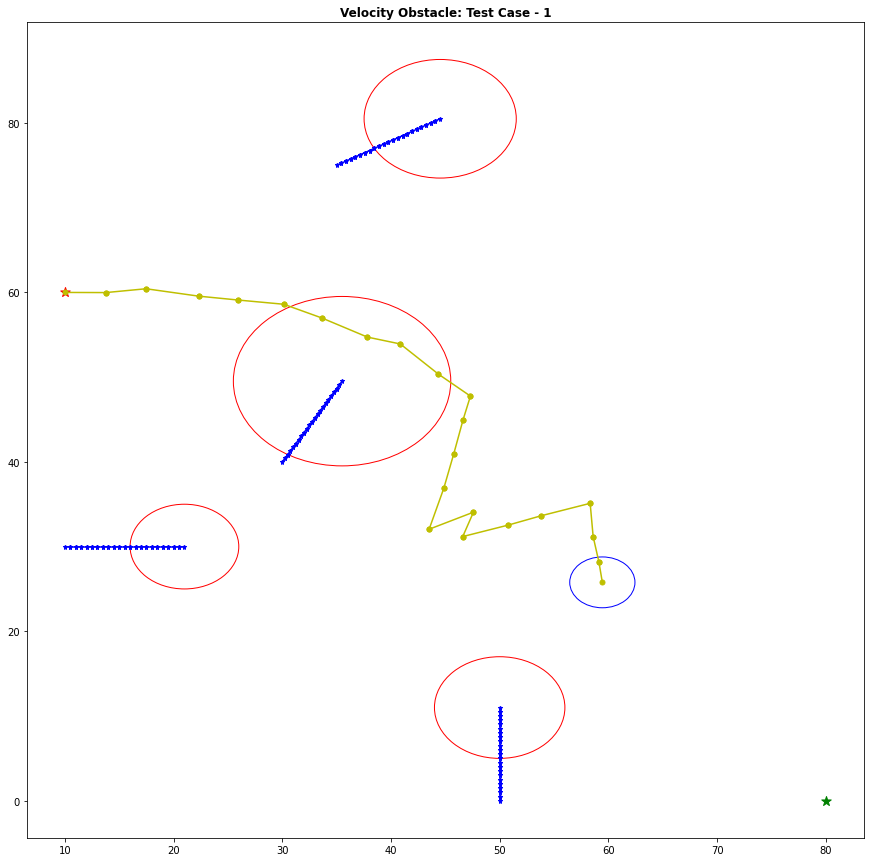

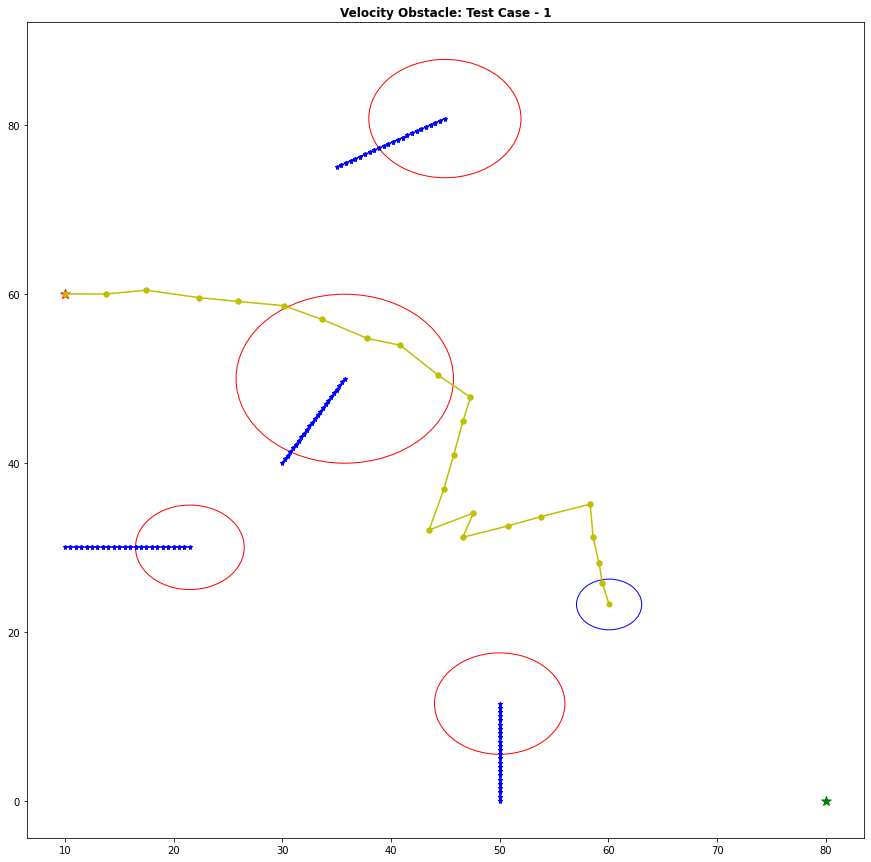

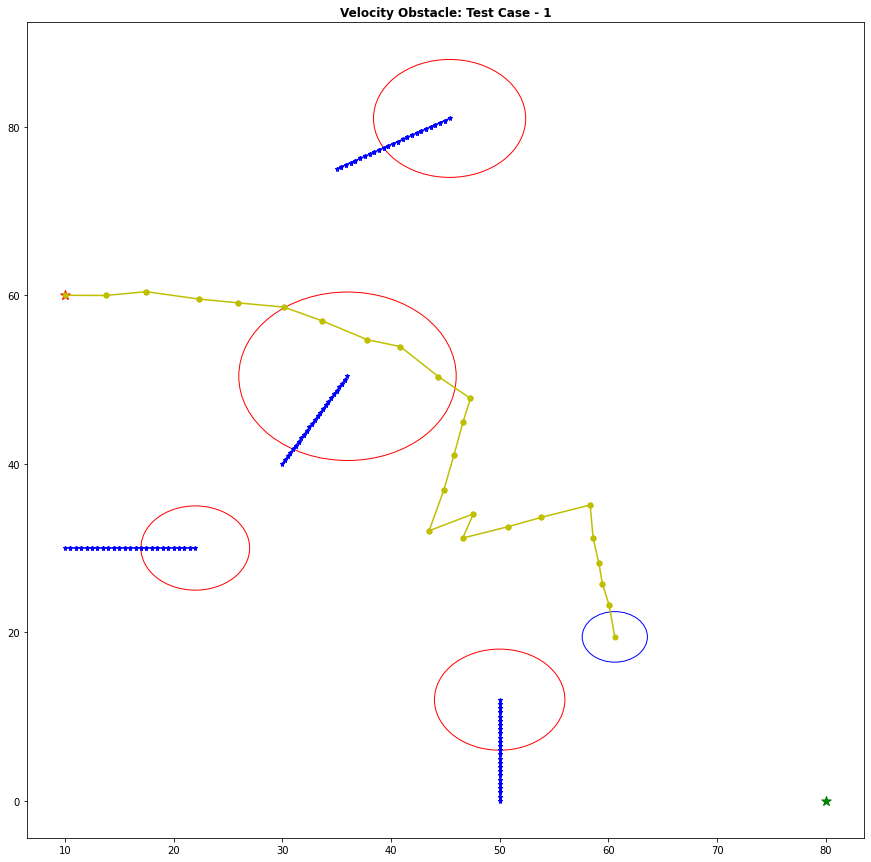

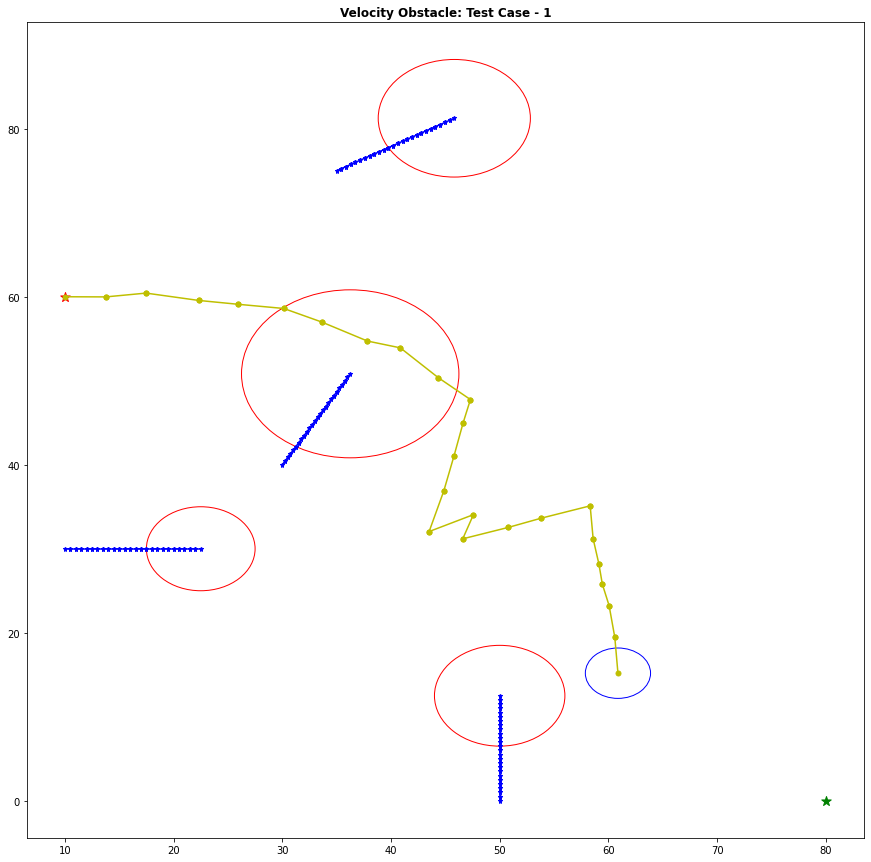

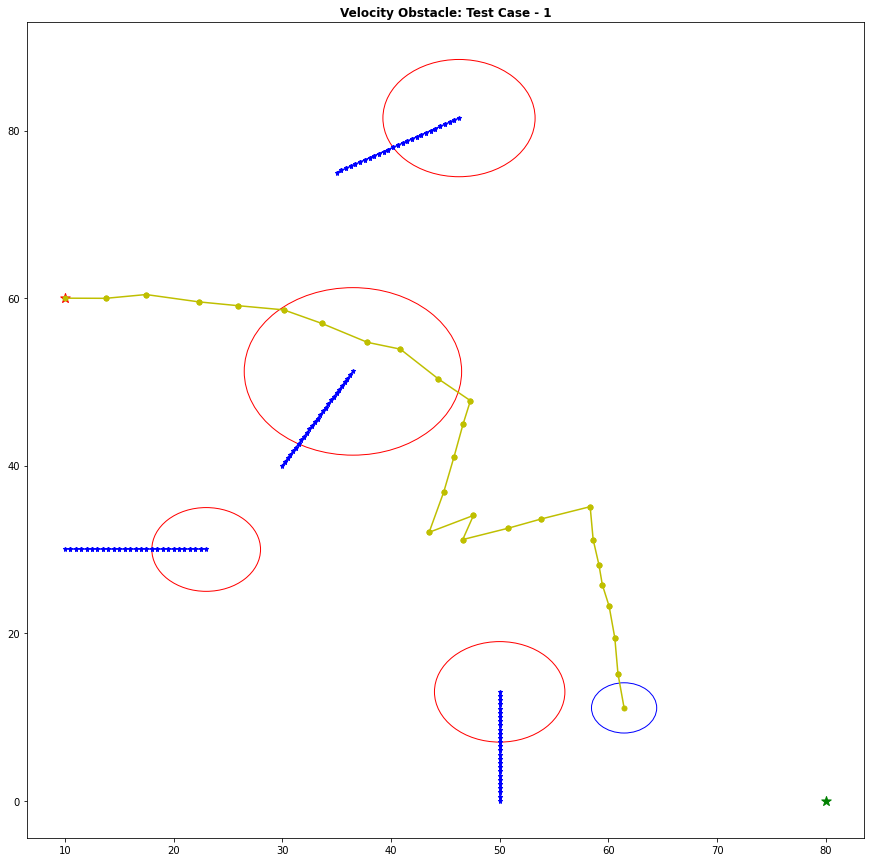

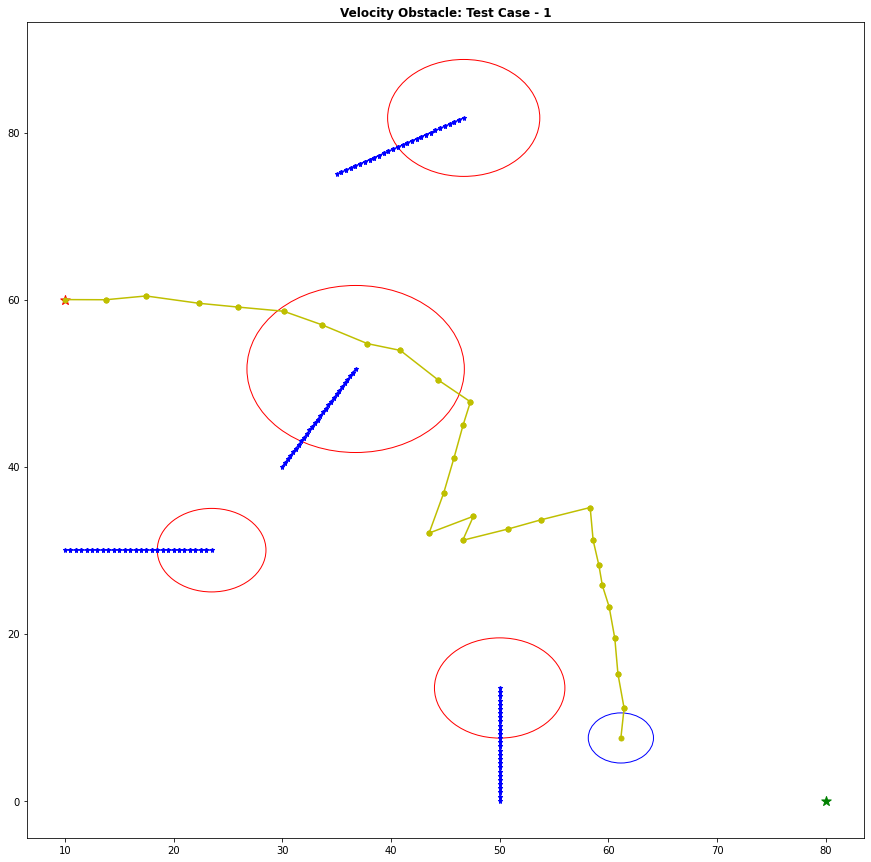

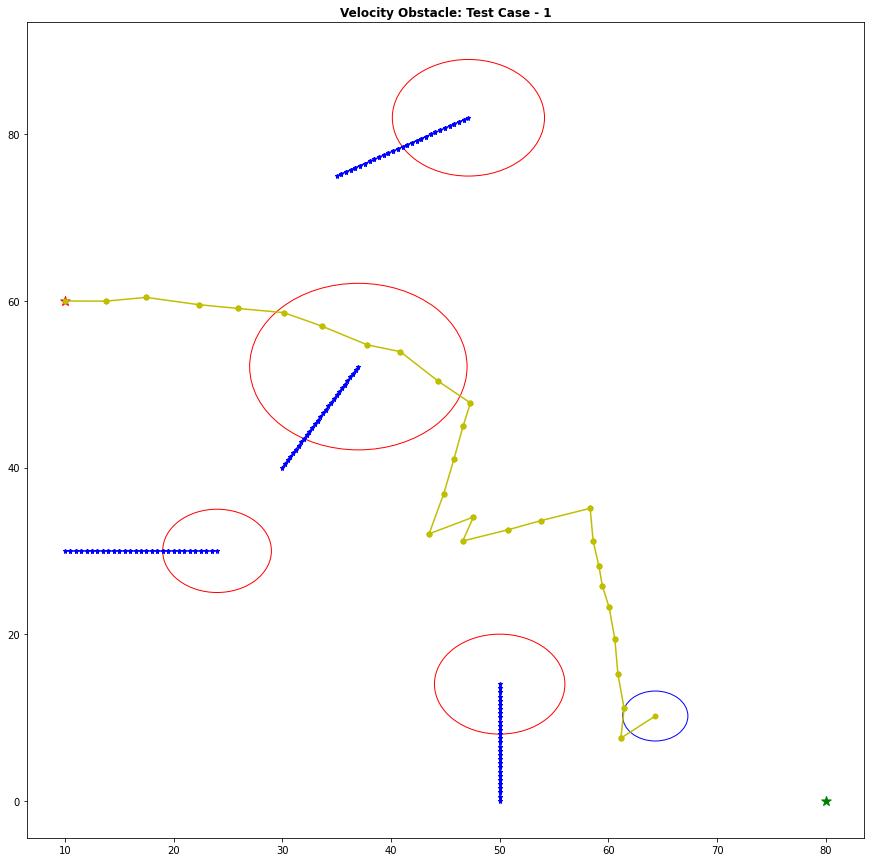

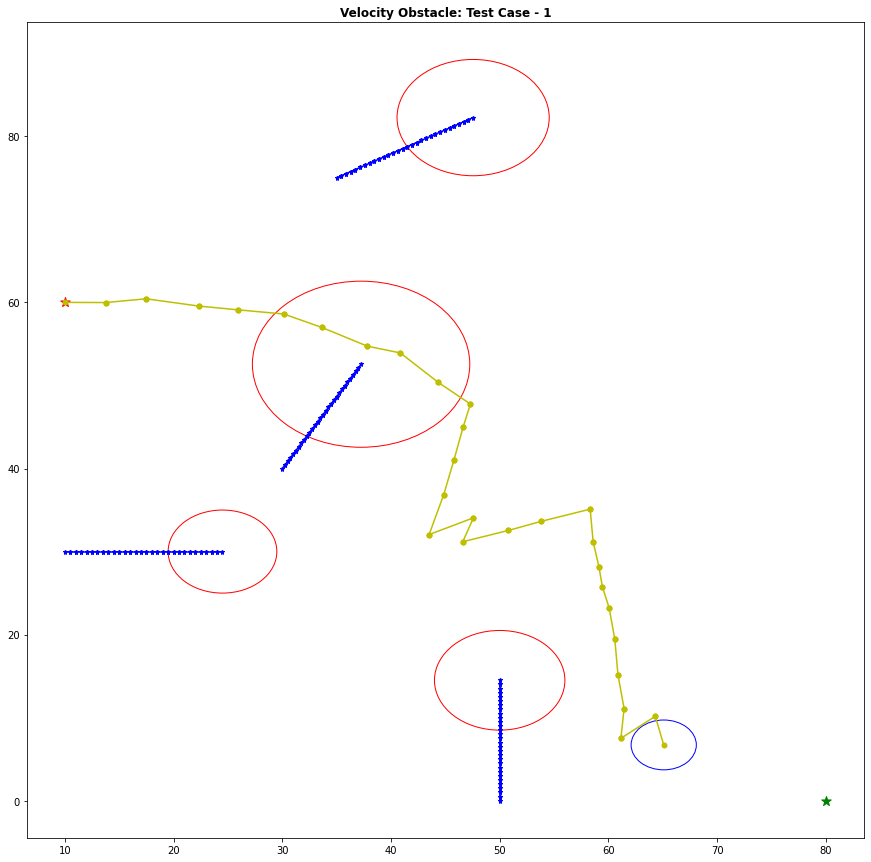

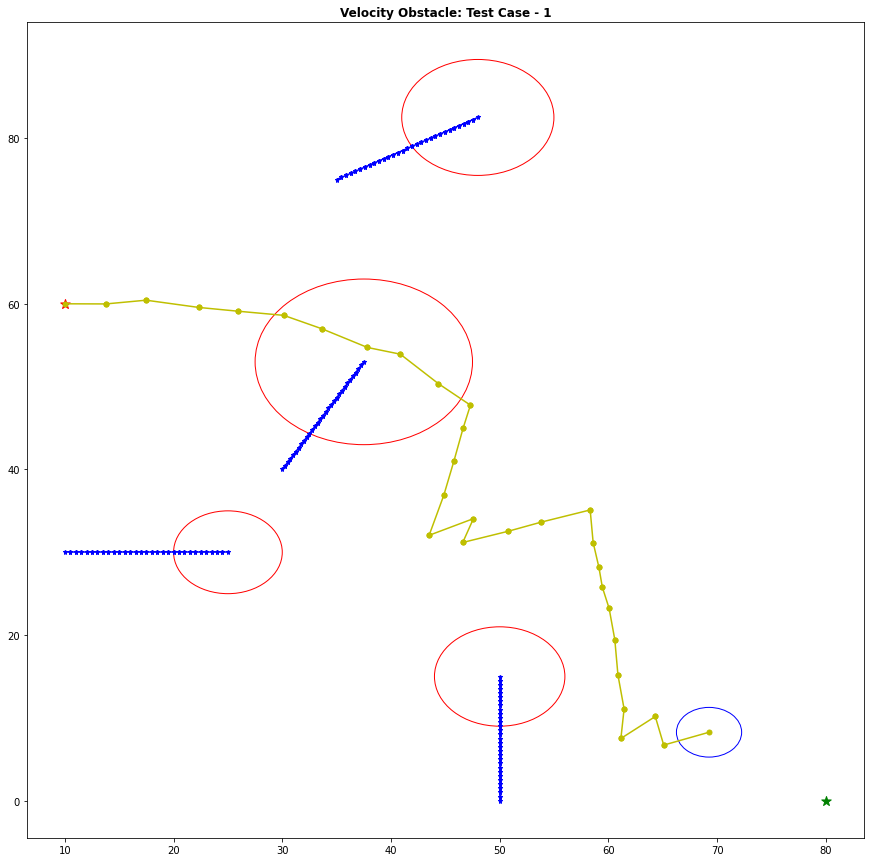

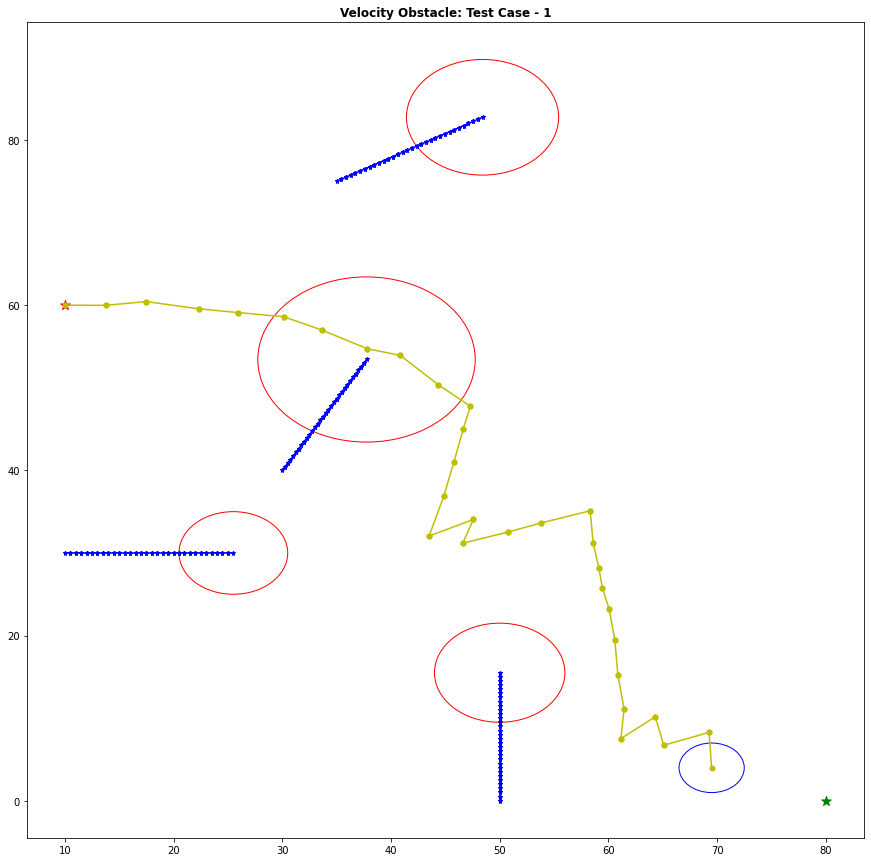

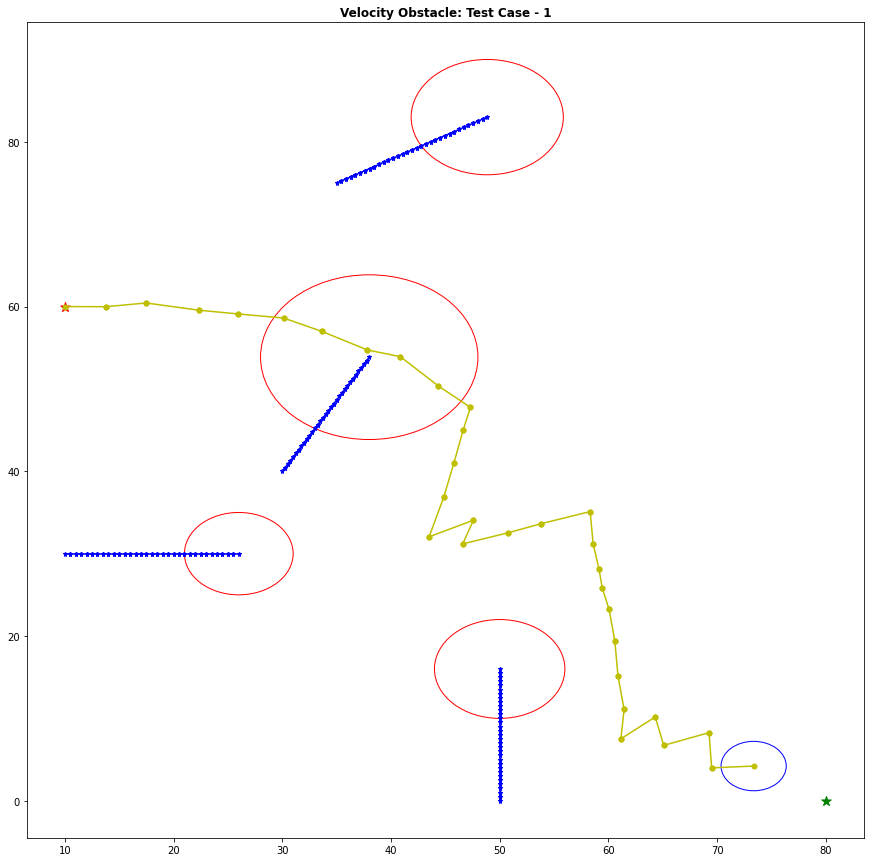

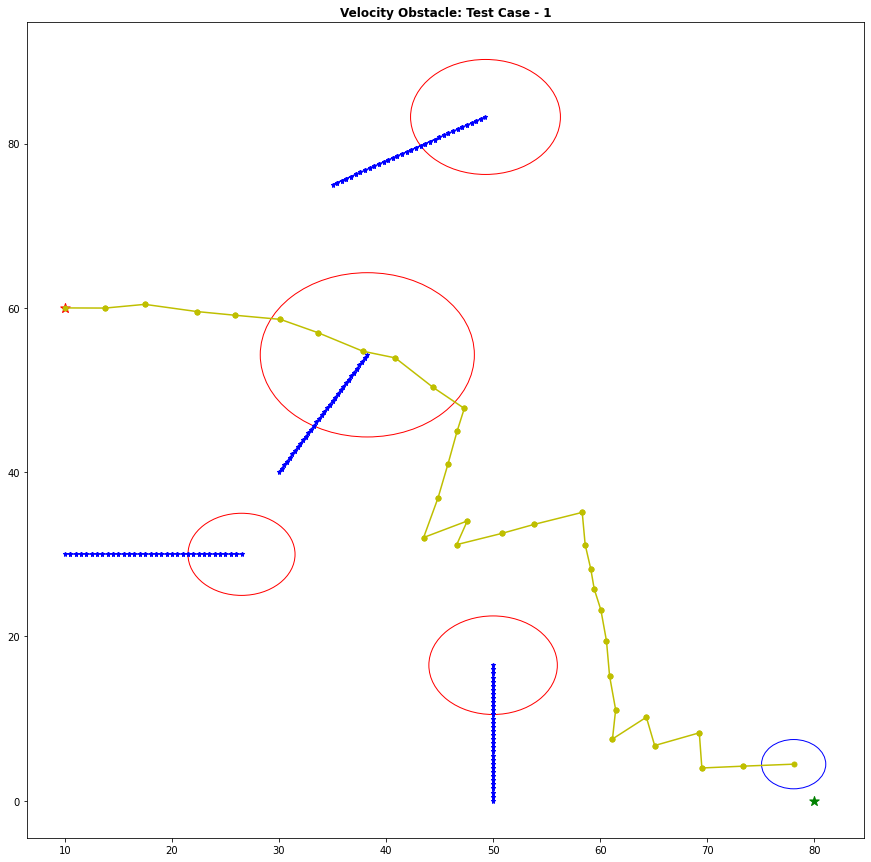

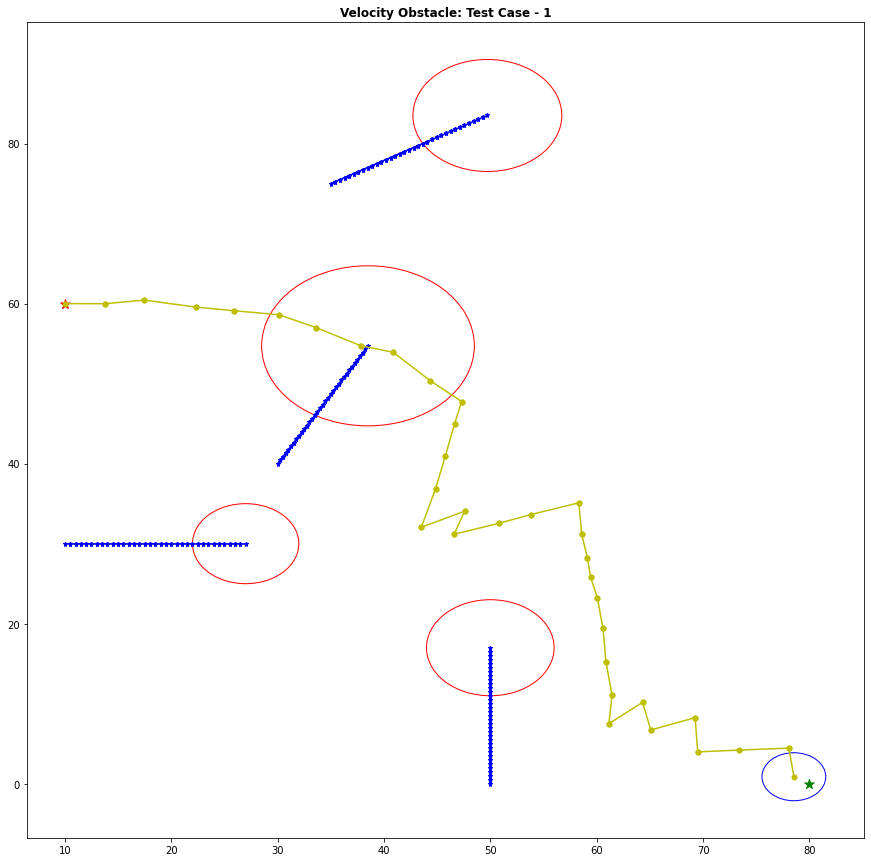

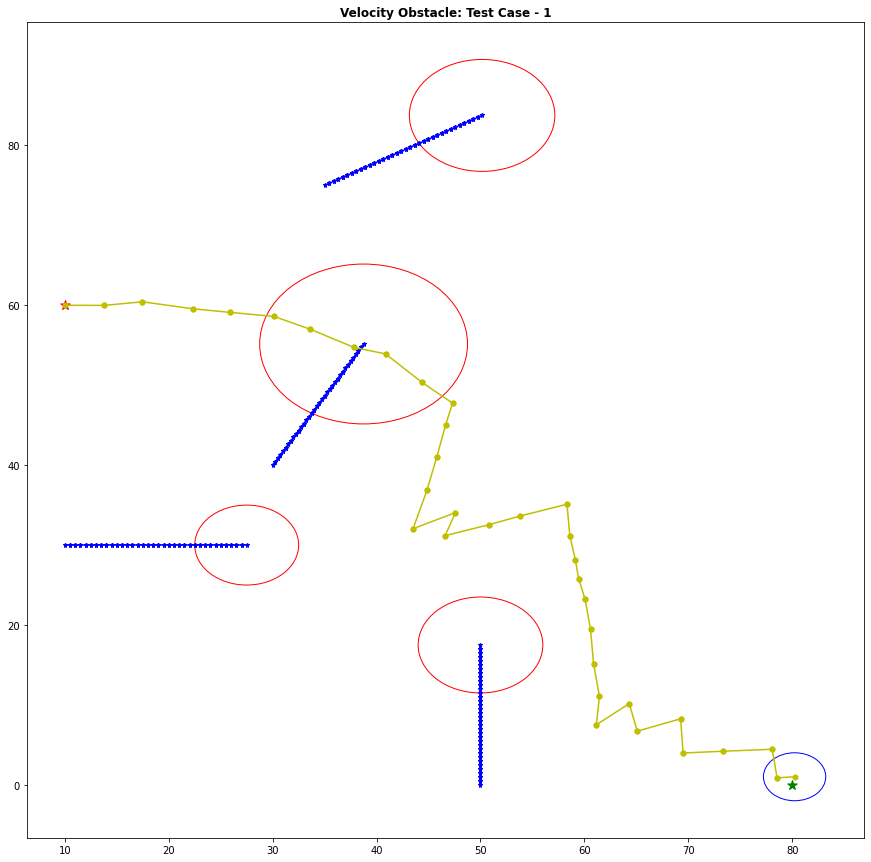

In [8]:
# define the grid dimensions
gridStartX = 0 
gridStartY = 0
gridEndX = 150
gridEndY = 150

# define robot and time parameters
maxVel = 5
robotRadius = 3
dt = 1

# set the start and goal nodes
start = Point(10, 60)   
goal = Point(80, 0)

# define the robot and obstacles
robot = Robot(start.get_x(), start.get_y(), robotRadius, maxVel)
obstacles = [   Obstacle(35, 75, 7, 0.5, np.pi/6),
                Obstacle(30, 40, 10, 0.5, np.pi/3),
                Obstacle(10, 30, 5 , 0.5, 0),
                Obstacle(50, 0, 6 , 0.5, np.pi/2) ]

# define the environment
env = Env(gridStartX, gridEndX, gridStartY, gridEndY, start, goal)
env.add_title('Velocity Obstacle: Test Case - 1')

# compute the trajectory
VO_traj = VOTrajectory(env, start, goal, robot, obstacles, dt)
VO_traj.engine()


### Test Case: 2

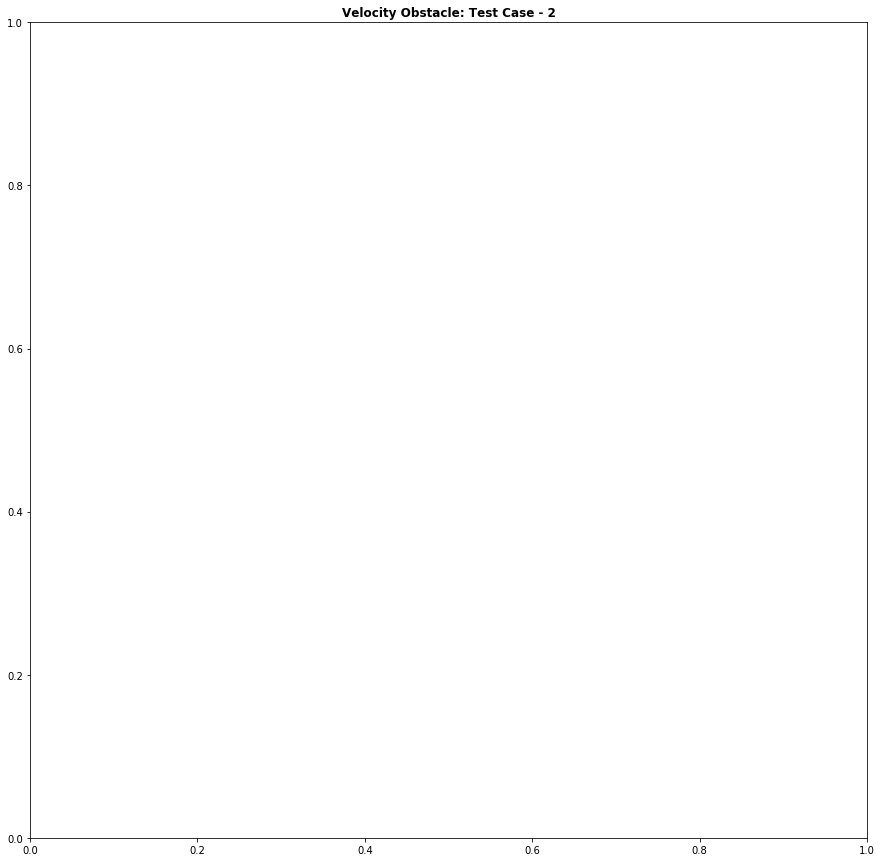

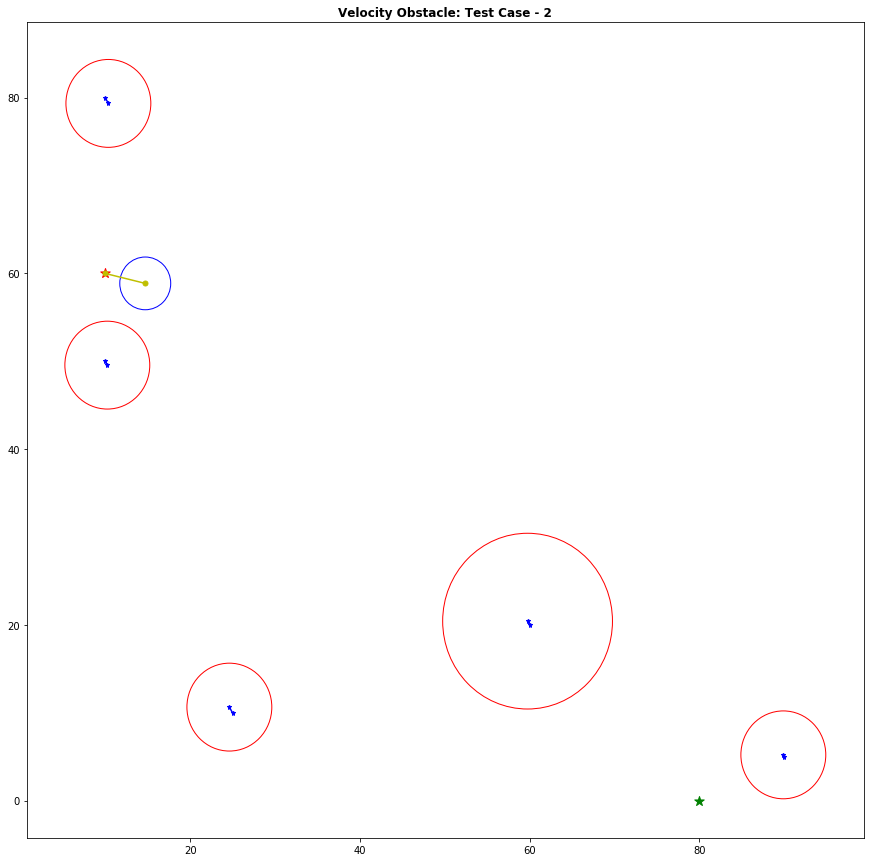

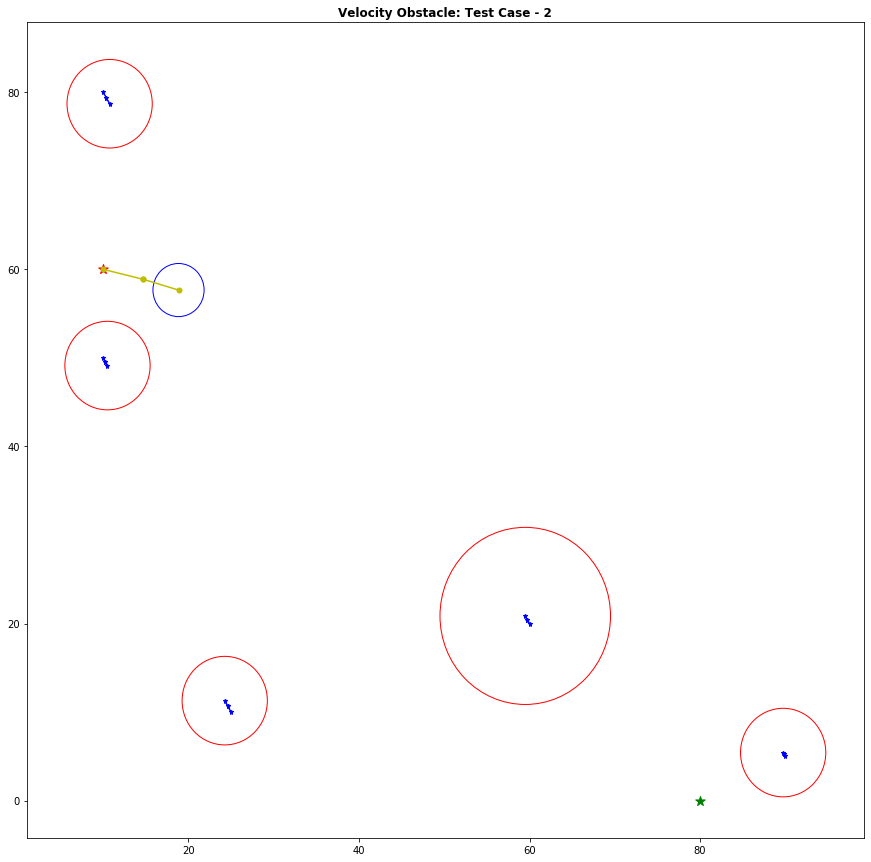

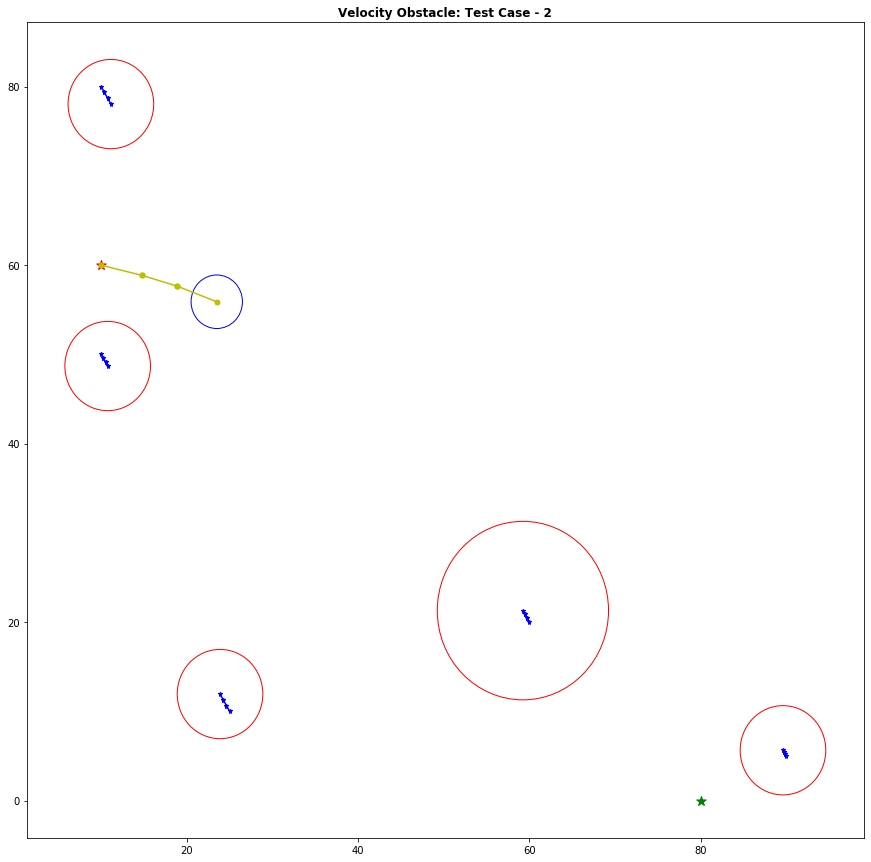

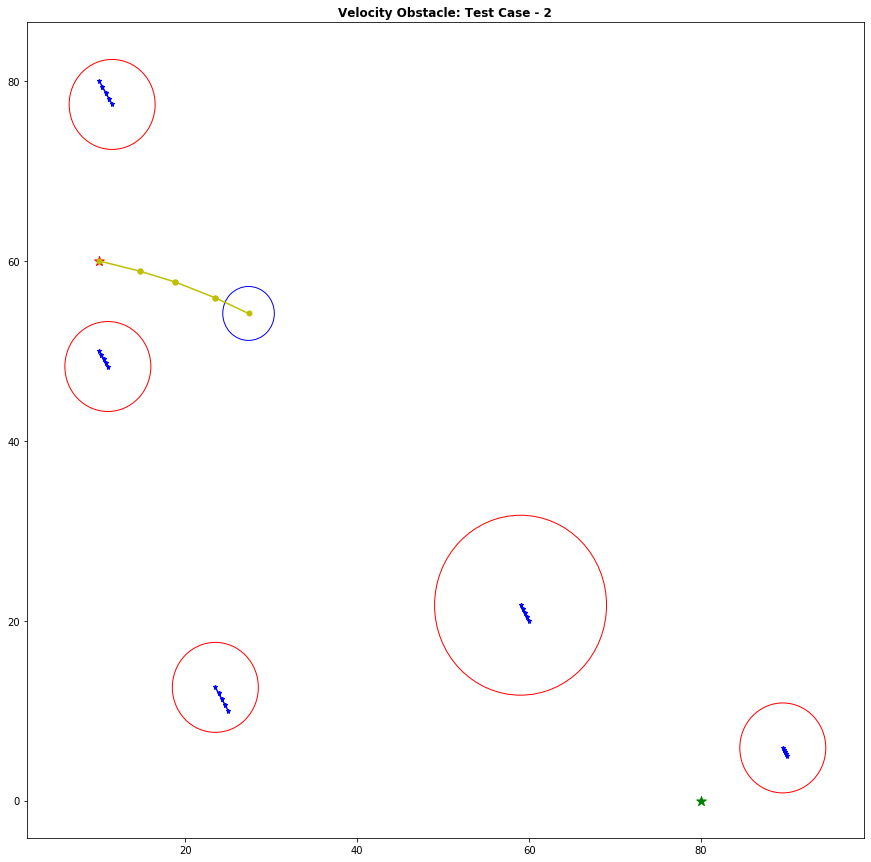

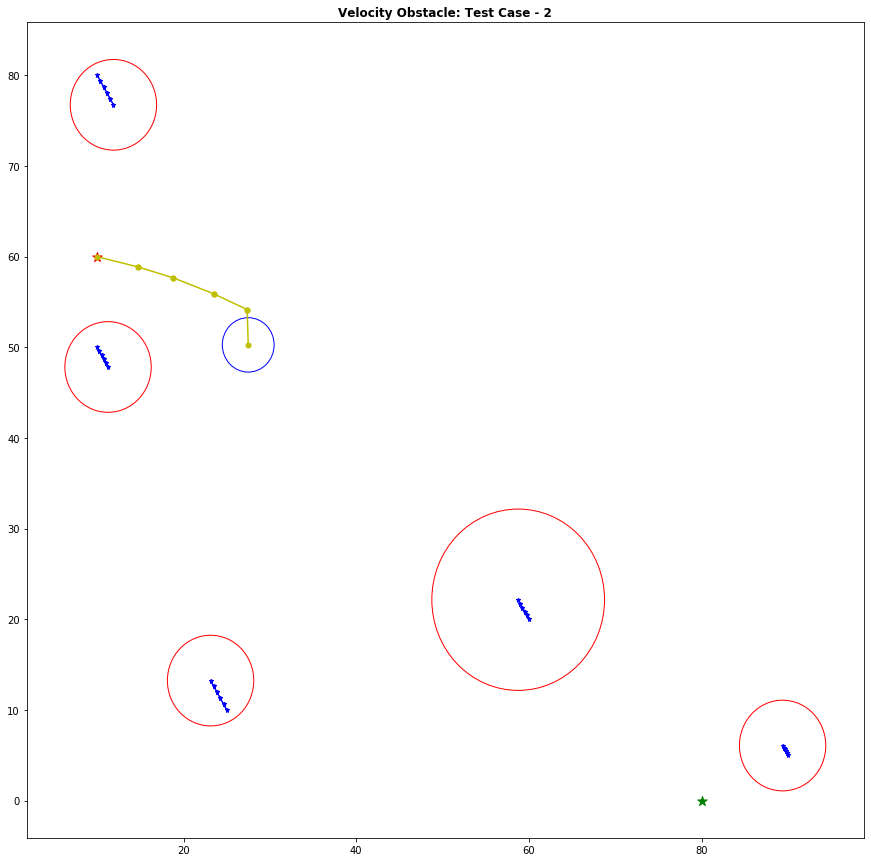

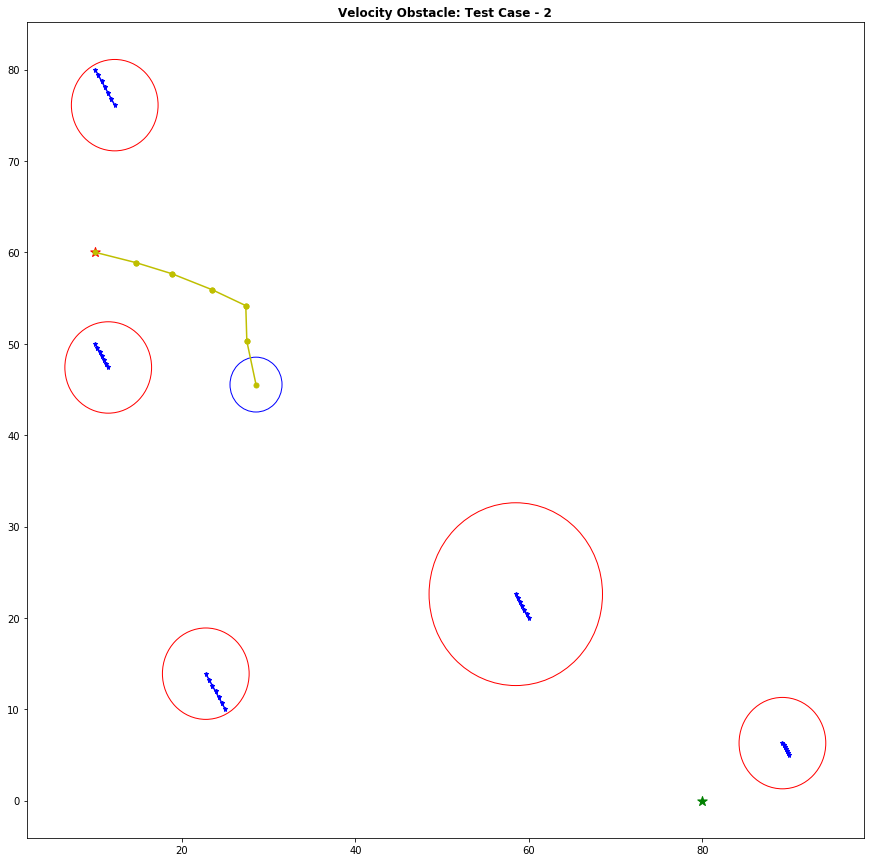

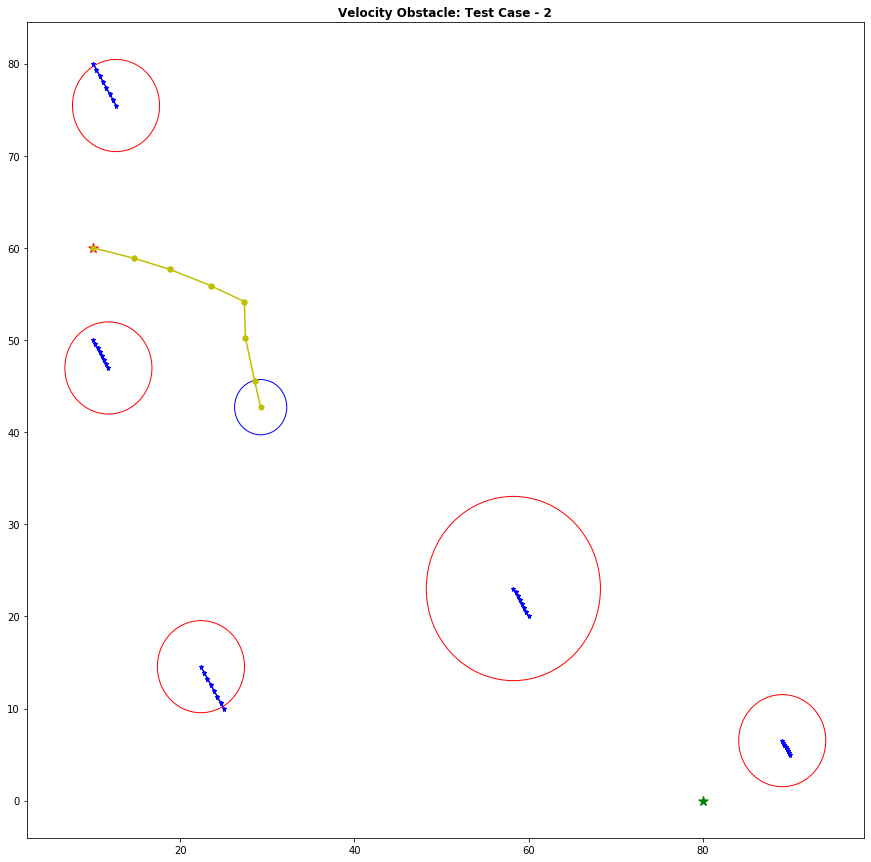

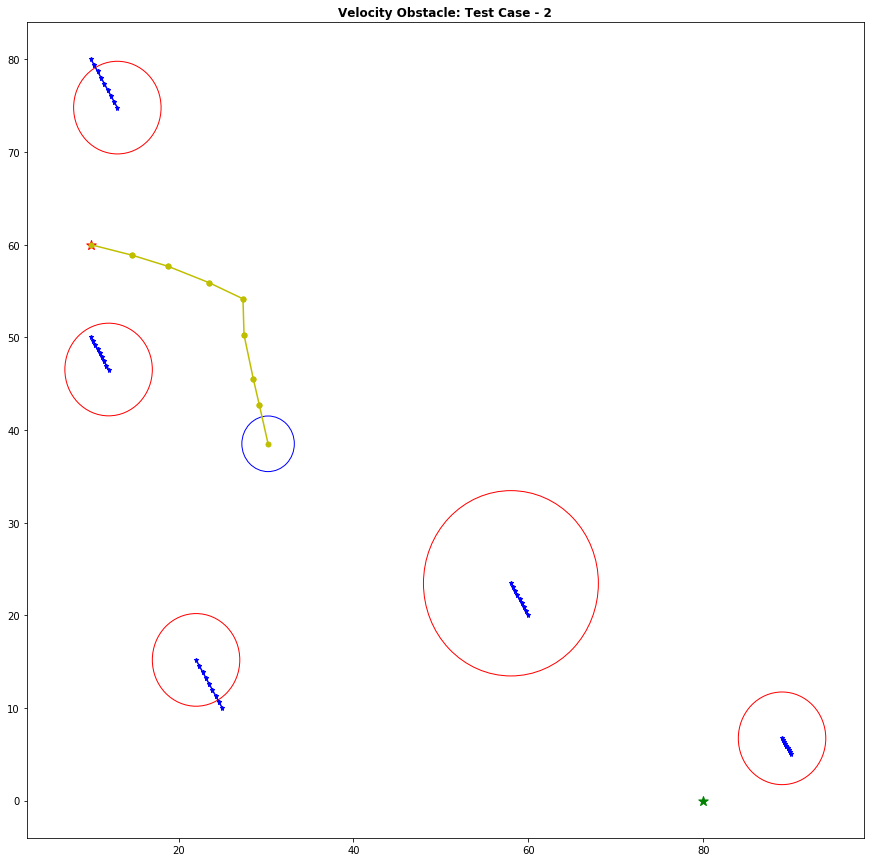

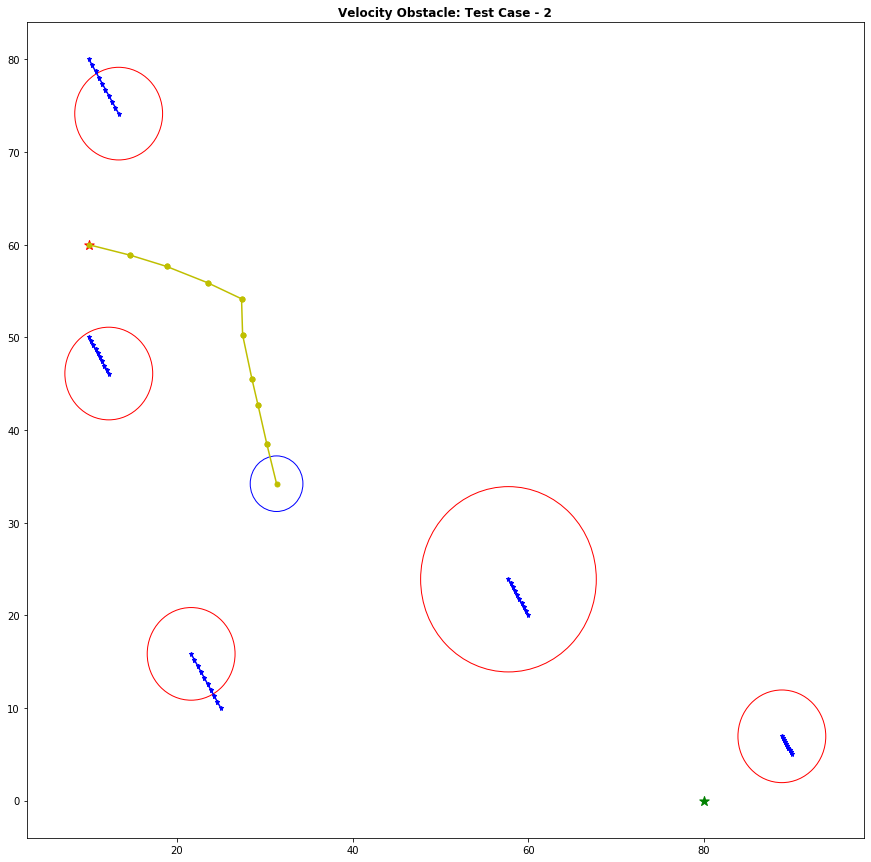

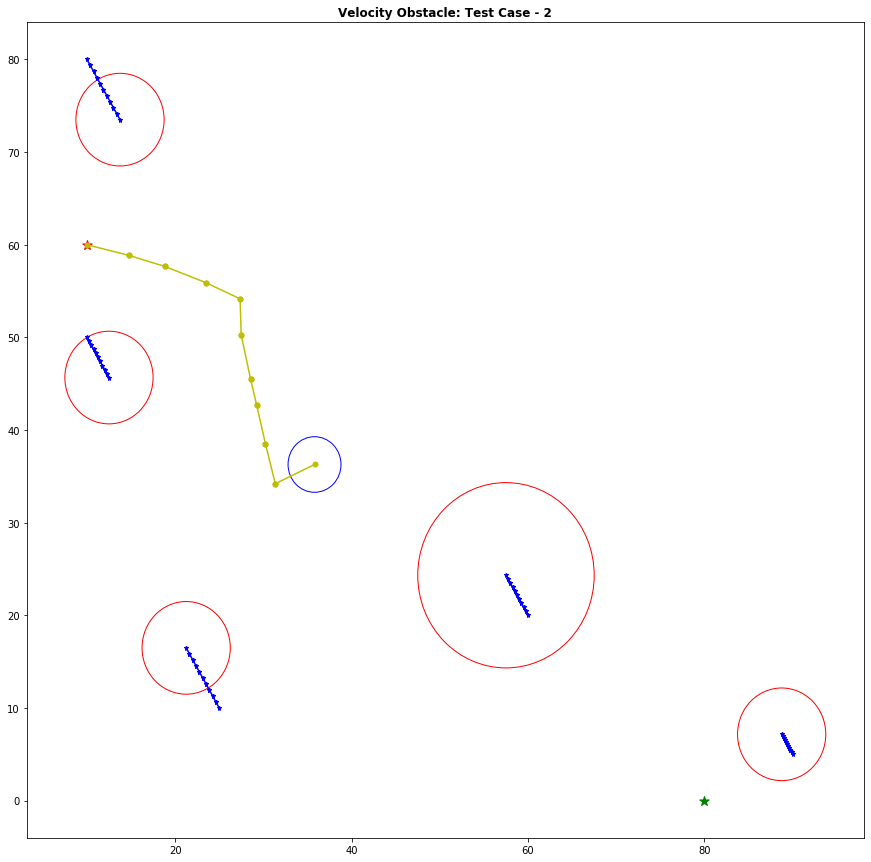

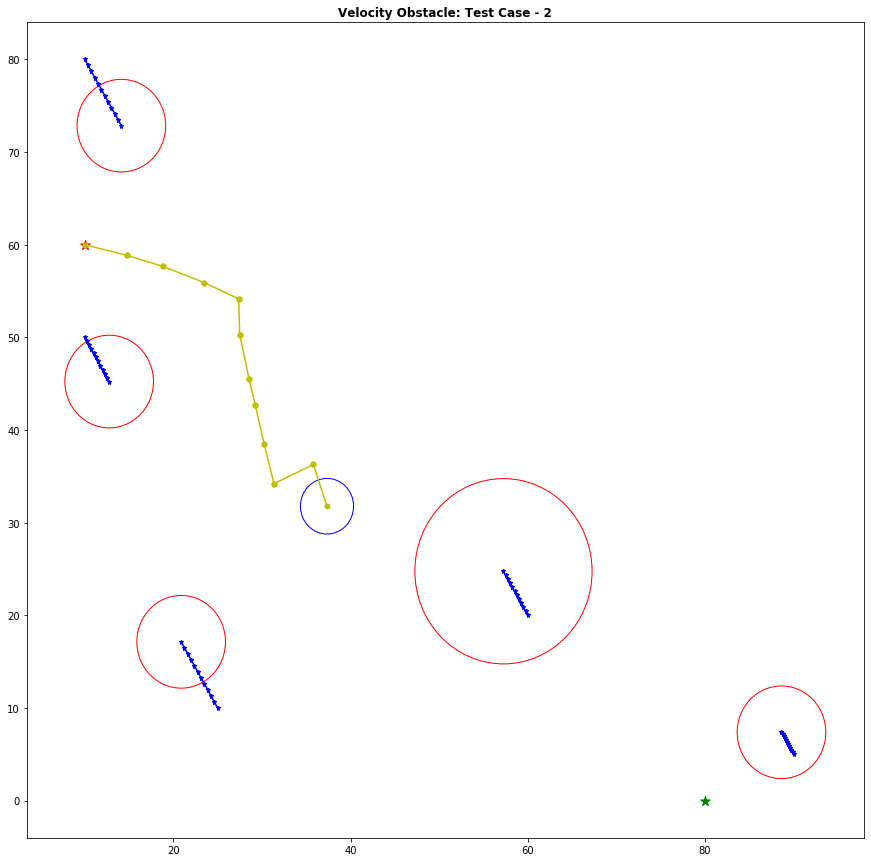

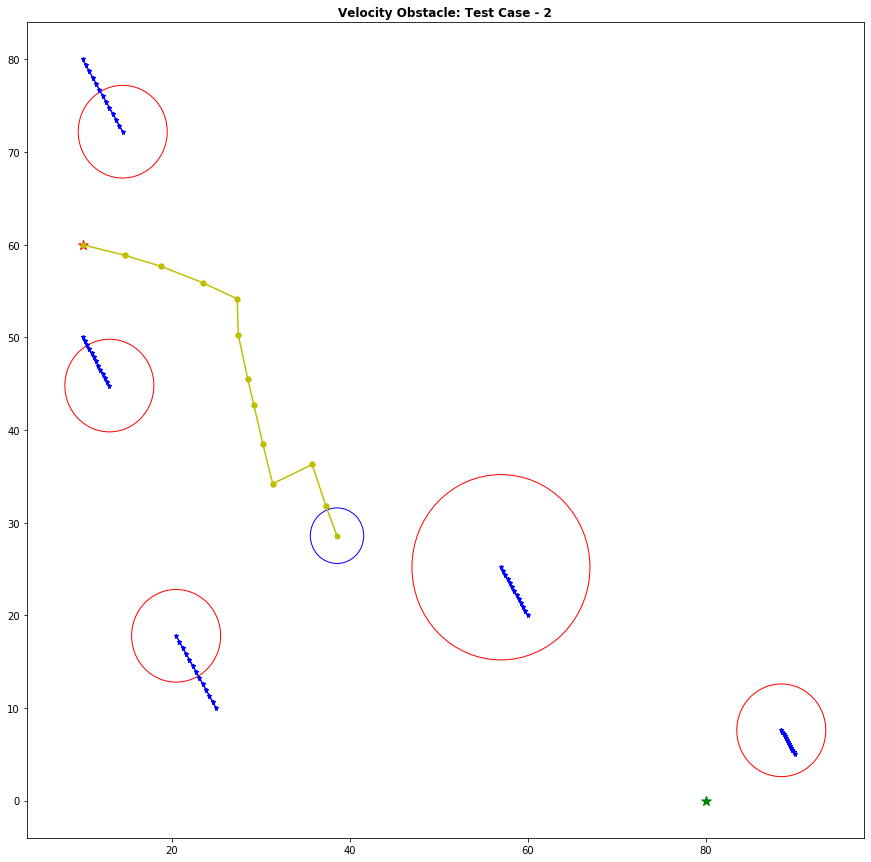

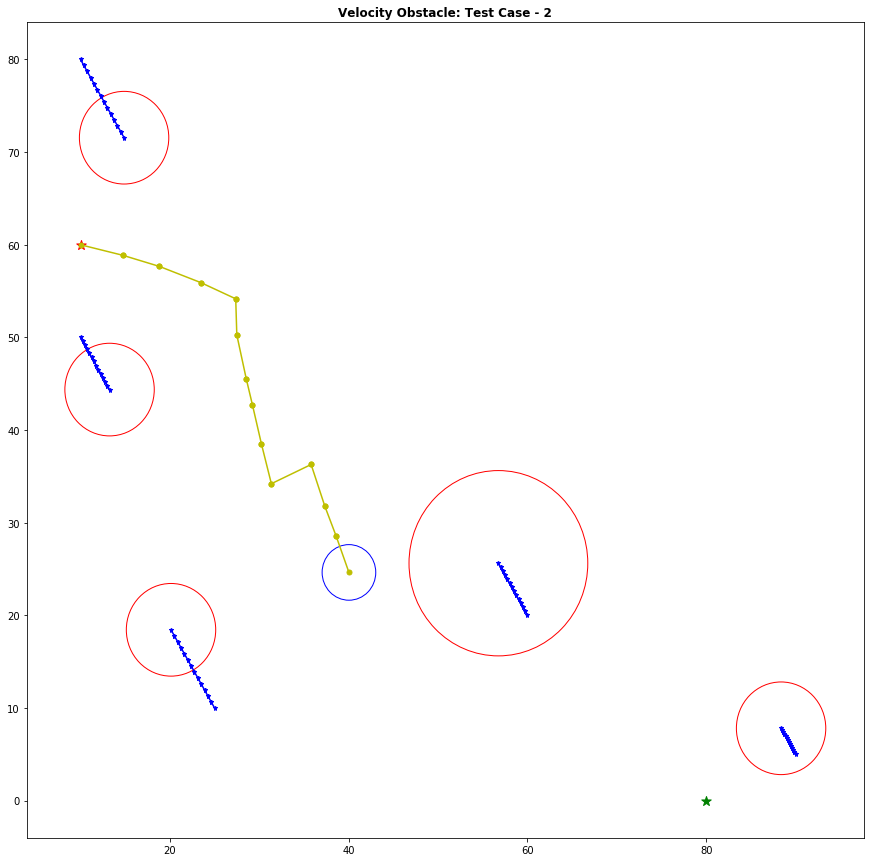

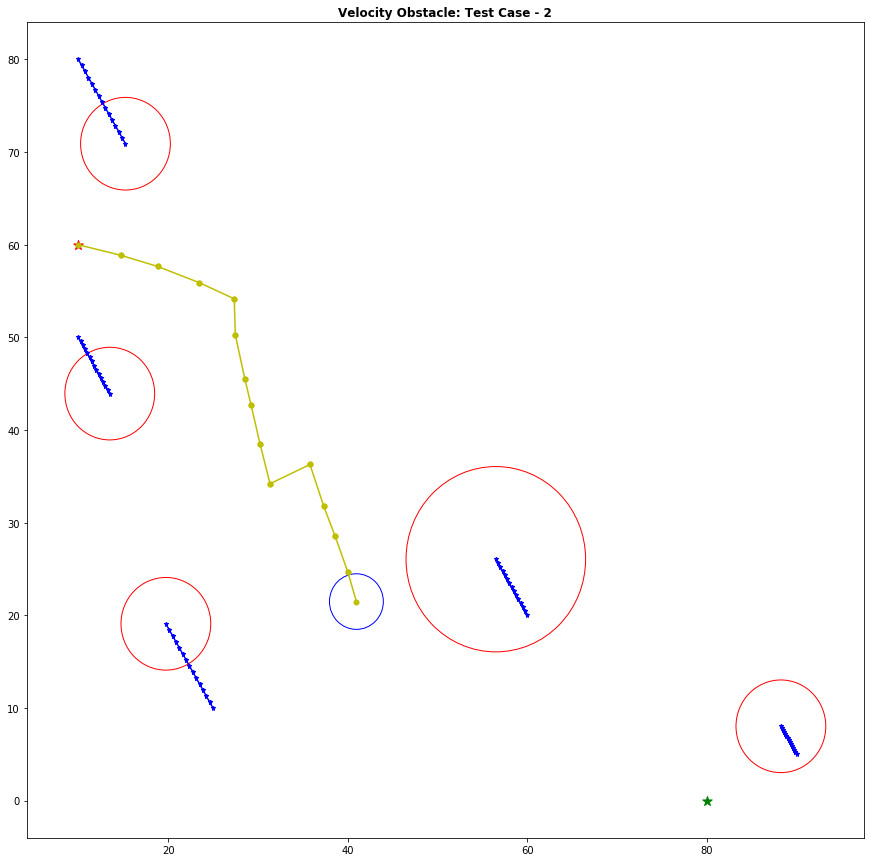

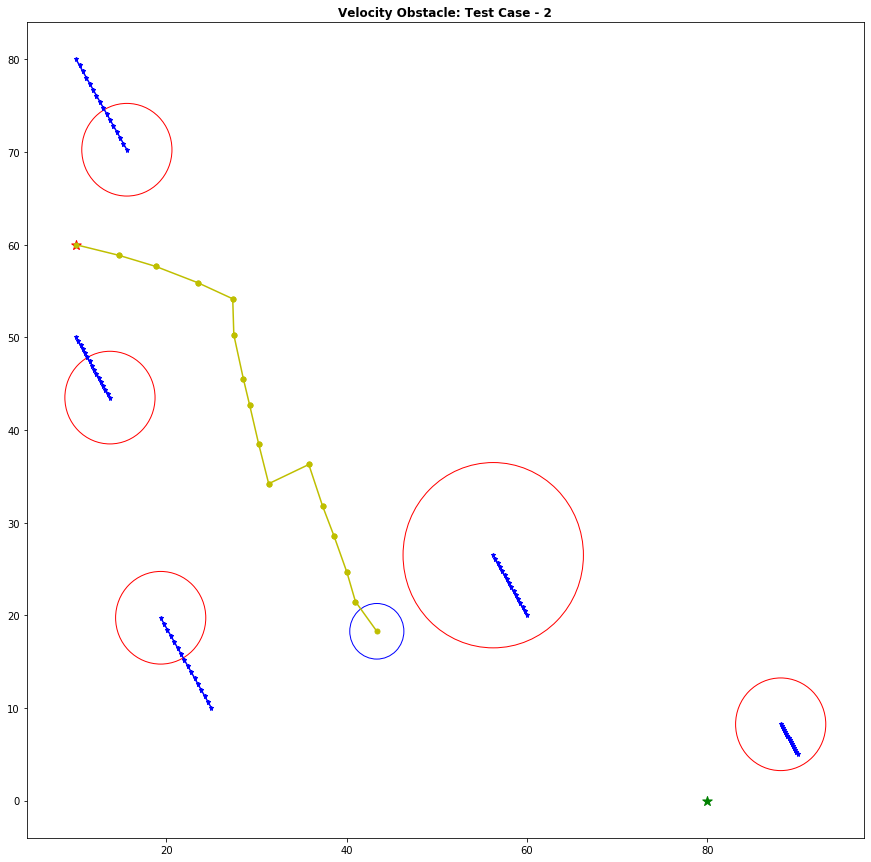

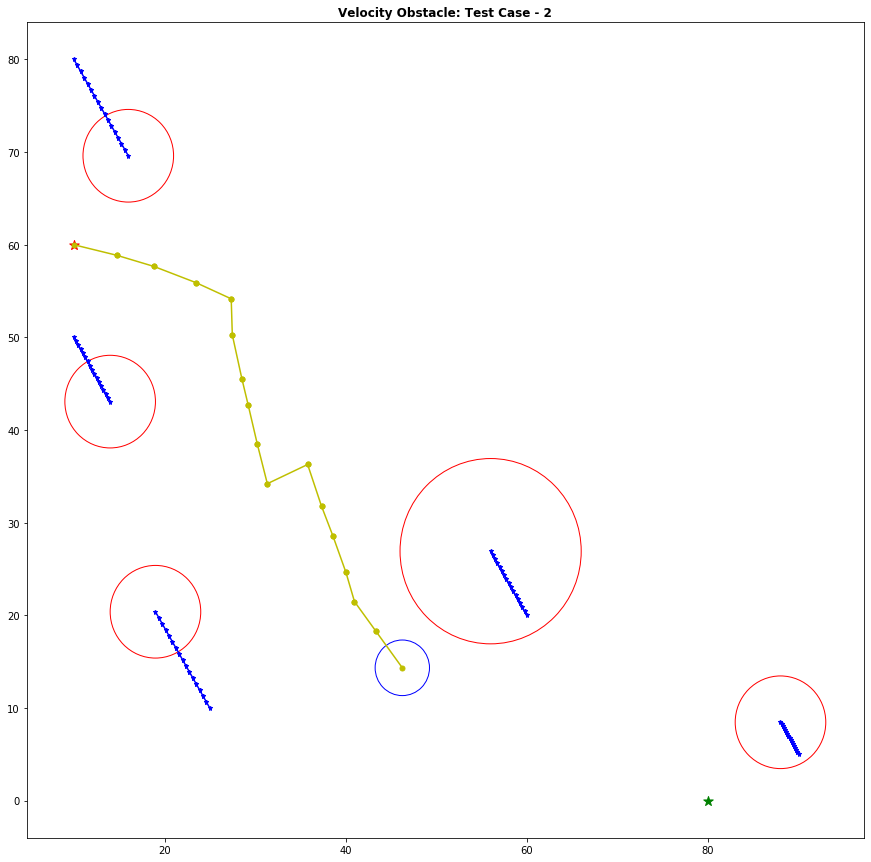

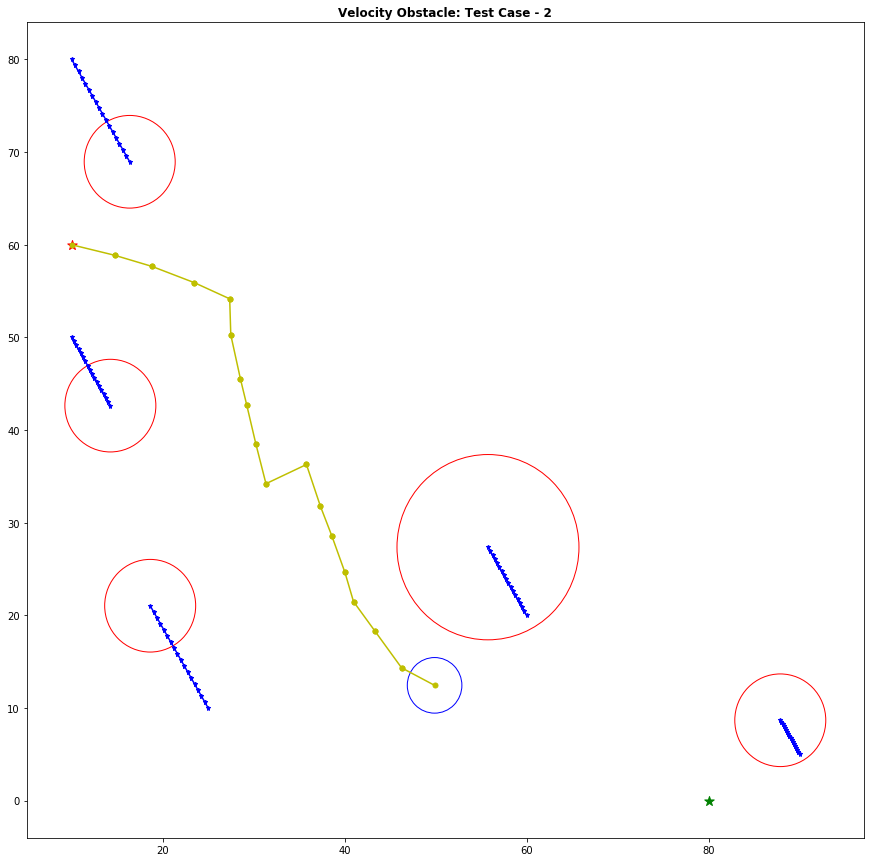

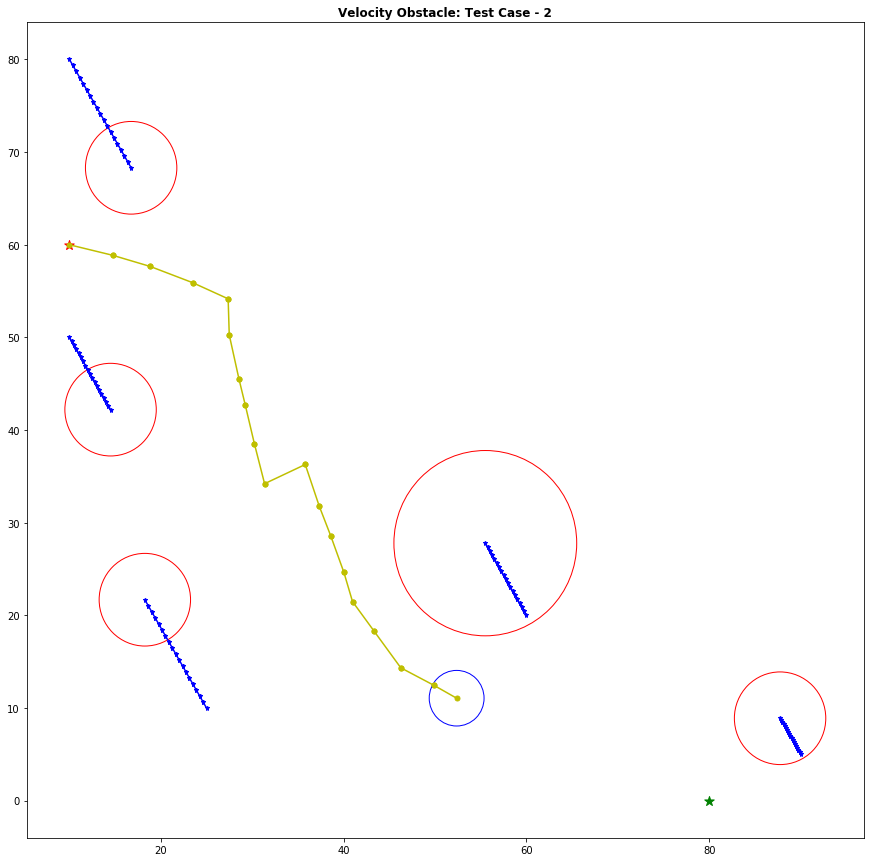

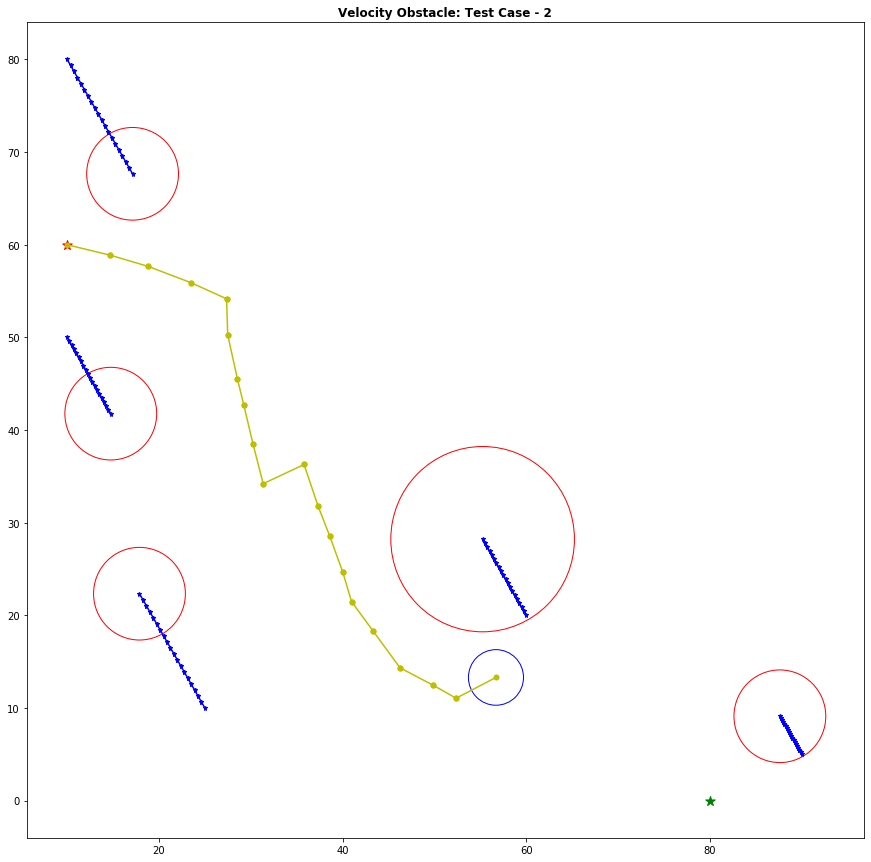

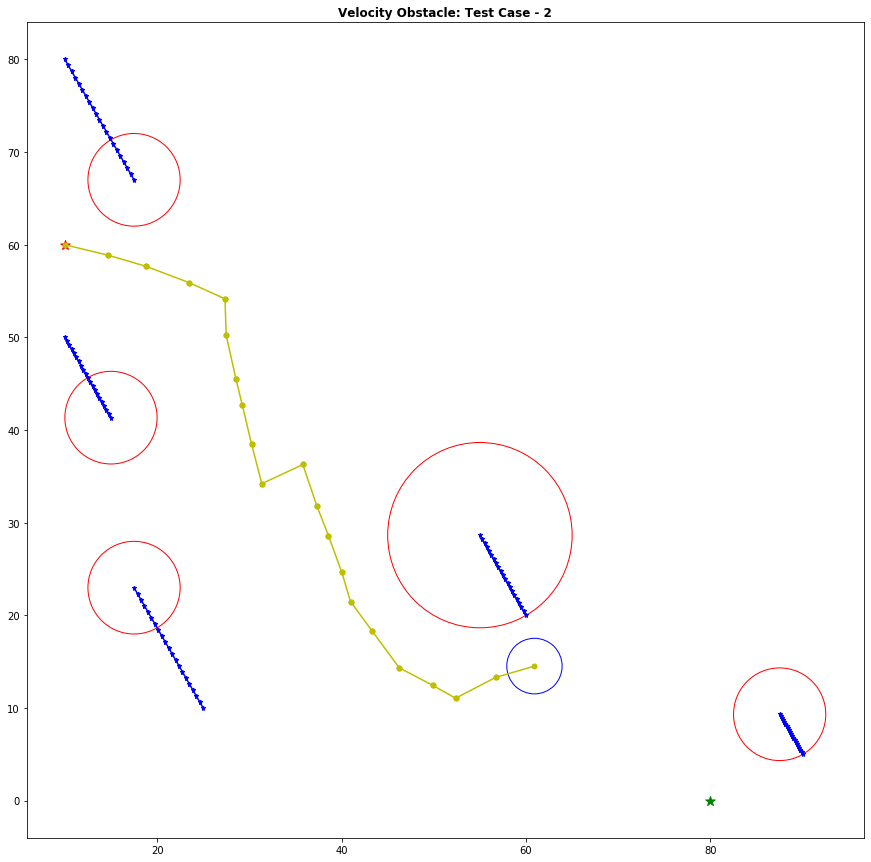

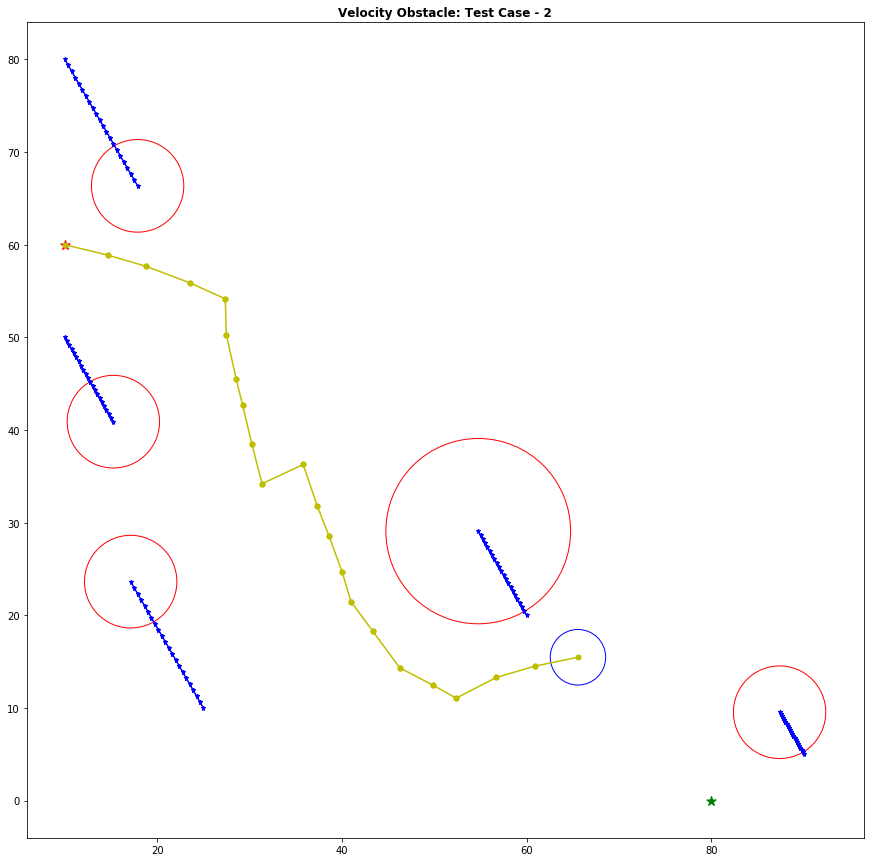

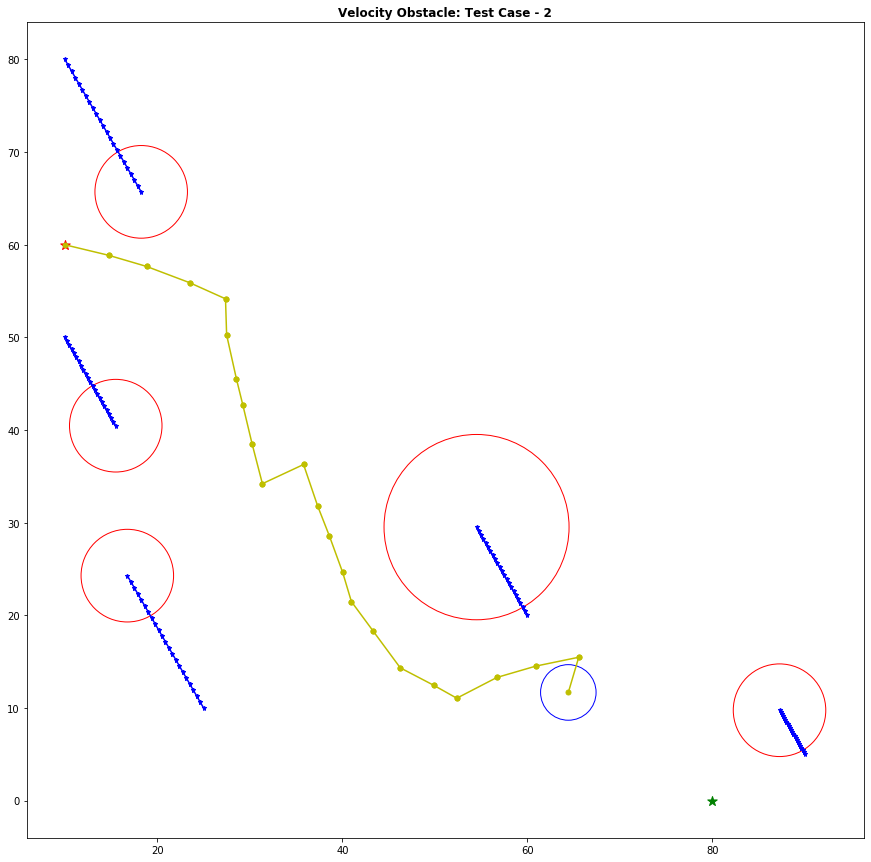

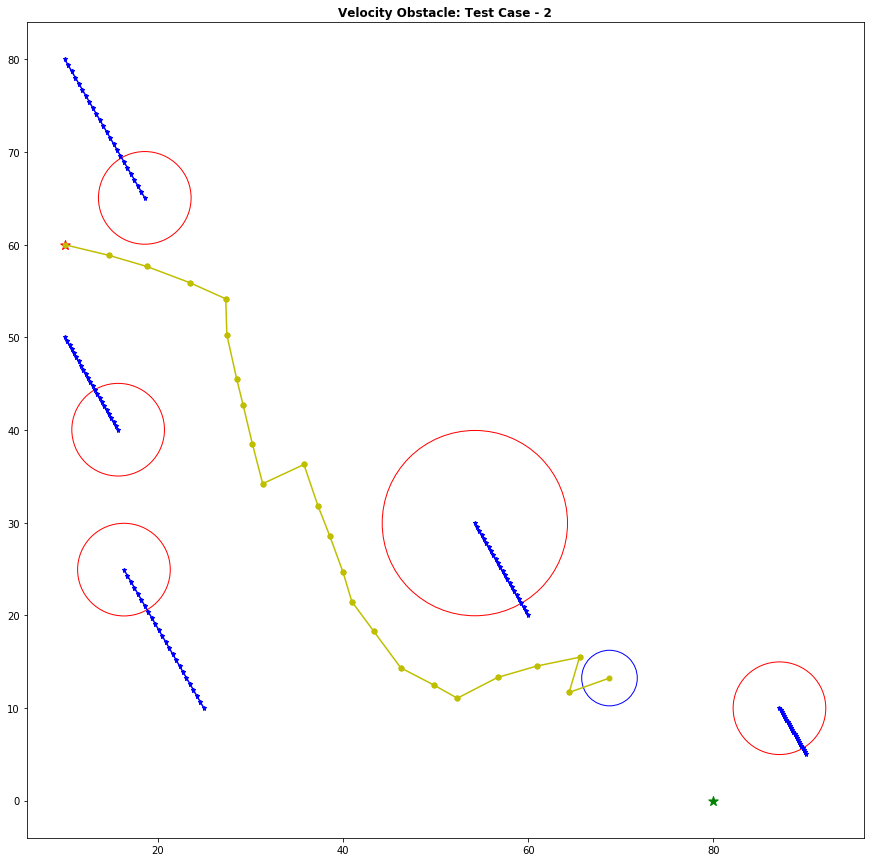

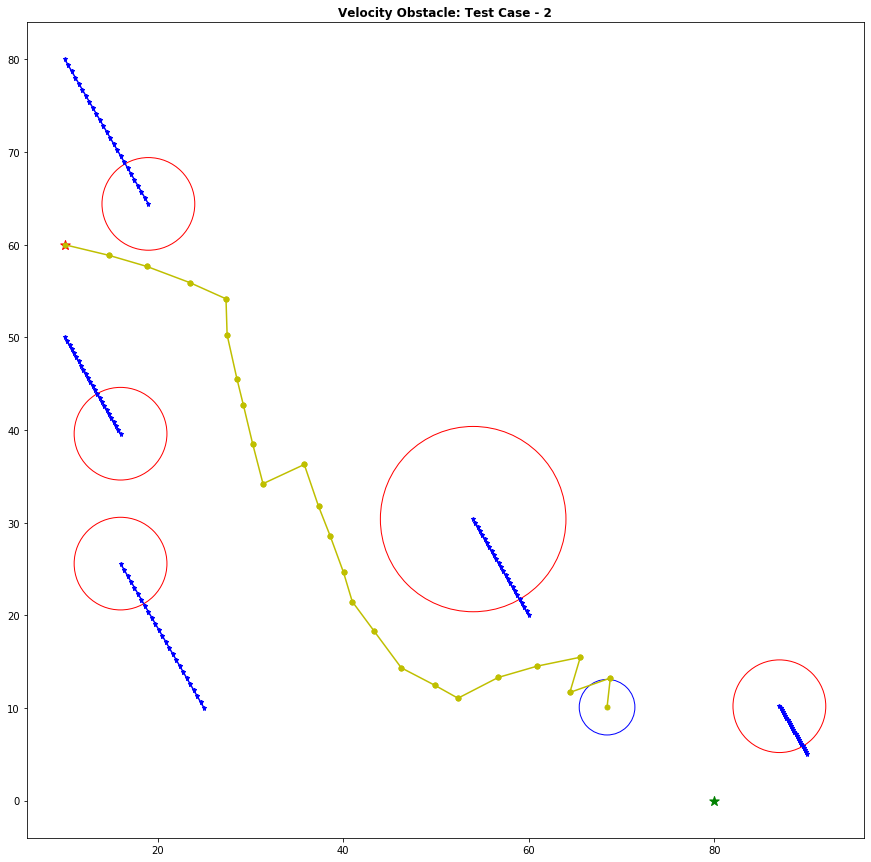

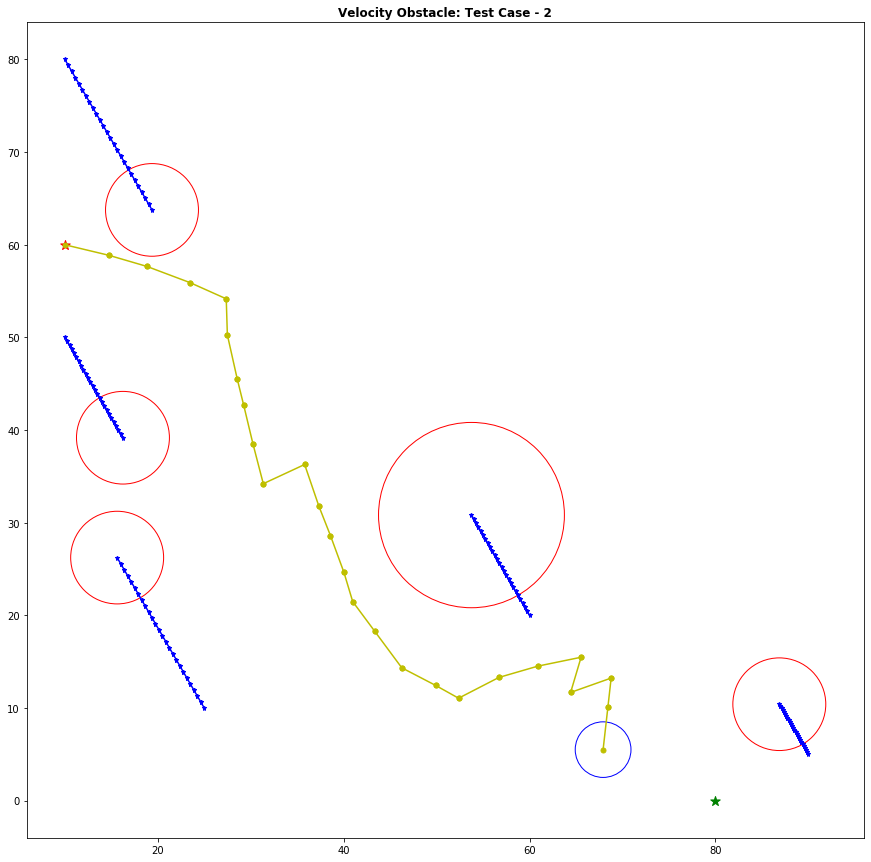

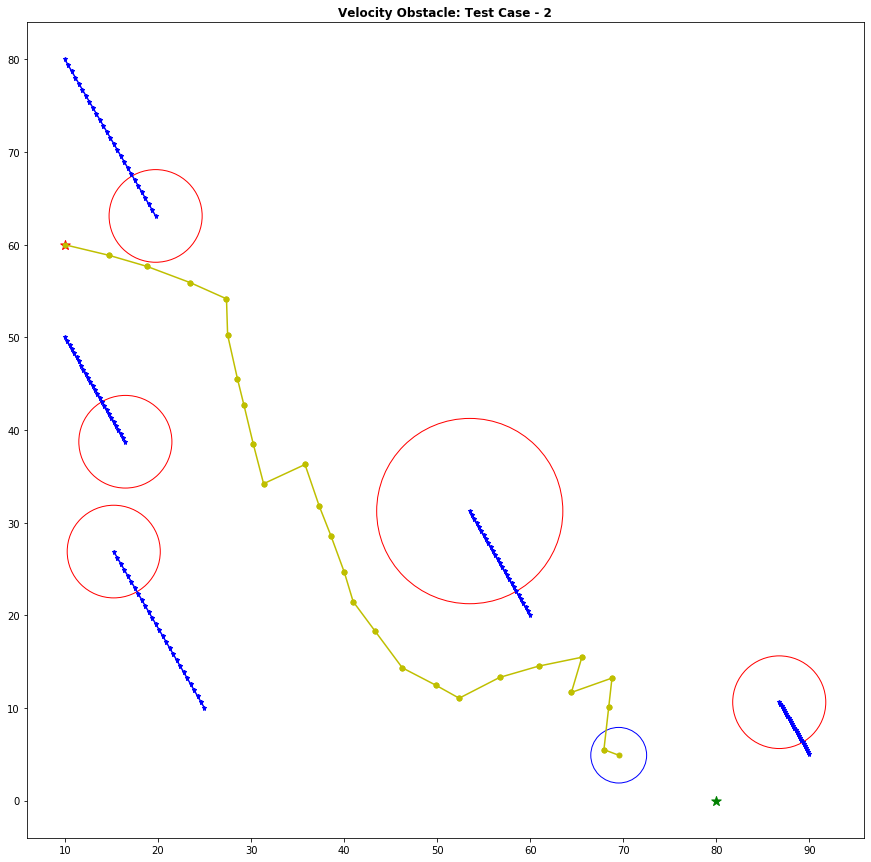

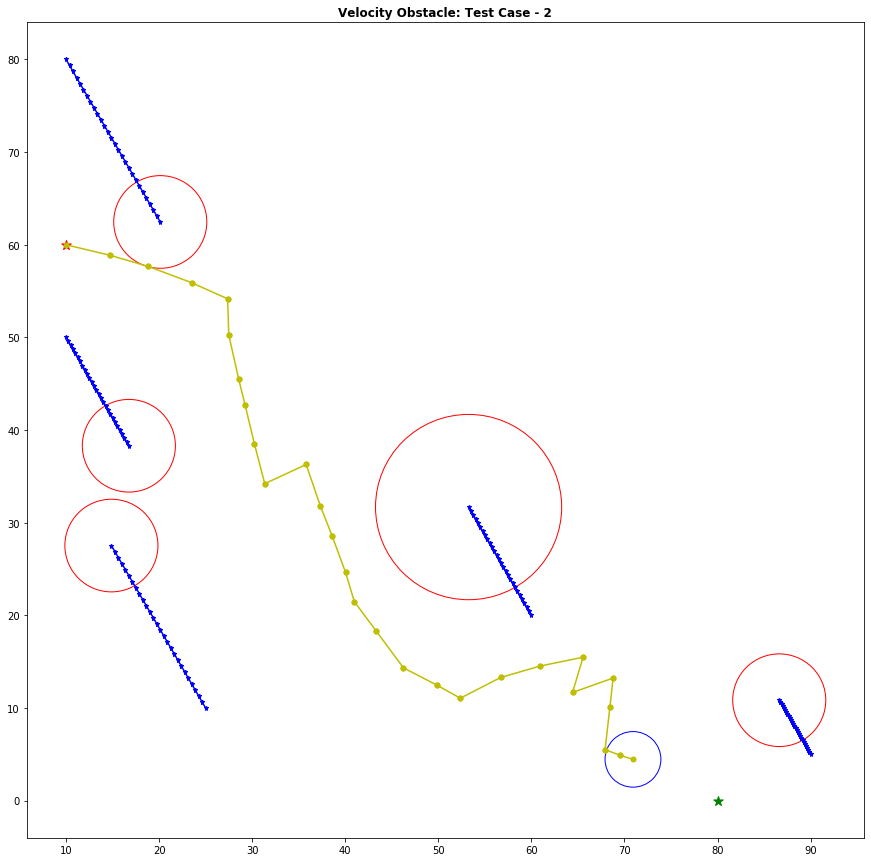

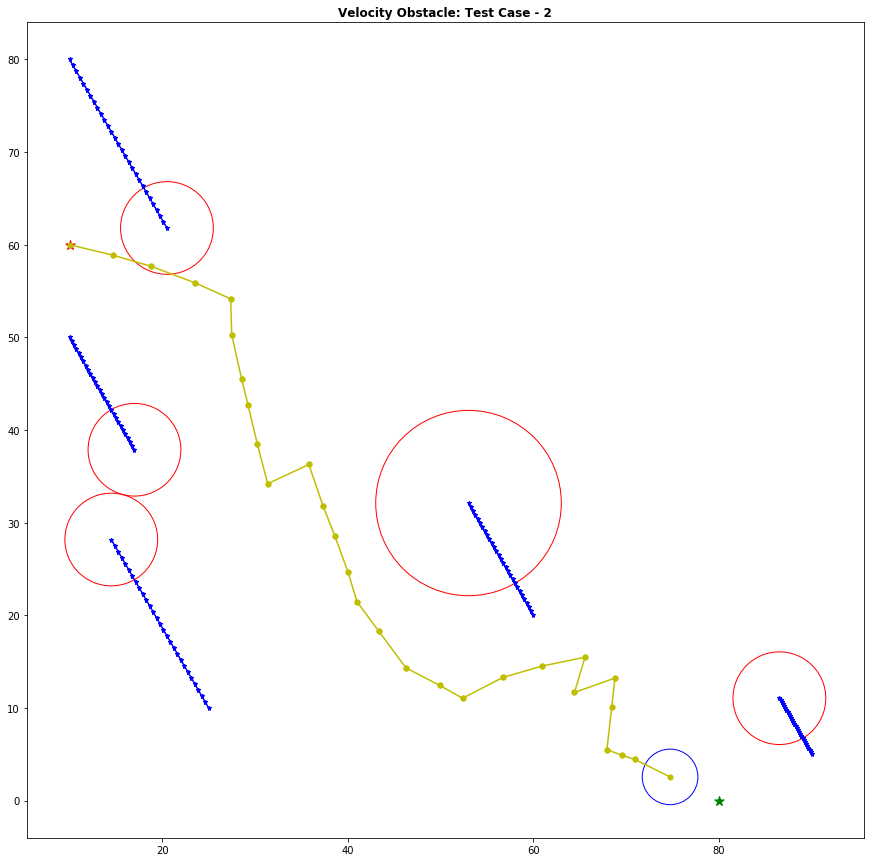

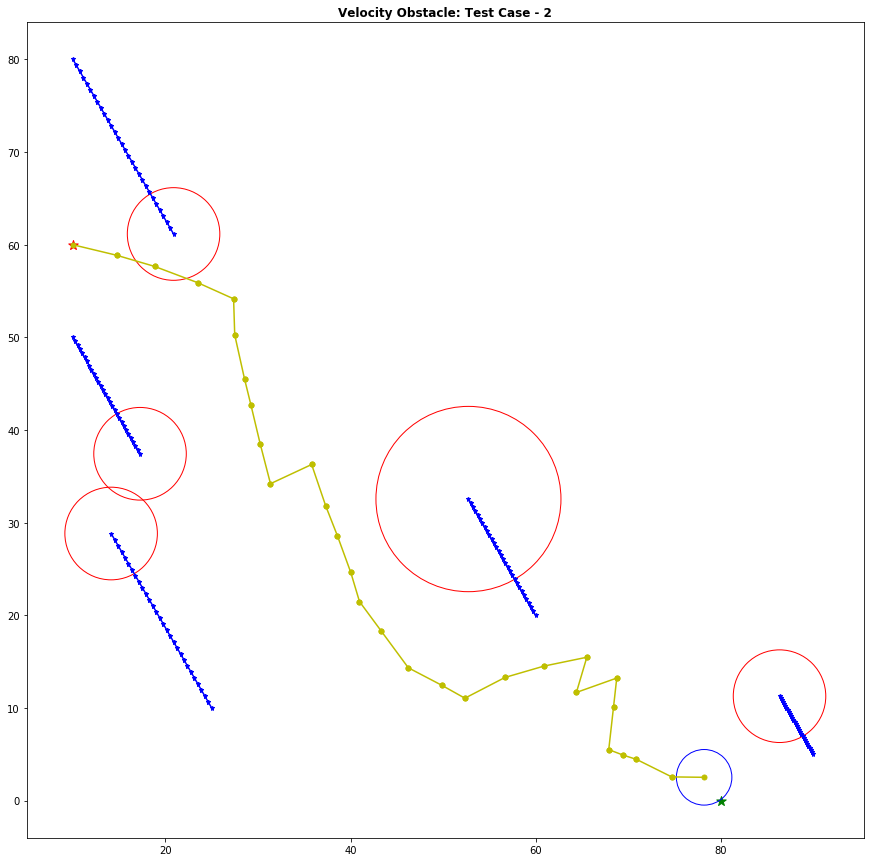

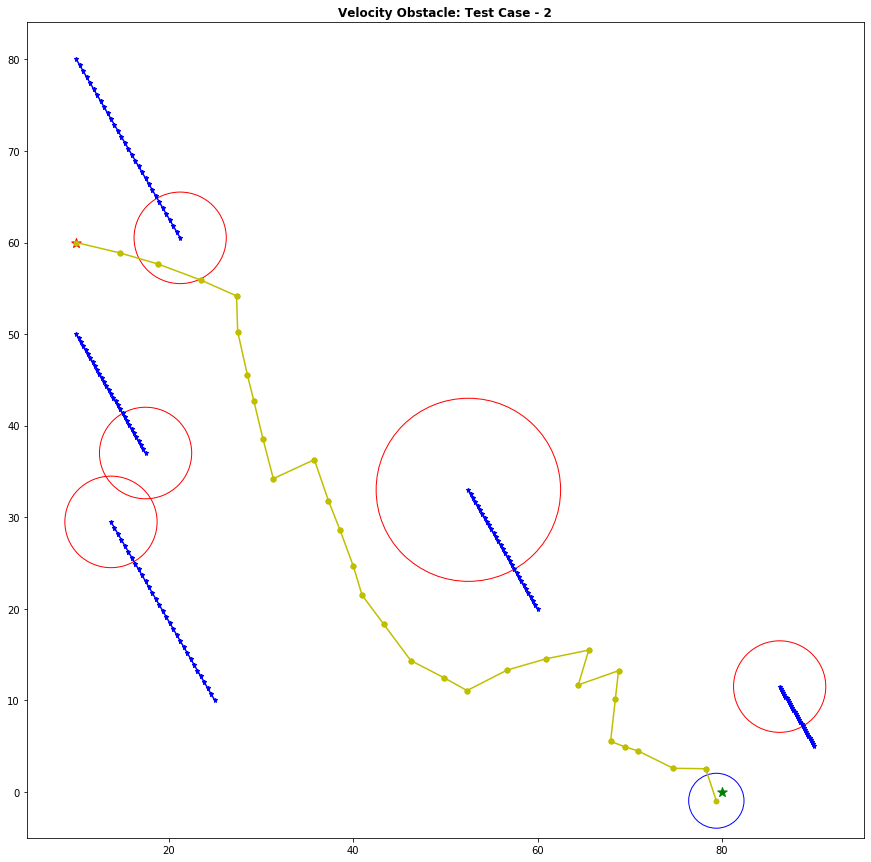

In [14]:
# define the grid dimensions
gridStartX = 0 
gridStartY = 0
gridEndX = 150
gridEndY = 150

# define robot and time parameters
maxVel = 5
robotRadius = 3
dt = 1

# set the start and goal nodes
start = Point(10, 60)   
goal = Point(80, 0)

# define the robot and obstacles
robot = Robot(start.get_x(), start.get_y(), robotRadius, maxVel)
obstacles = obstacles = [   
                            Obstacle(25, 10, 5, 0.75, 2*np.pi/3),
                            Obstacle(10, 50, 5, 0.5, -np.pi/3),
                            Obstacle(60, 20, 10, 0.5, 2*np.pi/3),
                            Obstacle(10, 80, 5 , 0.75, -np.pi/3),
                            Obstacle(90, 5, 5 , 0.25, 2*np.pi/3),
                        ]

# define the environment
env = Env(gridStartX, gridEndX, gridStartY, gridEndY, start, goal)
env.add_title('Velocity Obstacle: Test Case - 2')

# compute the trajectory
VO_traj = VOTrajectory(env, start, goal, robot, obstacles, dt)
VO_traj.engine()

### Test Case: 3

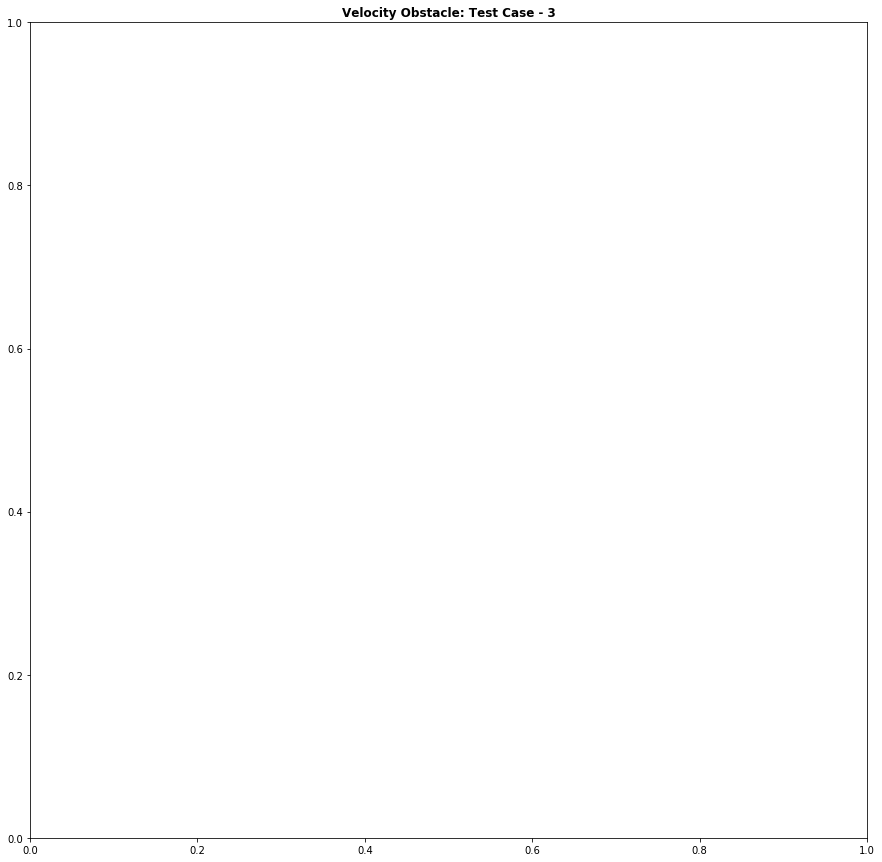

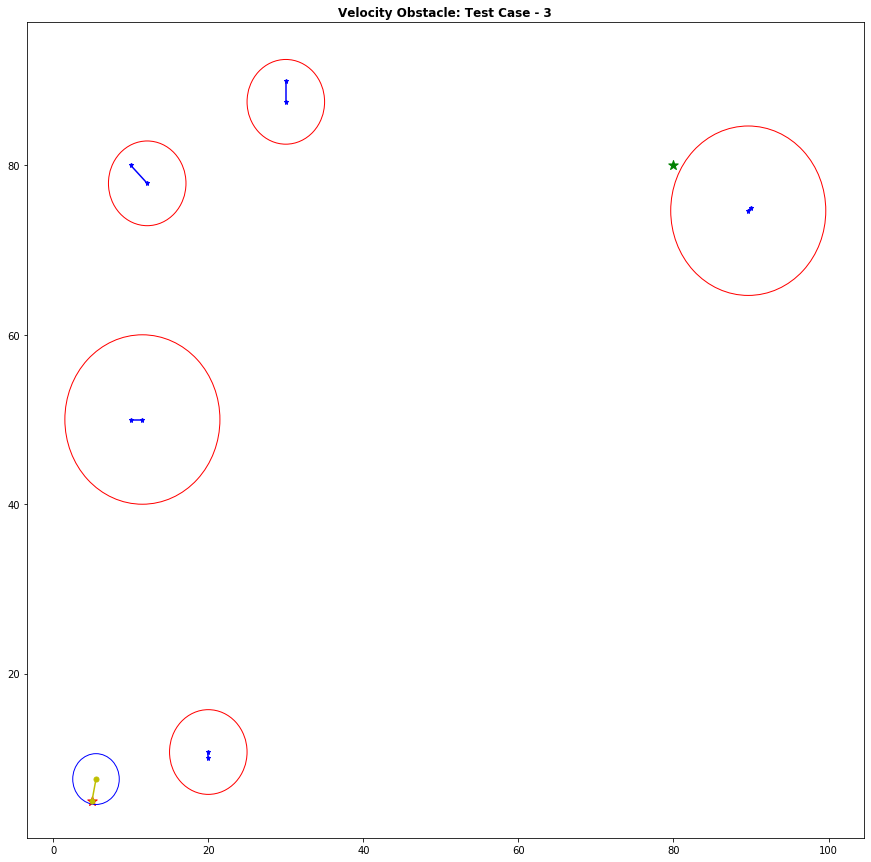

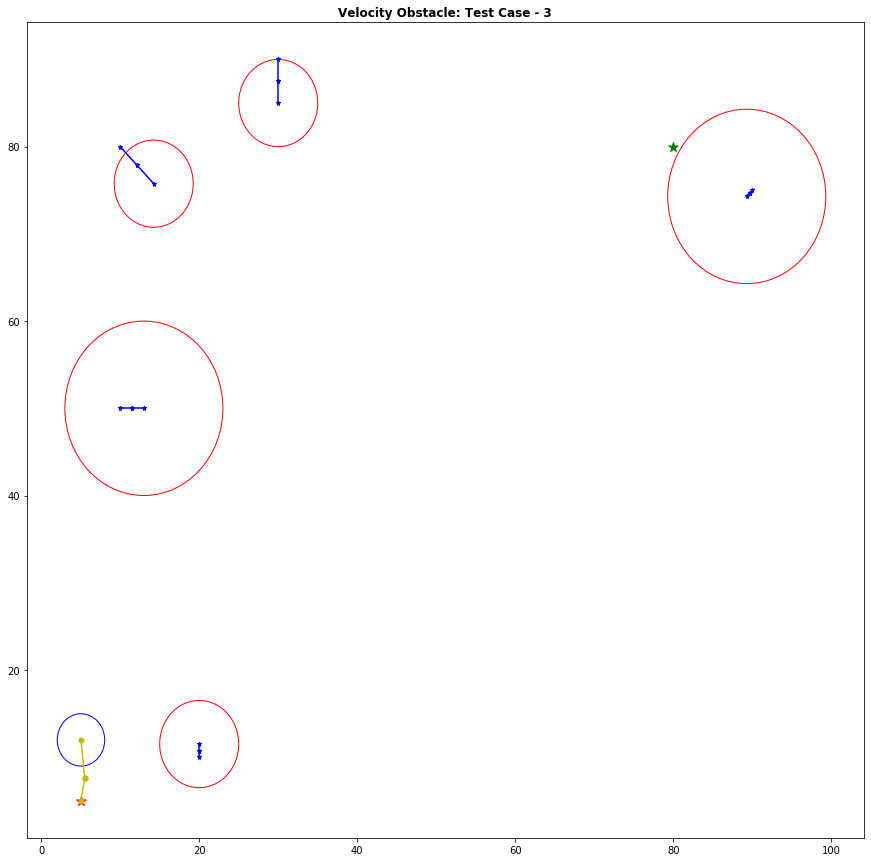

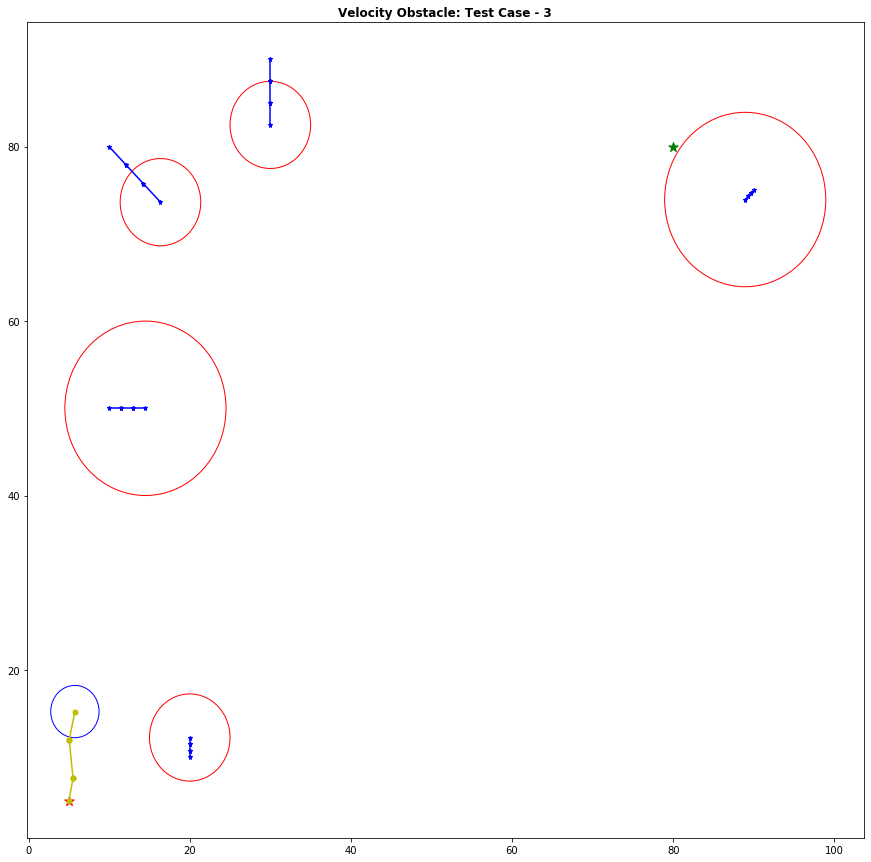

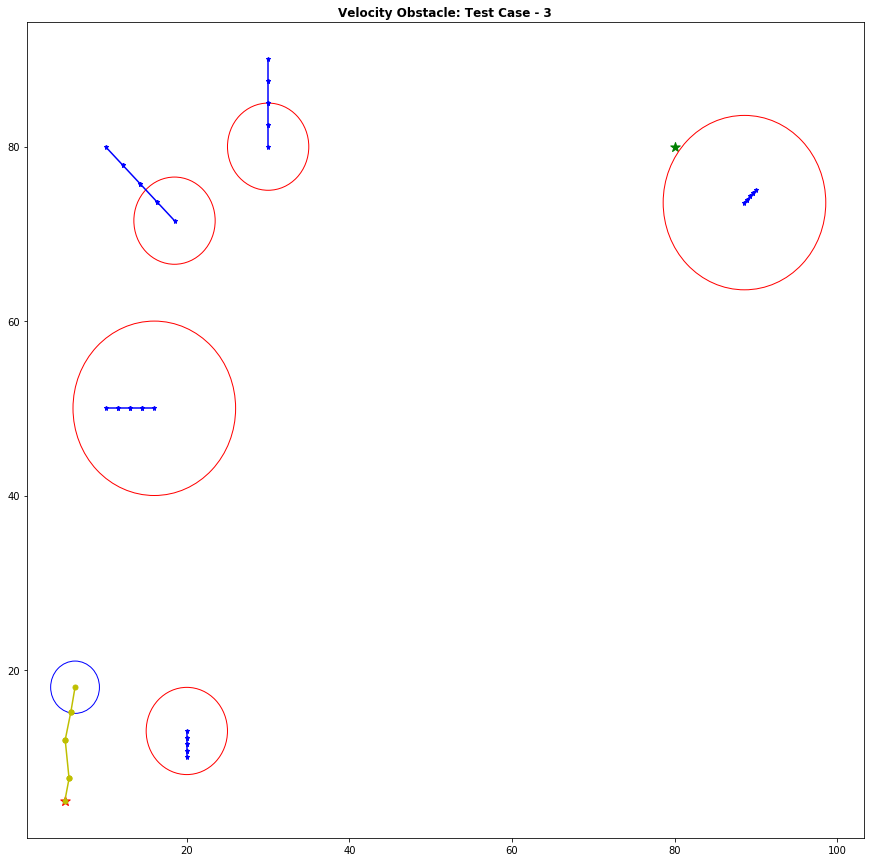

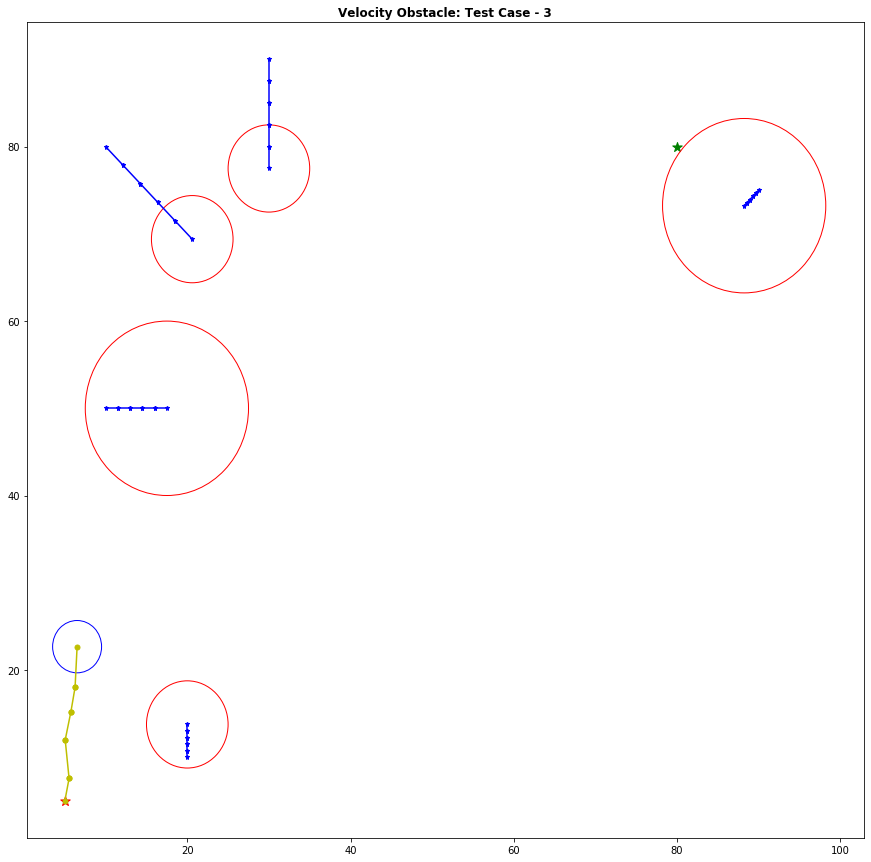

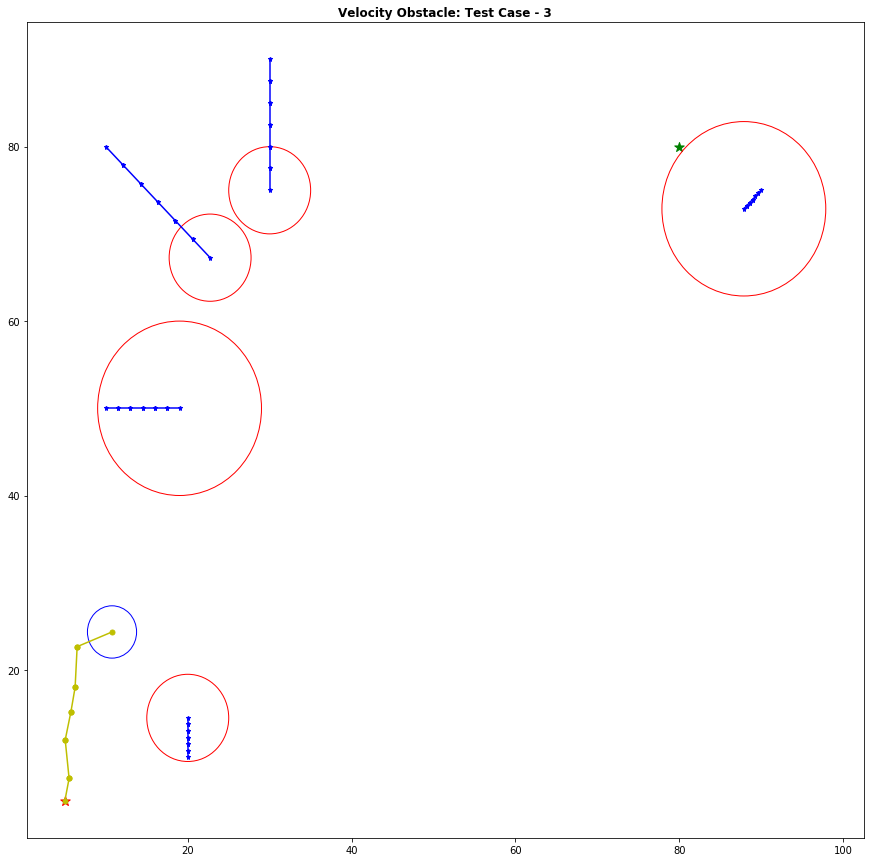

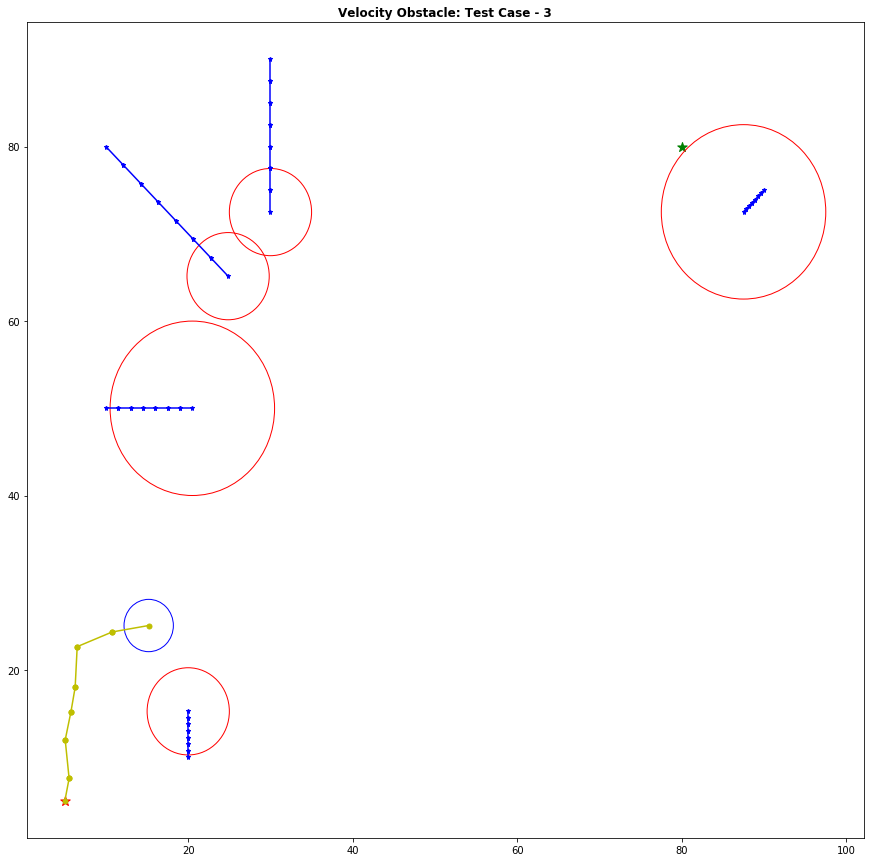

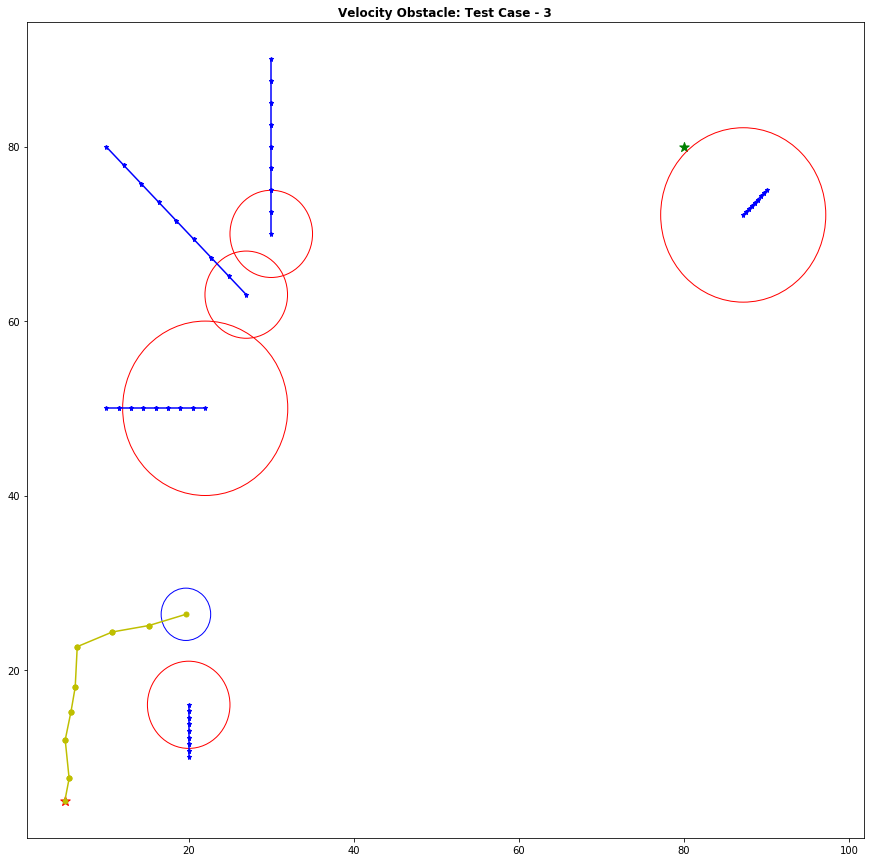

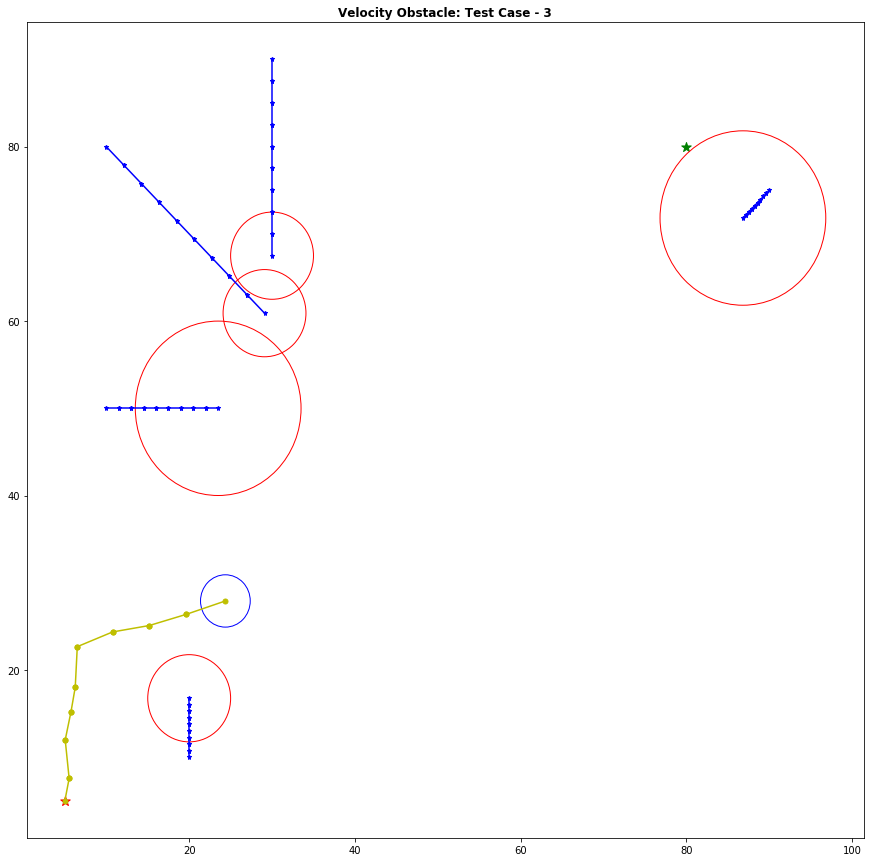

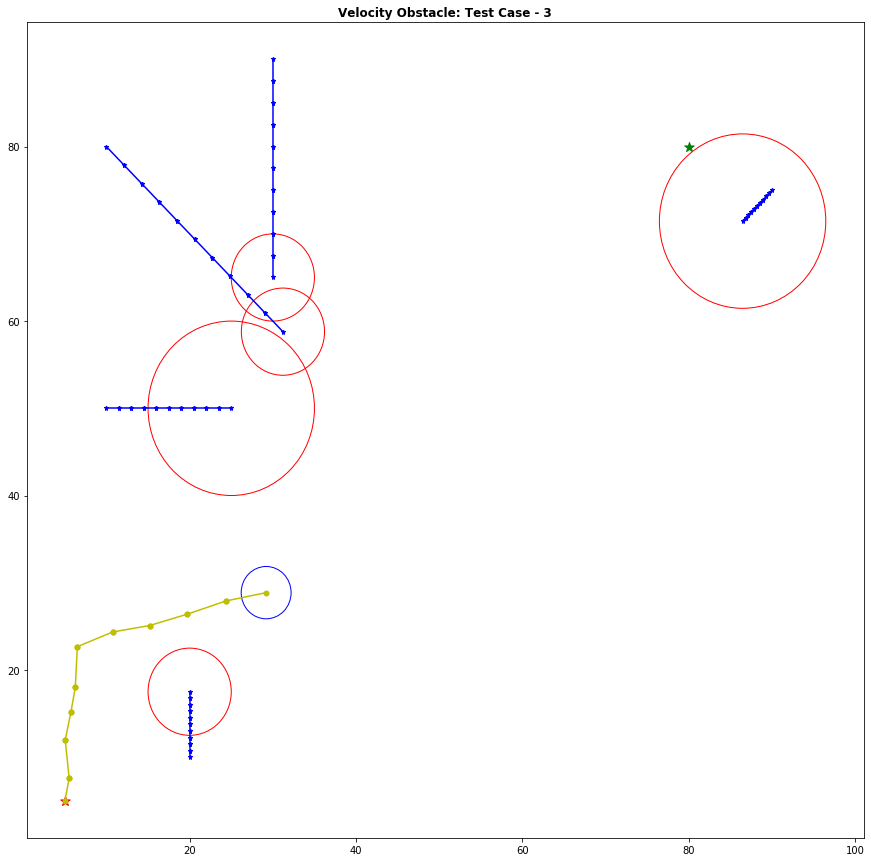

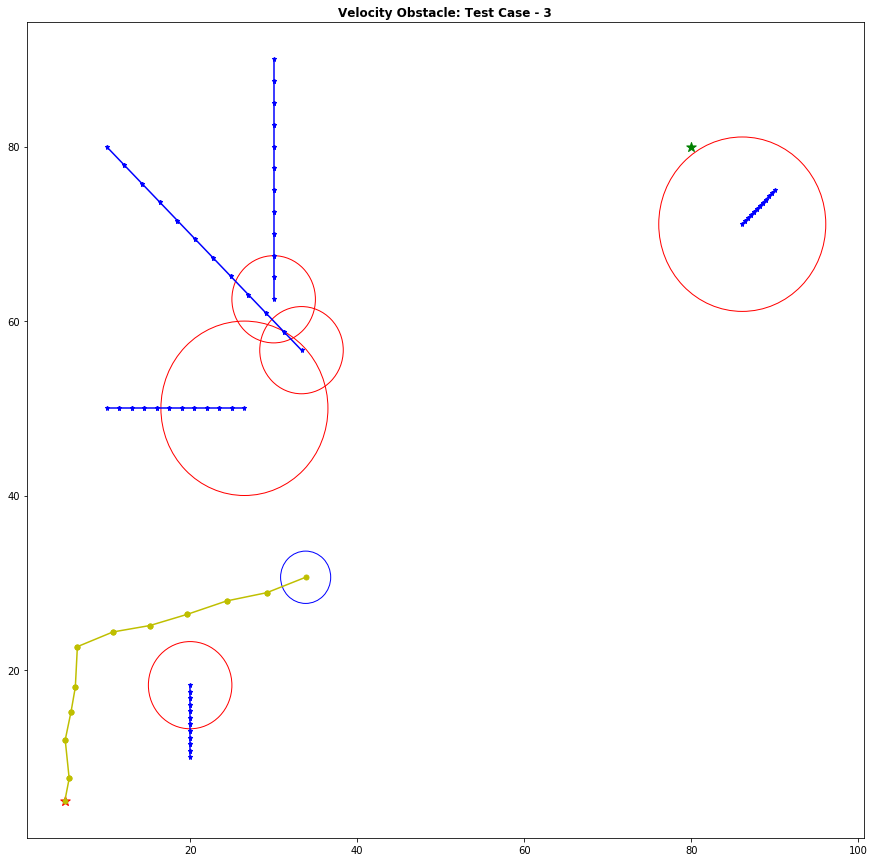

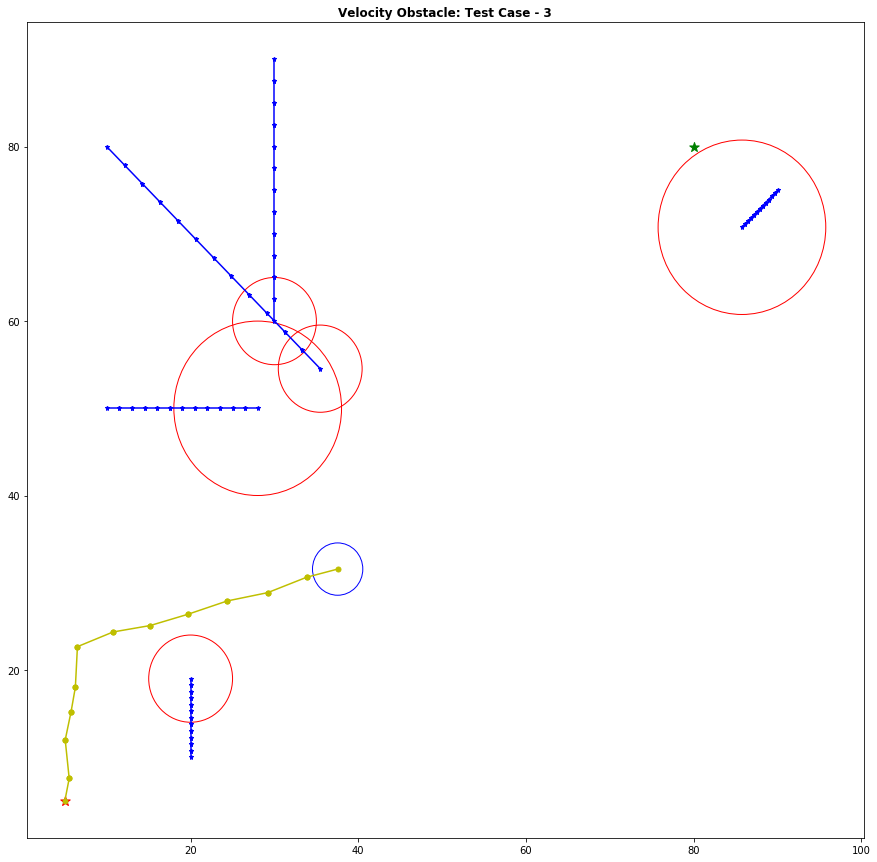

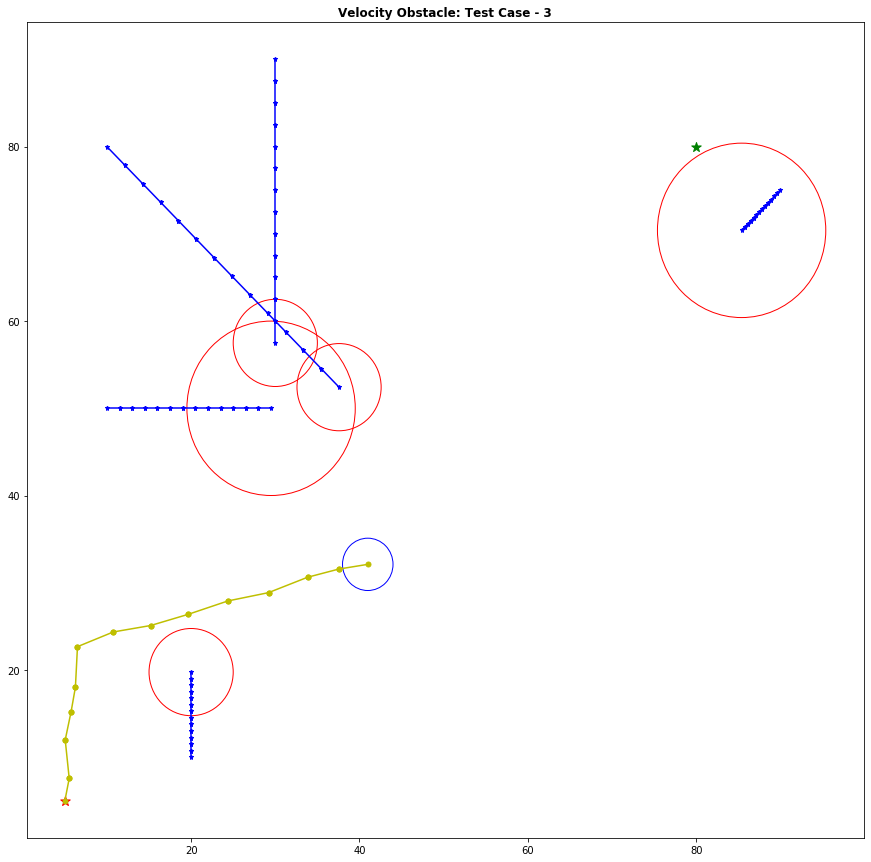

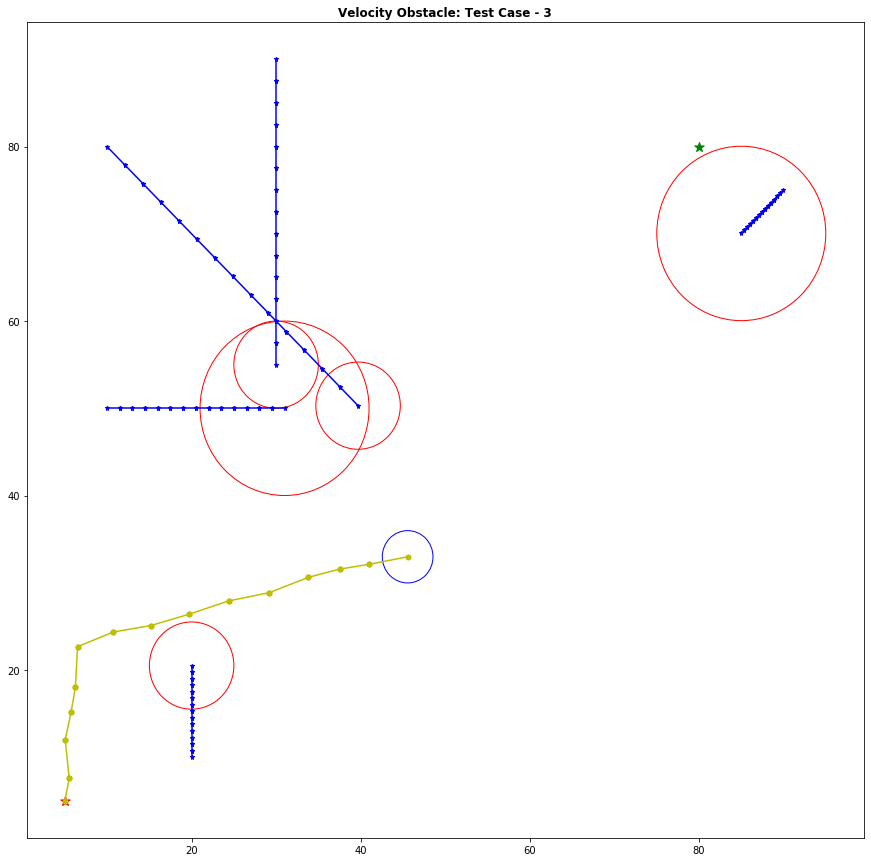

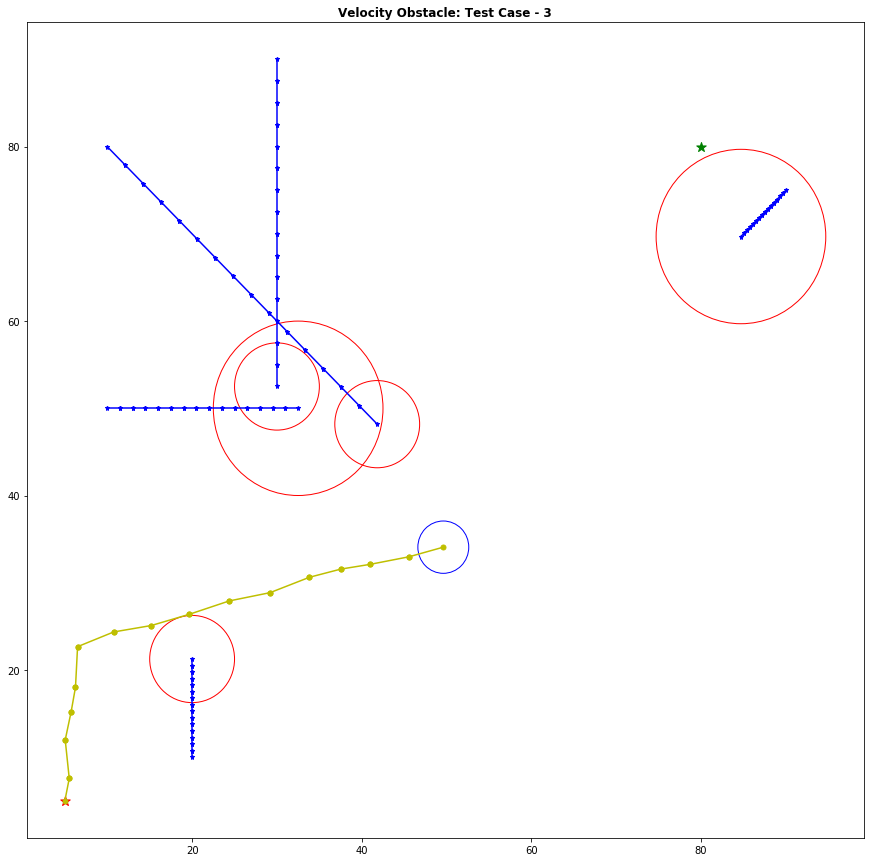

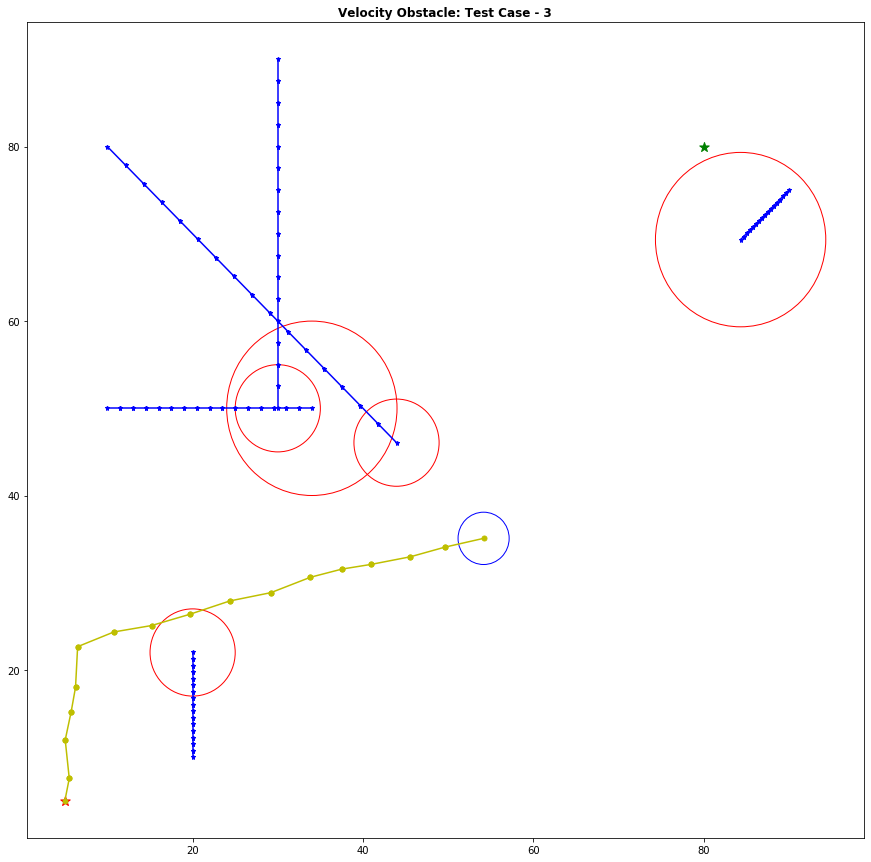

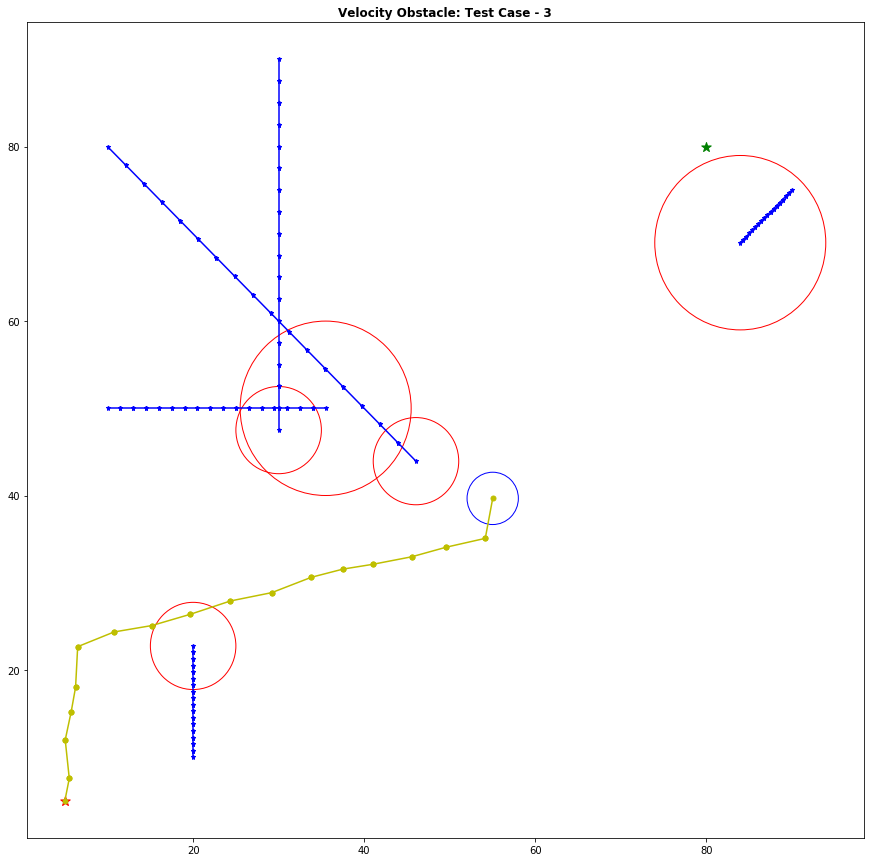

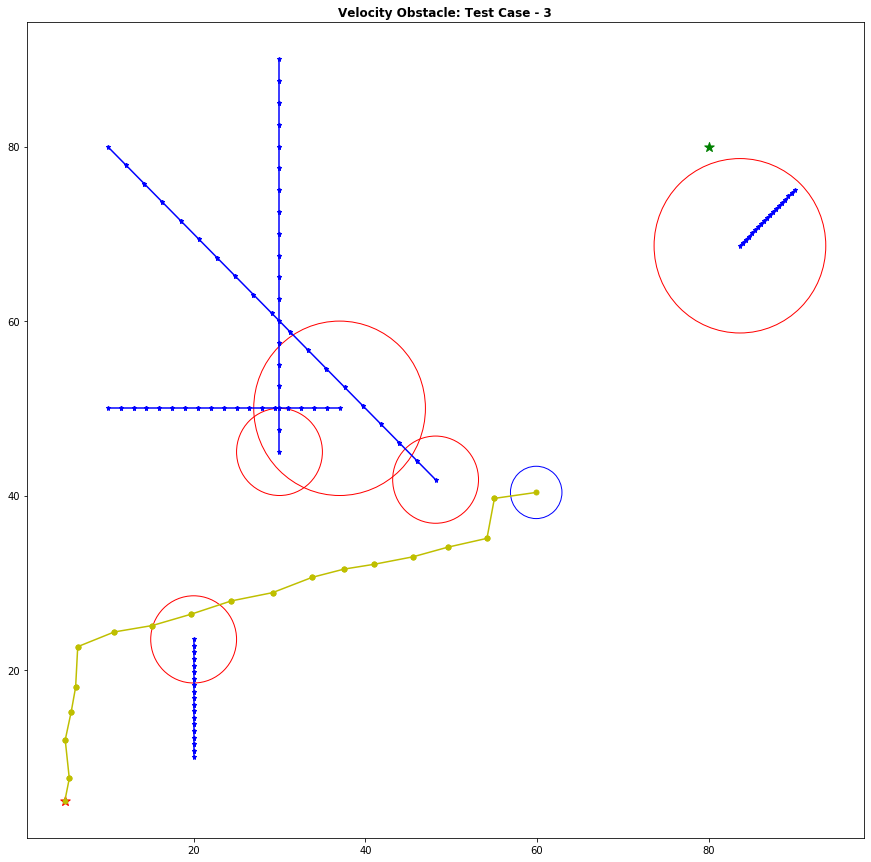

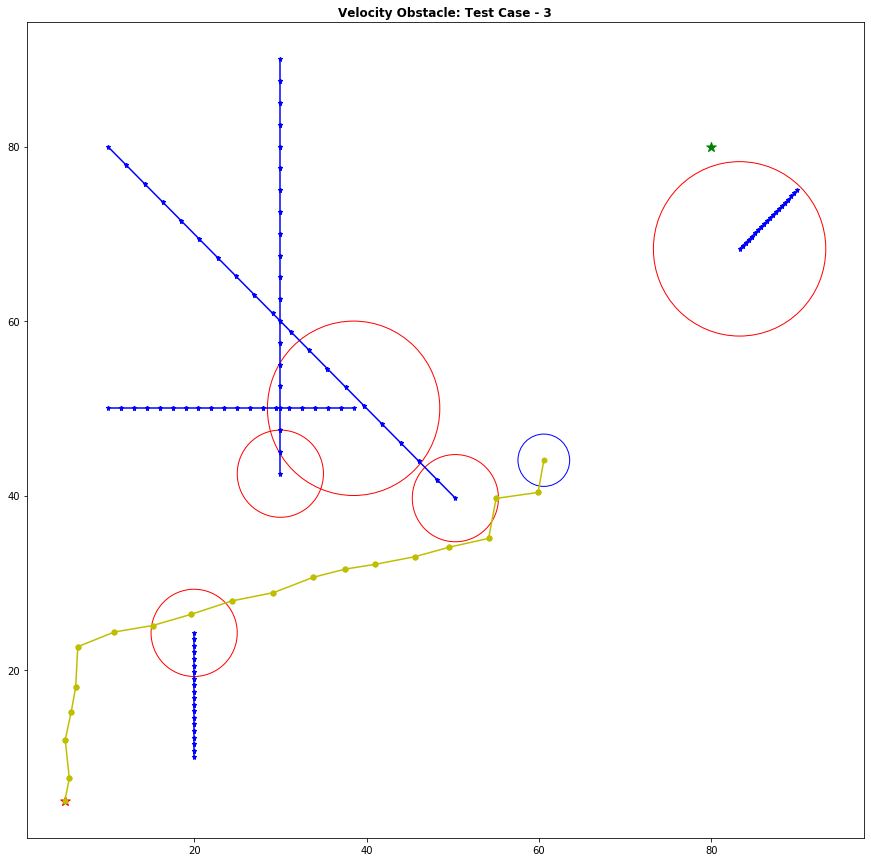

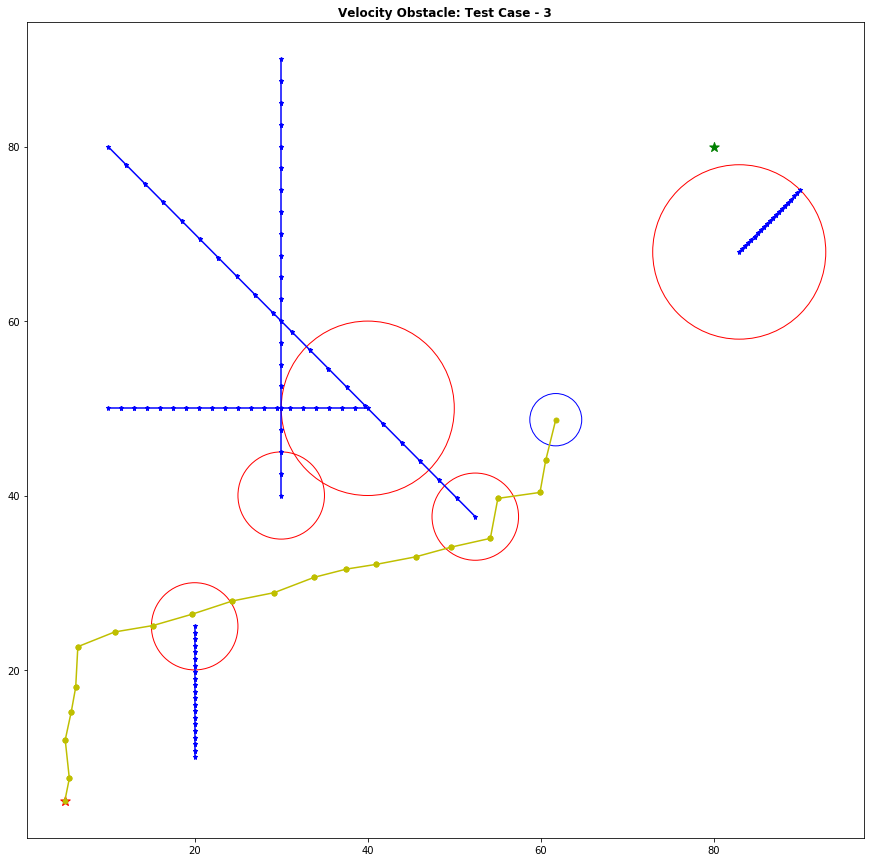

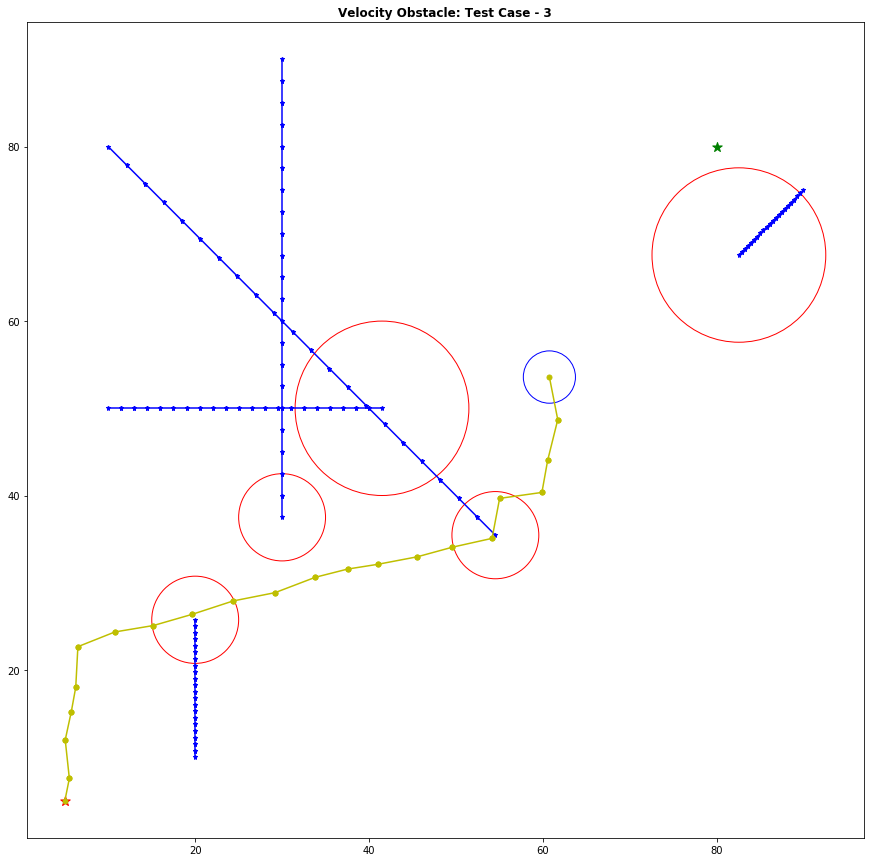

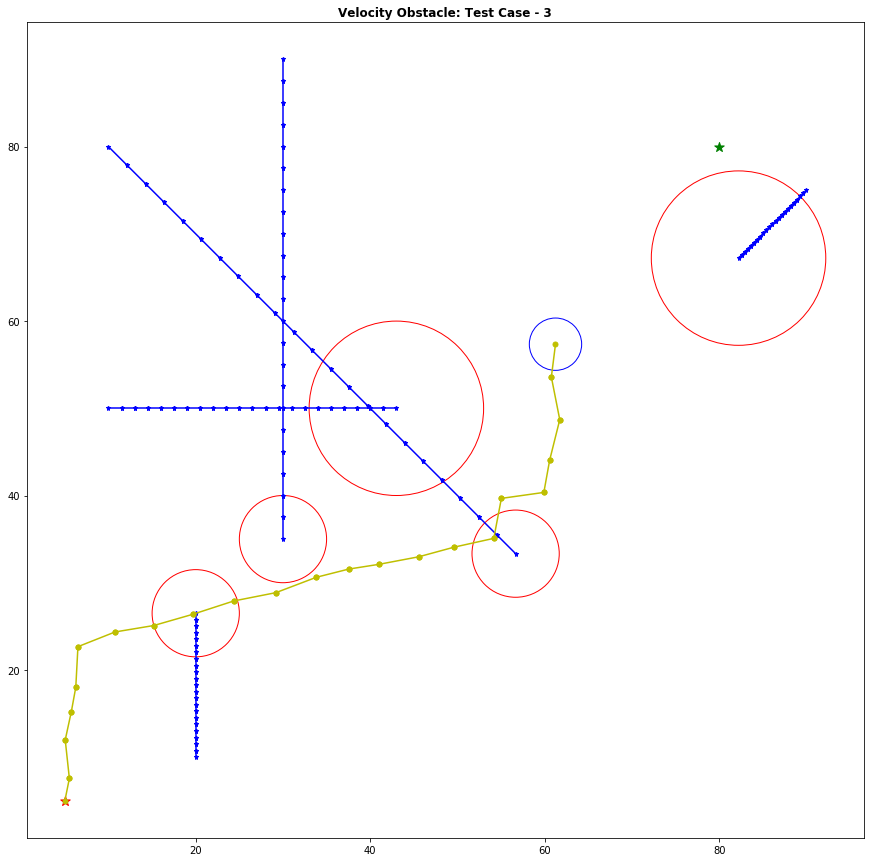

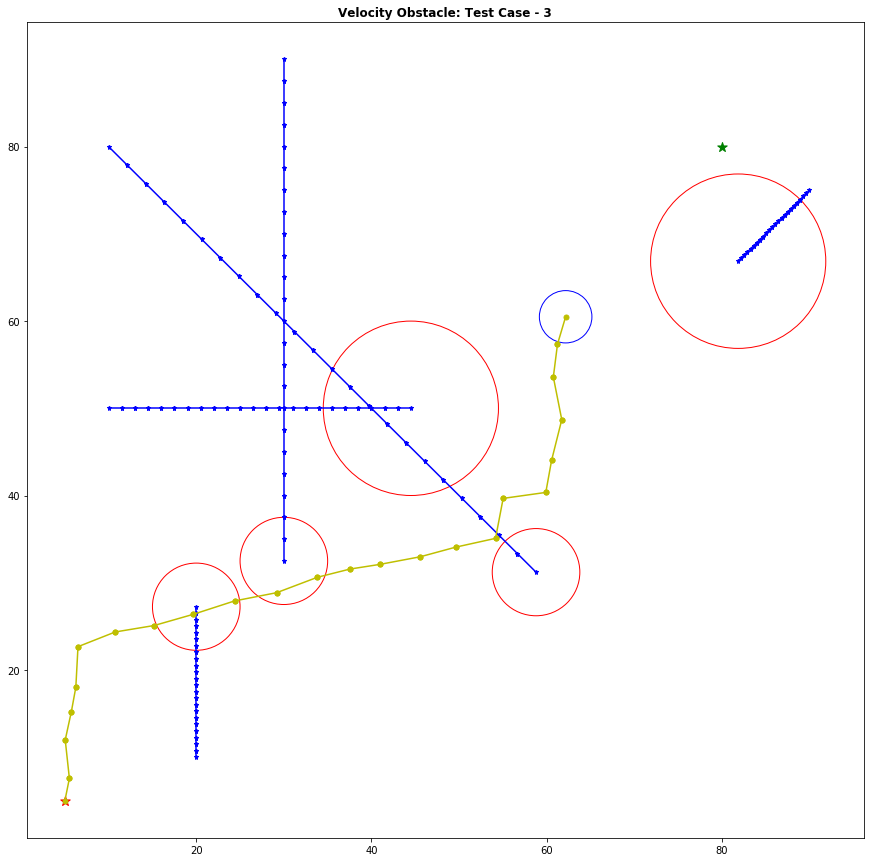

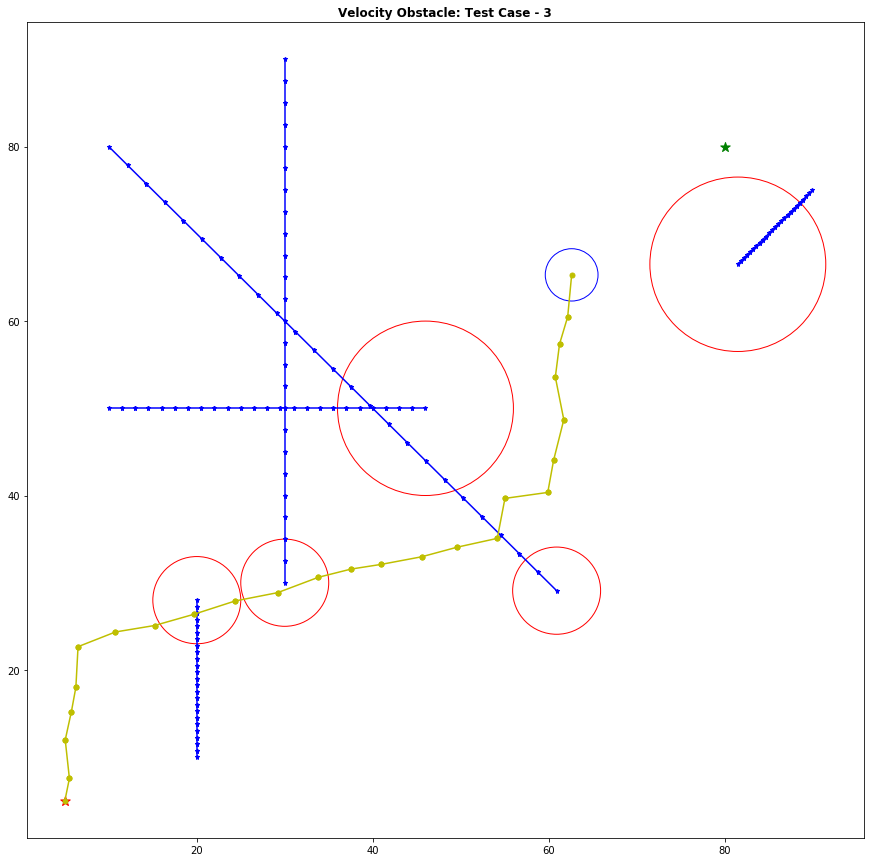

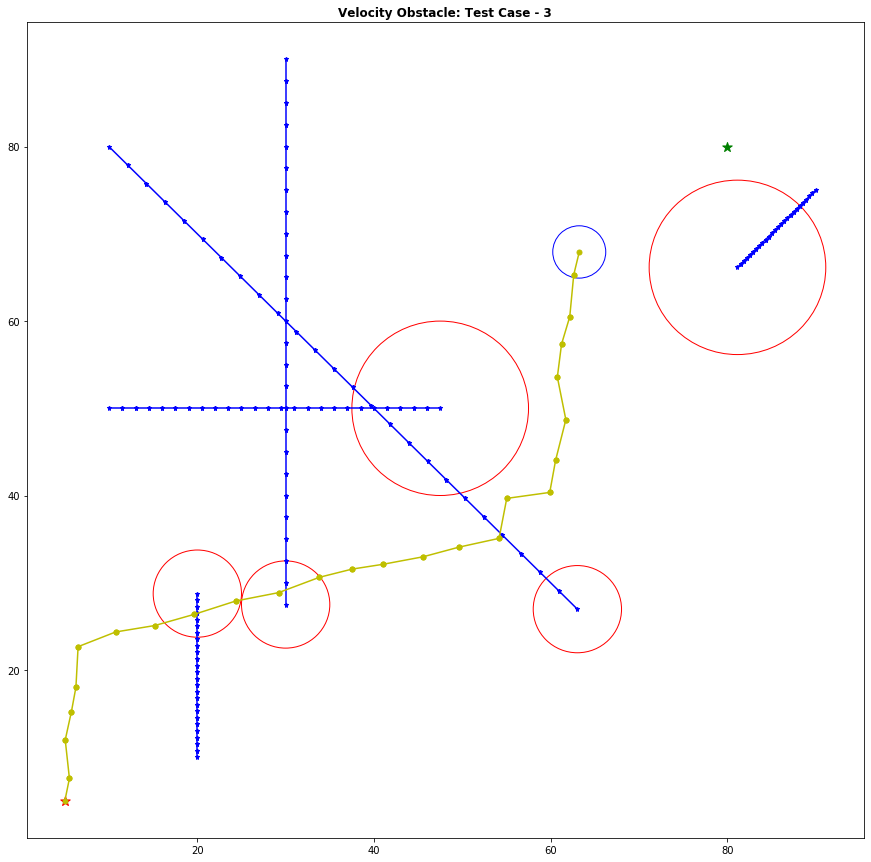

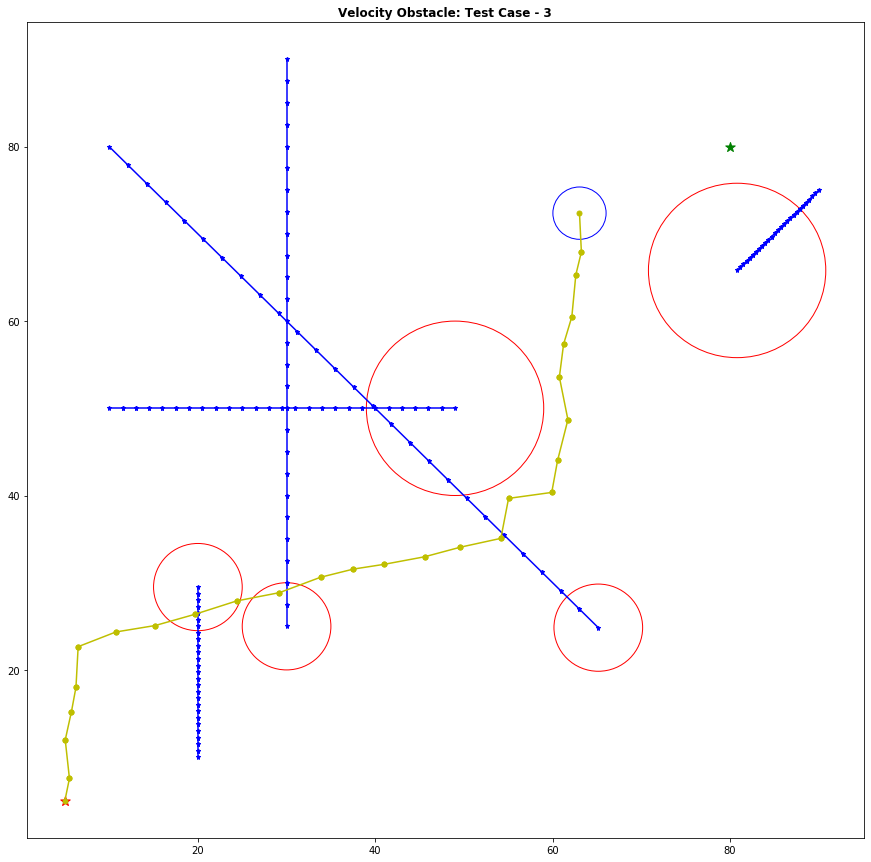

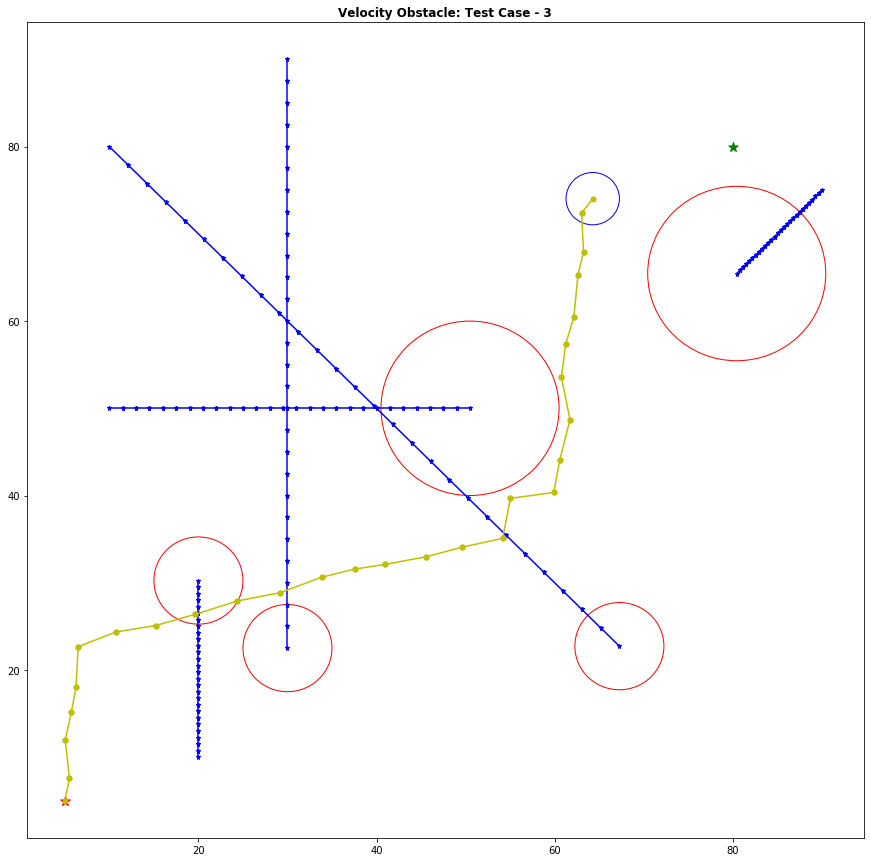

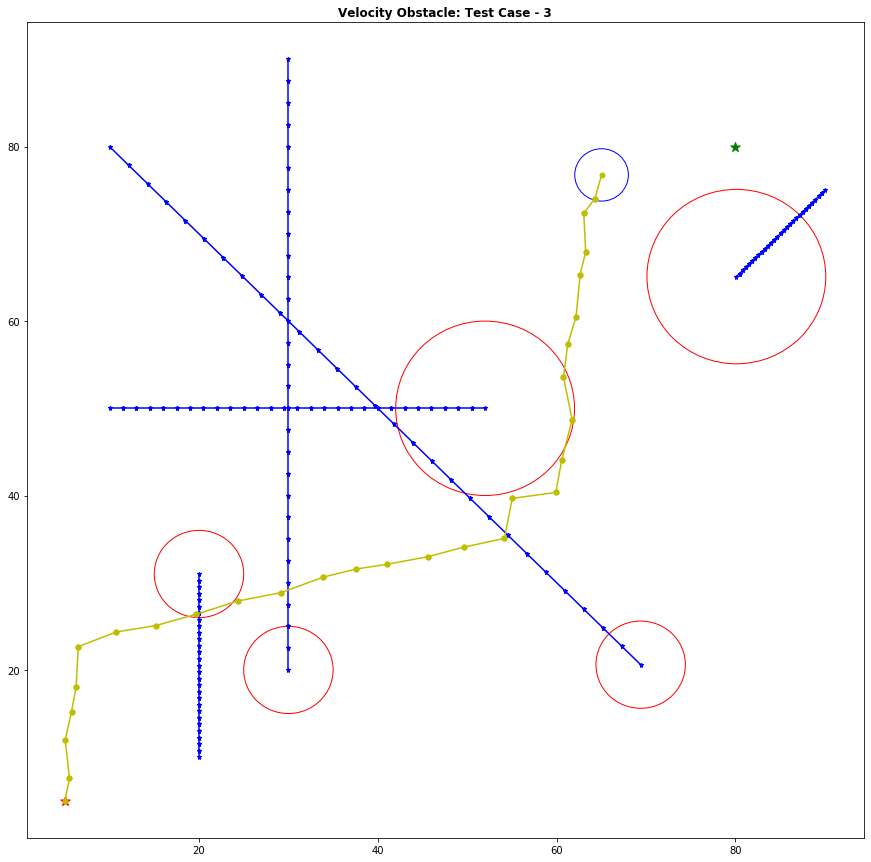

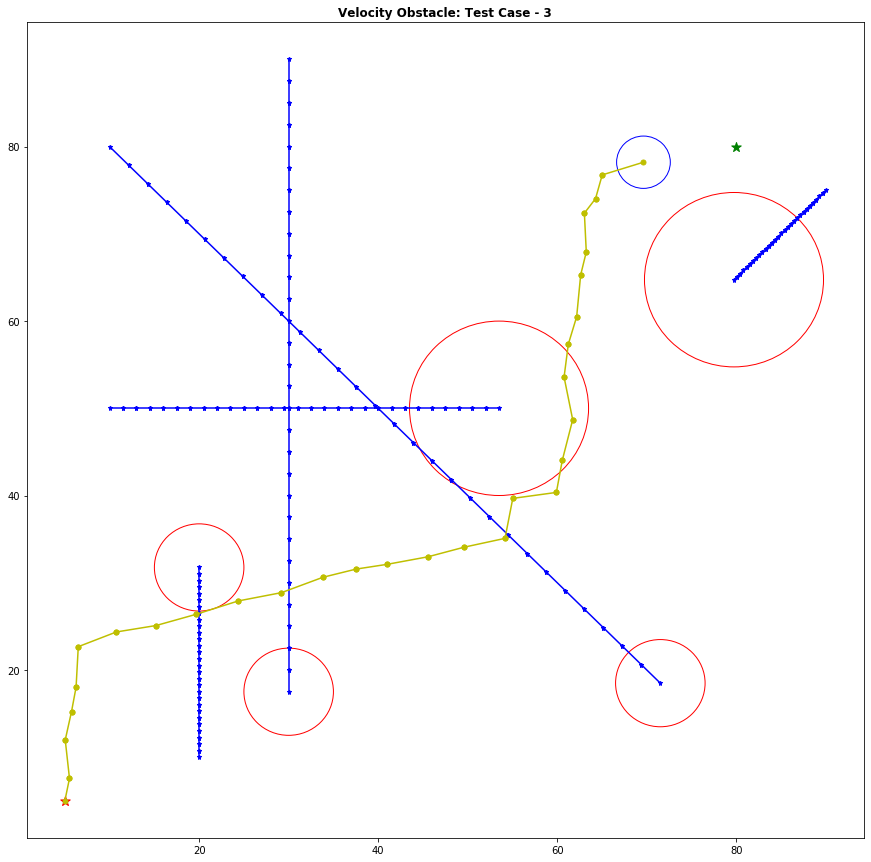

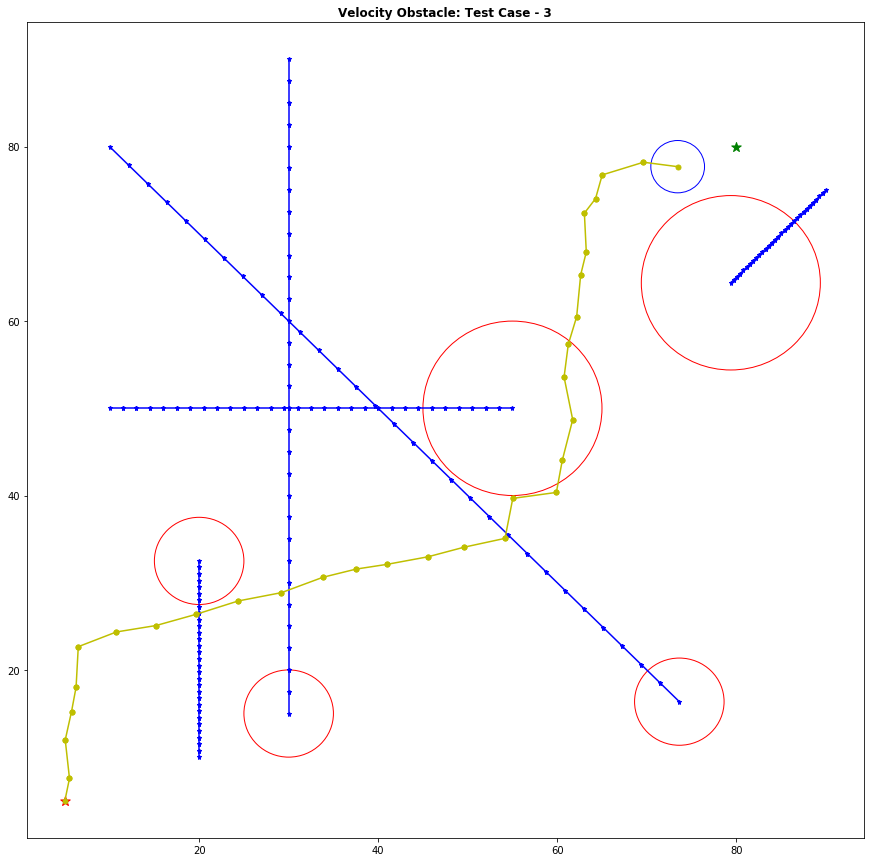

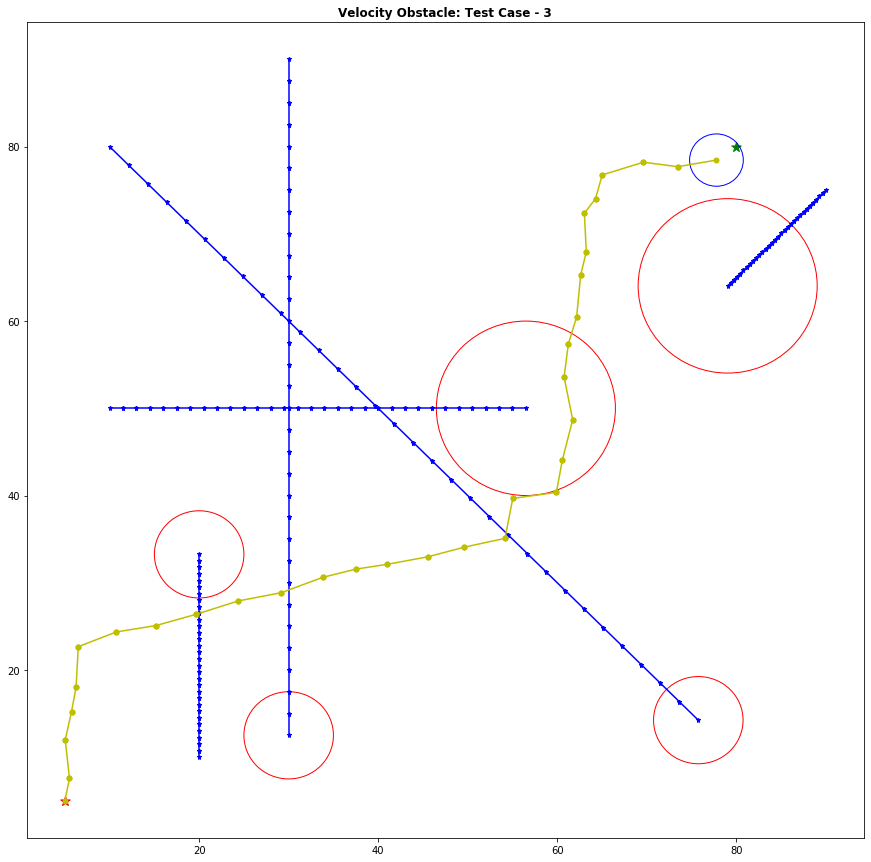

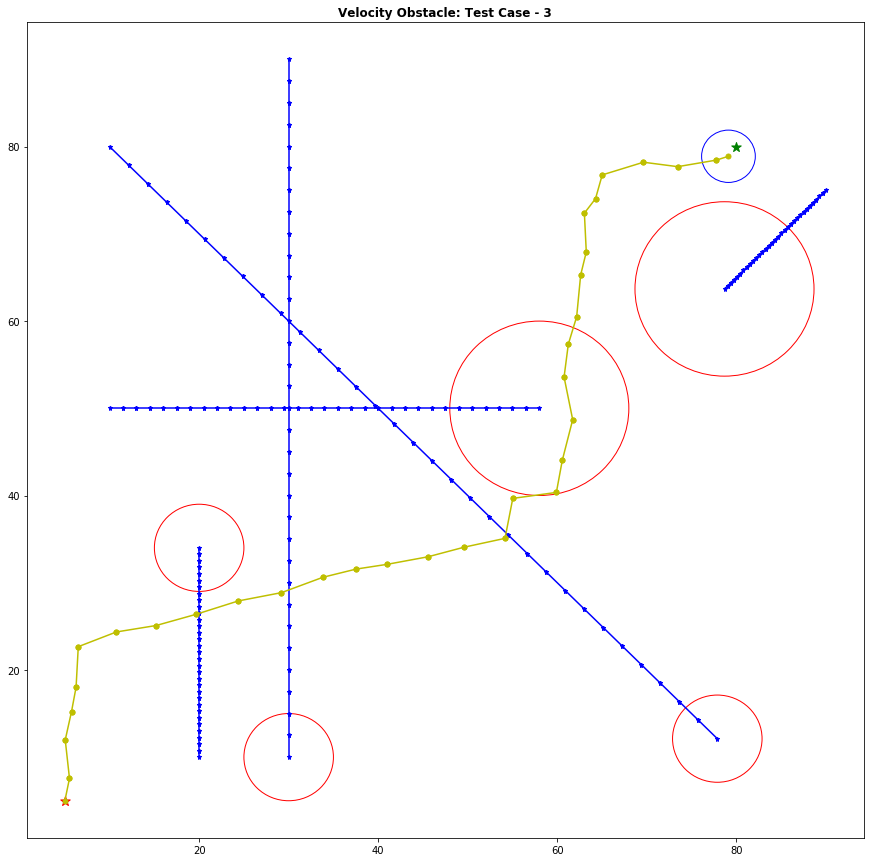

In [20]:
# define the grid dimensions
gridStartX = 0 
gridStartY = 0
gridEndX = 150
gridEndY = 150

# define robot and time parameters
maxVel = 5
robotRadius = 3
dt = 1

# set the start and goal nodes
start = Point(5, 5)   
goal = Point(80, 80)

# define the robot and obstacles
robot = Robot(start.get_x(), start.get_y(), robotRadius, maxVel)
obstacles = obstacles = [   
                            Obstacle(20, 10, 5, 0.75, np.pi/2),
                            Obstacle(30, 90, 5, 2.5, -np.pi/2),
                            Obstacle(90, 75, 10, 0.5, -3*np.pi/4),
                            Obstacle(10, 80, 5 , 3, -np.pi/4),
                            Obstacle(10, 50, 10 , 1.5, 0),
                        ]

# define the environment
env = Env(gridStartX, gridEndX, gridStartY, gridEndY, start, goal)
env.add_title('Velocity Obstacle: Test Case - 3')

# compute the trajectory
VO_traj = VOTrajectory(env, start, goal, robot, obstacles, dt)
VO_traj.engine()

## Contribution
Both members contributed equally.